# **Single-cell RNA sequencing analysis of the immune microenvironment in acute myeloid leukemia**
This project presents a complete and reproducible single-cell RNA sequencing (scRNA-seq) analysis workflow.Using publicly available single-cell datasets `(GSE116256, bone marrow samples from AML patients and healthy donors)`, we performed the entire analytical pipeline from **quality control** to **functional enrichment**.  

Our results revealed an **abnormal proliferative activation state** of *CD4+ T cells* in AML patients,  providing new insights into the mechanisms of immune evasion in acute myeloid leukemia.
  
This work represents **Phase A** of my master’s thesis and PhD preparatory study, corresponding to the first stage of my planned three-phase roadmap:  

- **A: Single-cell RNA-seq analysis:**   *QC, clustering, DEGs, enrichment*
- **B: Multi-omics and drug extension:**  *scATAC integration + target prediction*
- **C: Clinical and spatial integration:**  *Linking to spatial and clinical data*

# **1. Environment setup**

In [1]:
# 1. Locate the project root directory (using the 'here' package)
if (!requireNamespace("here", quietly = TRUE)) {
    if (!requireNamespace("renv", quietly = TRUE)) {
        install.packages("here", repos = "https://cloud.r-project.org")
    } else {
        renv::install("here")
    }
}
message("Using 'here' to locate project root: ", here::here())  # Check project root directory (verification)

# 2. R environment management
if (!requireNamespace("renv", quietly = TRUE)) {
    install.packages("renv", repos = "https://cloud.r-project.org")
}
library(renv)
has_activate <- file.exists(here::here("renv", "activate.R"))
has_lock     <- file.exists(here::here("renv.lock"))

# 2.1 Four environment initialization scenarios
    # Existing environment with lockfile (activate + lock)
if (has_activate && has_lock) {
    source(here::here("renv", "activate.R"))
    renv::restore(prompt = FALSE)
    message("renv environment activated and restored from renv.lock")
} else if (has_activate && !has_lock) {
    # Existing environment without lockfile (activate + no lock)
    source(here::here("renv", "activate.R"))
    message("renv environment activated, but no lockfile found. Will be created after installing dependencies")
} else if (!has_activate && has_lock) {
    # No environment, but lockfile exists
    renv::init(bare = TRUE)         # Only create a base environment, no global snapshot
    renv::restore(prompt = FALSE)   # One-click restore using renv.lock
    message("Initialized and restored project environment from renv.lock")
}else {
    # No environment and no lockfile
    renv::init(bare = TRUE)        # Create structure first; install dependencies later then snapshot
    message("Created a new renv environment structure")
} 

# 3. Register Jupyter kernel (IRkernel)
if (!requireNamespace("IRkernel", quietly = TRUE)) {
    renv::install("IRkernel")
}
# Register R kernel to Jupyter (register only if not already registered)
proj_name <- "AML_OCT"
r_ver <- paste(R.version$major, R.version$minor, sep = ".")    # Read current R version
kernel_name <- sprintf("ir-%s_%s", r_ver, proj_name)           # ir-4.5.1_AML_OCT
kernel_disp <- sprintf("R %s (%s via renv)", r_ver, proj_name) # R 4.5.1 (AML_OCT via renv)
registered <- tryCatch(system("jupyter kernelspec list", intern = TRUE), error = function(e) character())
if (!any(grepl(kernel_name, registered, fixed = TRUE))) {
    IRkernel::installspec(name = kernel_name, displayname = kernel_disp, user = TRUE)
    message("Registered Jupyter kernel: ", kernel_disp)
} else {
    message("Jupyter kernel already exists: ", kernel_disp)
}

# 4. Core package dependency installation (CRAN / Bioconductor)
need_pkgs <- c(
    "Seurat", "tidyverse", "patchwork",
    "pheatmap", "RColorBrewer", "Matrix",
    "future", "future.apply", "here", 
    "IRdisplay", "devtools", "BiocManager", 
    "ggrepel", "colorspace", "Cairo"
)
need_bioc_pkgs <- c("clusterProfiler", "org.Hs.eg.db", "enrichplot")

proj_lib <- renv::paths$library()
installed_pkgs <- if (dir.exists(proj_lib)) rownames(installed.packages(lib.loc = proj_lib)) else character()
# 4.1 Find all missing packages
missing_pkgs <- setdiff(c(need_pkgs, need_bioc_pkgs), installed_pkgs)
if (length(missing_pkgs) > 0) {
    message(paste("Missing packages detected: ", paste(missing_pkgs, collapse = ", ")))
    
    # Separate packages that need to be installed from CRAN and Bioconductor
    cran_to_install <- intersect(missing_pkgs, need_pkgs)
    bioc_to_install <- intersect(missing_pkgs, need_bioc_pkgs)
    
    # Case 1: Missing packages detected
    # Install missing CRAN packages
    if (length(cran_to_install) > 0) {
        message(paste("Installing from CRAN: ", paste(cran_to_install, collapse = ", ")))
        renv::install(cran_to_install)
    }
    # Install missing Bioconductor packages
    if (length(bioc_to_install) > 0) {
        message(paste("Installing from Bioconductor: ", paste(bioc_to_install, collapse = ", ")))
        BiocManager::install(bioc_to_install, update = FALSE)
    }
    
    message("Dependencies installed. Updating renv.lock snapshot")  # Only update the lockfile after new packages are installed
    renv::snapshot(prompt = FALSE)
    
} else if (!has_lock && has_activate) {
    # Case 2: No missing packages, but lockfile is missing: create snapshot
    message("renv environment activated but no lockfile found. Creating renv.lock")
    renv::snapshot(prompt = FALSE)
} else {
    # Case 3: No missing packages and lockfile exists: no snapshot needed
    message("All CRAN/Bioconductor package dependencies are satisfied")
}

# 5. Load all core analysis libraries
core_pkgs <- c(
    "Seurat", "tidyverse", "patchwork", "pheatmap", "RColorBrewer", 
    "Matrix", "future", "future.apply", "here", "IRdisplay", 
    "devtools", "clusterProfiler", "org.Hs.eg.db", "ggrepel", 
    "enrichplot", "colorspace", "Cairo"
)

# Use lapply to load each package in the list
suppressPackageStartupMessages({
    invisible(lapply(core_pkgs, library, character.only = TRUE))
})

# 6. Install GitHub package (presto)
if (!requireNamespace("presto", quietly = TRUE)) {
    message("Package 'presto' not found. Installing from GitHub to speed up analysis")
    devtools::install_github("immunogenomics/presto")
    # Update renv lockfile immediately after installation
    message("'presto' installed. Updating renv.lock snapshot")
    renv::snapshot(prompt = FALSE)
}

# 7. Create output directories
data_dir <- here::here("GSE116256_RAW")
out_fig  <- here::here("figures")
out_res  <- here::here("results")

dir.create(out_fig, showWarnings = FALSE, recursive = TRUE)
dir.create(out_res, showWarnings = FALSE, recursive = TRUE)

# 8. Define figure saving function
options(jupyter.plot_mimetypes = c("image/png"))  # Force output image format to PNG
# Unified save + display image function
show_plot <- function(
    p, filename, folder = out_fig, 
    width = 10, height = 6, dpi = 300, scale = 1, 
    bg = "white", preview_width = 600, save_pdf = TRUE
){
    stopifnot(inherits(p, "ggplot"), is.character(filename), length(filename) == 1)
    
    base_filename <- tools::file_path_sans_ext(filename)
    pngfile <- file.path(folder, paste0(base_filename, ".png"))
    pdffile <- file.path(folder, paste0(base_filename, ".pdf"))

    # Save image
    ggsave(
        filename = pngfile, plot = p,
        width = width, height = height, dpi = dpi,
        scale = scale, bg = bg, units = "in"
    )
    if (save_pdf) {
    has_cairo <- requireNamespace("Cairo", quietly = TRUE)
    pdf_device <- if (has_cairo) cairo_pdf else "pdf"
    ggsave(
        filename = pdffile,
        plot = p,
        width = width, height = height,
        device = pdf_device,
        bg = bg, units = "in"
    )
    }
    IRdisplay::display_png(file = pngfile, width = preview_width, height = preview_width)
}
message("Project initialization complete")

Using 'here' to locate project root: C:/Users/b1795/Desktop/AML_OCT_v2


Attaching package: 'renv'


The following objects are masked from 'package:stats':

    embed, update


The following objects are masked from 'package:utils':

    history, upgrade


The following objects are masked from 'package:base':

    autoload, load, remove, use




- The library is already synchronized with the lockfile.


renv environment activated and restored from renv.lock

Registered Jupyter kernel: R 4.5.1 (AML_OCT via renv)

All CRAN/Bioconductor package dependencies are satisfied

Project initialization complete



# **2. Data loading and merging**

In [2]:
# 1. Set up parallel computing environment
workers <- max(1, future::availableCores() - 1)
oplan <- future::plan(future::multisession, workers = workers)
message(paste("Parallel backend set up with", workers, "workers."))

# 2. Define function to read one sample
read_one_sample <- function(file_path) {
    message("Reading file: ", basename(file_path))
    
    # Read compressed file using gzfile()
    expr_matrix <- read.delim(gzfile(file_path), row.names = 1, check.names = FALSE)
    
    # Normalize delimiters in gene names and cell names
    colnames(expr_matrix) <- gsub("_", "-", colnames(expr_matrix))
    rownames(expr_matrix) <- gsub("_", "-", rownames(expr_matrix))

    # Convert data frame to sparse matrix (dgCMatrix) to save memory
    expr_matrix <- as(as.matrix(expr_matrix), "dgCMatrix")
    
    # Extract metadata more robustly from the filename
    stem <- sub("\\.dem\\.txt\\.gz$", "", basename(file_path))
    sample <- sub("_.*", "", stem)
    tag    <- sub("^.*?_", "", stem)
    time   <- ifelse(grepl("-(D\\d+)", tag), sub("^.*-(D\\d+).*","\\1", tag), NA)

    # Create Seurat object and perform basic filtering
    seurat_obj <- CreateSeuratObject(
        counts = expr_matrix, project = stem,
        min.cells = 3, min.features = 200  
    )

    # Add extracted metadata to the Seurat object's meta.data
    seurat_obj$sample <- sample
    seurat_obj$tag    <- tag
    seurat_obj$time   <- time
    return(seurat_obj)
}

# 3. Read all samples in parallel
files_to_process <- sort(list.files(data_dir, pattern = "dem\\.txt\\.gz$", full.names = TRUE))

# Check if files are found, stop execution if none
stopifnot("No data files found. Check 'data_dir' and file patterns" = length(files_to_process) > 0)

# Use future_lapply to process all files in parallel
all_seurat_objects <- future_lapply(files_to_process, read_one_sample)
message("All samples have been read and converted to Seurat objects")

# 4. Merge all Seurat objects
message("Starting to merge all Seurat objects")
sample_ids <- vapply(all_seurat_objects, function(x) unique(x$sample)[1], character(1))
all_seurat_objects <- Map(function(obj, id) RenameCells(obj, add.cell.id = id), all_seurat_objects, sample_ids) # Add sample IDs to cell names

# Check cell counts per individual object before merging (showing first 10)
message("Cell counts per individual object (before merging, showing first 10):")
cell_counts <- sapply(all_seurat_objects, ncol)
print(head(cell_counts, 10))

# Merge all Seurat objects using merge()
if (length(all_seurat_objects) > 1) {
    seu_merged <- merge(x = all_seurat_objects[[1]], y = all_seurat_objects[2:length(all_seurat_objects)])
} else {
    seu_merged <- all_seurat_objects[[1]]
}
message("All Seurat objects have been merged")

# Initial inspection of the merged object
message("Merged Seurat Object Summary:")
print(seu_merged)  # Print basic object summary
message("Dimensions (genes x cells): ", paste(dim(seu_merged), collapse = " x "))  # Basic dimensions (genes × cells)

message("Cell counts per sample:")
print(table(seu_merged$sample))  # Number of cells per sample/time point

message("\nCell counts per time point:")
print(table(seu_merged$time, useNA = "ifany"))   # Count cells for each time point

# 5. Pre-calculate QC metrics
message("\nCalculating mitochondrial gene percentage")
seu_merged[["percent.mt"]] <- PercentageFeatureSet(seu_merged, pattern = "^MT-")  # Calculate percent.mt column
message("QC metrics calculated")

# 6. Save merged object
output_file <- file.path(out_res, "seu_merged_with_qc.rds") # Save merged Seurat object as RDS file
saveRDS(seu_merged, file = output_file)
message("Merged object with QC metrics saved to: ", output_file)

# 6.1 Clean up environment
rm(all_seurat_objects)
gc() # Trigger garbage collection
message("Data Loading, Merging, and QC Calculation Finished")


Parallel backend set up with 15 workers.

Reading file: GSM3587923_AML1012-D0.dem.txt.gz

Reading file: GSM3587925_AML210A-D0.dem.txt.gz

Reading file: GSM3587927_AML314-D0.dem.txt.gz

Reading file: GSM3587929_AML314-D31.dem.txt.gz

Reading file: GSM3587931_AML328-D0.dem.txt.gz

Reading file: GSM3587933_AML328-D113.dem.txt.gz

Reading file: GSM3587935_AML328-D171.dem.txt.gz

Reading file: GSM3587937_AML328-D29.dem.txt.gz

Reading file: GSM3587940_AML329-D0.dem.txt.gz

Reading file: GSM3587942_AML329-D20.dem.txt.gz

Reading file: GSM3587944_AML329-D37.dem.txt.gz

Reading file: GSM3587946_AML371-D0.dem.txt.gz

Reading file: GSM3587948_AML371-D34.dem.txt.gz

Reading file: GSM3587950_AML419A-D0.dem.txt.gz

Reading file: GSM3587953_AML420B-D0.dem.txt.gz

Reading file: GSM3587955_AML420B-D14.dem.txt.gz

Reading file: GSM3587957_AML420B-D35.dem.txt.gz

Reading file: GSM3587959_AML475-D0.dem.txt.gz

Reading file: GSM3587961_AML475-D29.dem.txt.gz

Reading file: GSM3587963_AML556-D0.dem.txt.gz



 [1] 1136  748  162  346 1094 2029 1402 1880  525  953


All Seurat objects have been merged

Merged Seurat Object Summary:



An object of class Seurat 
19692 features across 41090 samples within 1 assay 
Active assay: RNA (19692 features, 0 variable features)
 43 layers present: counts.GSM3587923_AML1012-D0, counts.GSM3587925_AML210A-D0, counts.GSM3587927_AML314-D0, counts.GSM3587929_AML314-D31, counts.GSM3587931_AML328-D0, counts.GSM3587933_AML328-D113, counts.GSM3587935_AML328-D171, counts.GSM3587937_AML328-D29, counts.GSM3587940_AML329-D0, counts.GSM3587942_AML329-D20, counts.GSM3587944_AML329-D37, counts.GSM3587946_AML371-D0, counts.GSM3587948_AML371-D34, counts.GSM3587950_AML419A-D0, counts.GSM3587953_AML420B-D0, counts.GSM3587955_AML420B-D14, counts.GSM3587957_AML420B-D35, counts.GSM3587959_AML475-D0, counts.GSM3587961_AML475-D29, counts.GSM3587963_AML556-D0, counts.GSM3587965_AML556-D15, counts.GSM3587967_AML556-D31, counts.GSM3587969_AML707B-D0, counts.GSM3587971_AML707B-D113, counts.GSM3587973_AML707B-D18, counts.GSM3587975_AML707B-D41, counts.GSM3587977_AML707B-D97, counts.GSM3587980_AML722B-D0, co

Dimensions (genes x cells): 19692 x 41090

Cell counts per sample:




GSM3587923 GSM3587925 GSM3587927 GSM3587929 GSM3587931 GSM3587933 GSM3587935 
      1136        748        162        346       1094       2029       1402 
GSM3587937 GSM3587940 GSM3587942 GSM3587944 GSM3587946 GSM3587948 GSM3587950 
      1880        525        953        224        756        204       1189 
GSM3587953 GSM3587955 GSM3587957 GSM3587959 GSM3587961 GSM3587963 GSM3587965 
       485       1282        743        423        102       2328       1203 
GSM3587967 GSM3587969 GSM3587971 GSM3587973 GSM3587975 GSM3587977 GSM3587980 
      1451       1586        708       1673        387         84         79 
GSM3587982 GSM3587984 GSM3587986 GSM3587988 GSM3587990 GSM3587992 GSM3587994 
        73        345         96        933       3813         83        187 
GSM3587996 GSM3587997 GSM3587998 GSM3588000 GSM3588002 GSM3588003 GSM3588004 
       108        188        643       3738       1431       1590       1502 
GSM3588005 
      1178 



Cell counts per time point:




   D0  D113   D14   D15  D171   D18   D20   D29   D31   D34   D35   D37   D41 
15685  2737  1378  1203  1402  1673   953  1982  1797   204   930   224   387 
  D49   D97  <NA> 
   73    84 10378 



Calculating mitochondrial gene percentage

QC metrics calculated

Merged object with QC metrics saved to: C:/Users/b1795/Desktop/AML_OCT_v2/results/seu_merged_with_qc.rds



used     (Mb)  gc trigger (Mb)   max used  (Mb)  
Ncells  7740550 413.4  13383457   714.8  13383457  714.8
Vcells 85179265 649.9 209013623  1594.7 209012721 1594.7

Data Loading, Merging, and QC Calculation Finished



# **3. Data preprocessing**

Seurat object 'seu_merged' is ready for pre-processing

Pre-processing (QC, Filtering, Normalization) Started

Generating pre-filtering QC plots on 'seu_merged': 



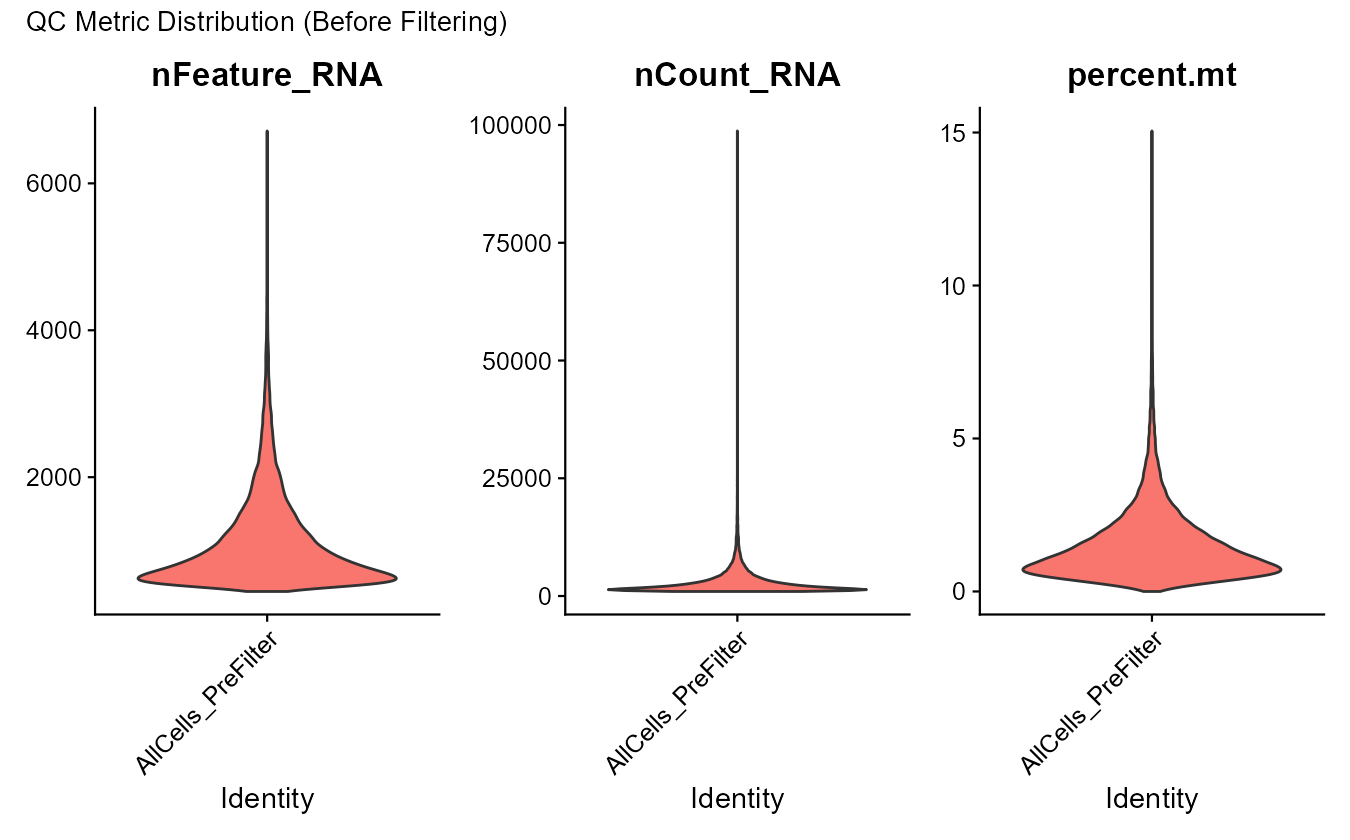

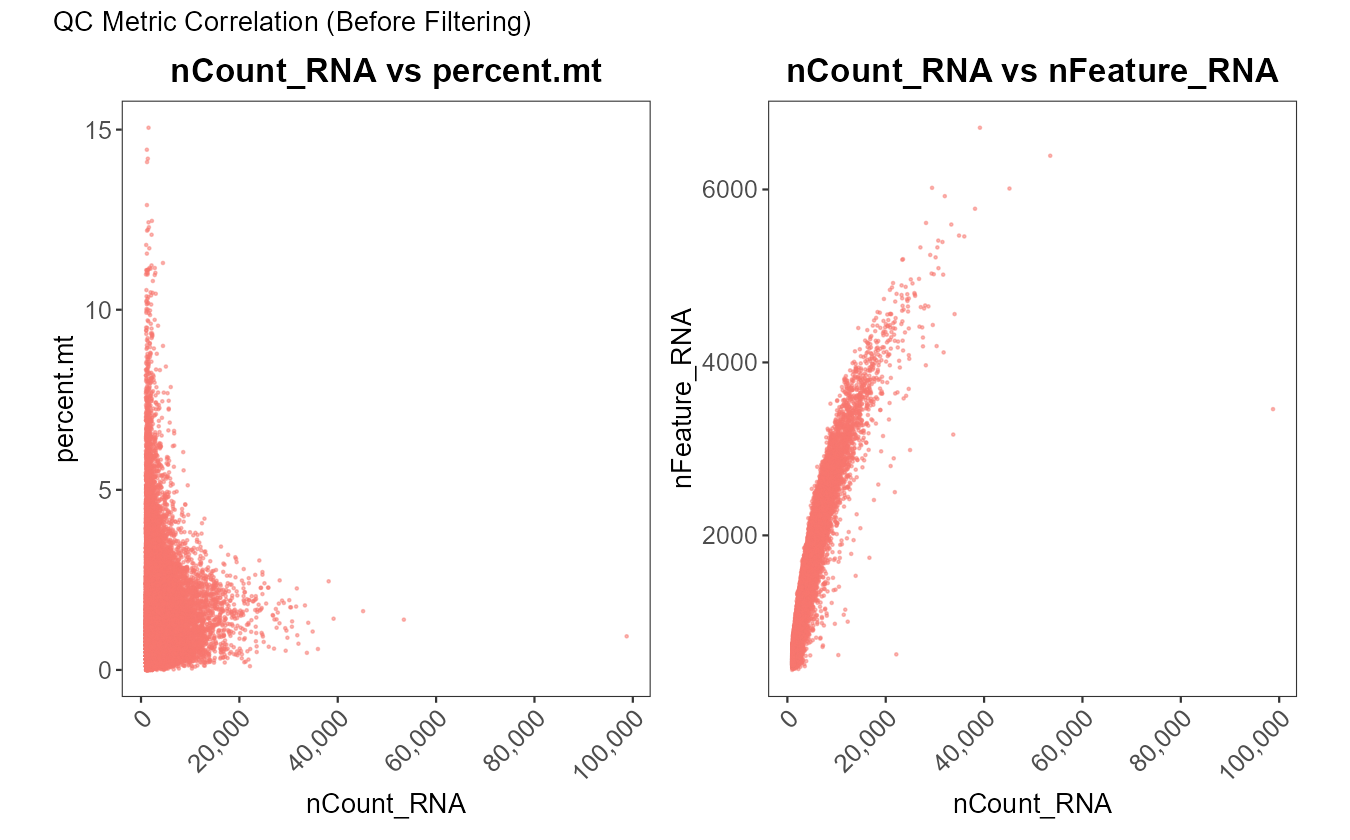

Filtering cells with (optimized thresholds): nFeature_RNA > 200 & nFeature_RNA < 5000 & percent.mt < 10

Filtering complete. Removed 69 cells. Remaining cells: 41021

Generating post-filtering QC plots on 'seu_filtered':



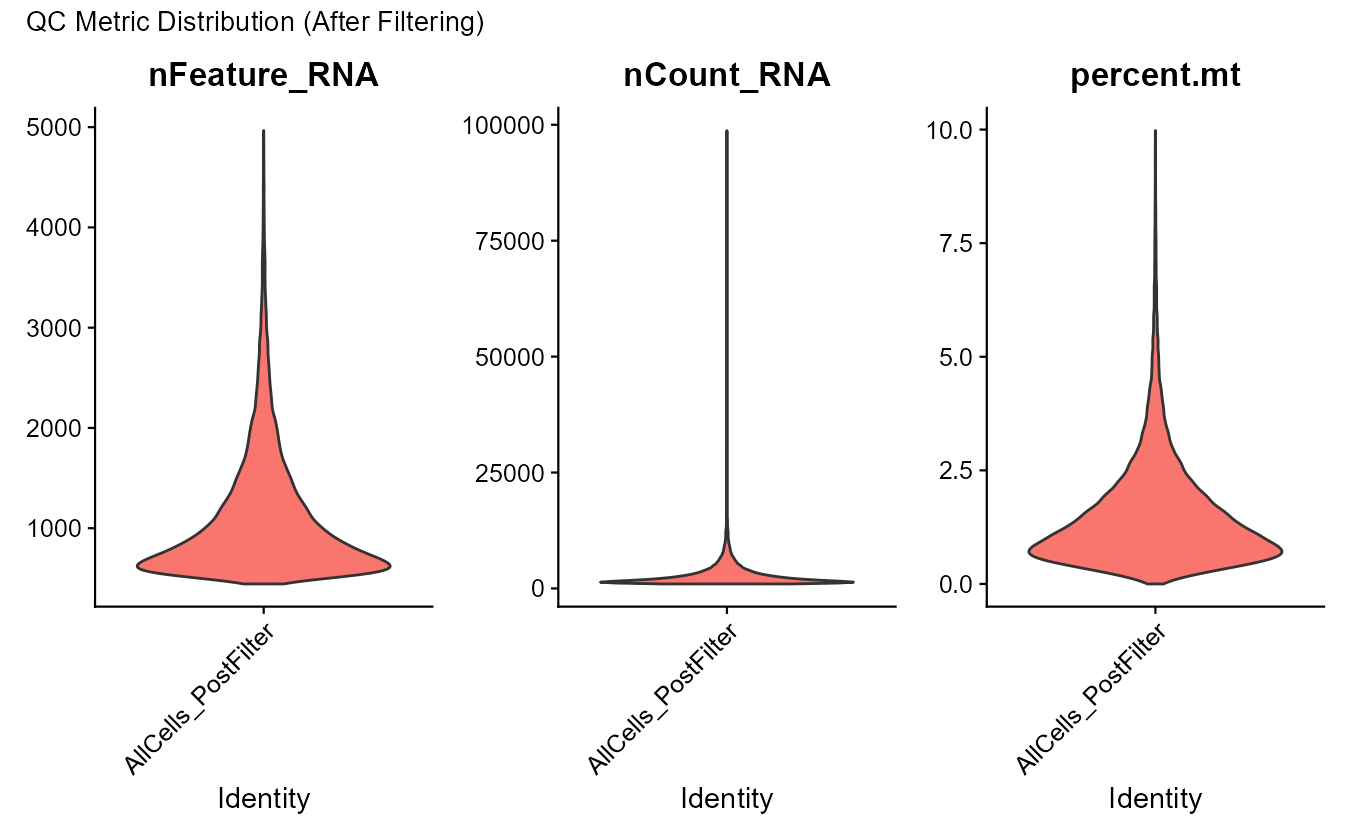

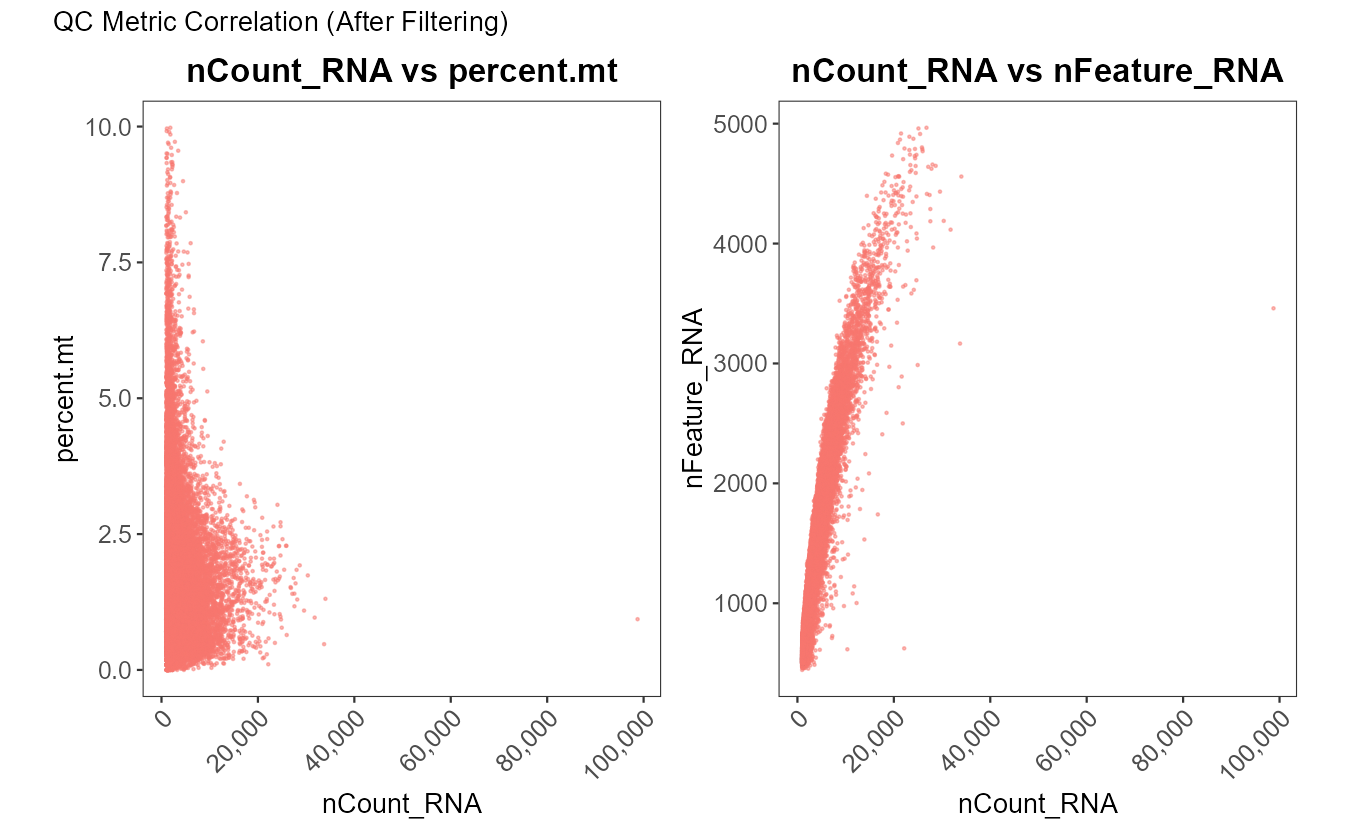

Normalizing data Started

NormalizeData complete

Finding highly variable features Started

Saving and Displaying feature plot



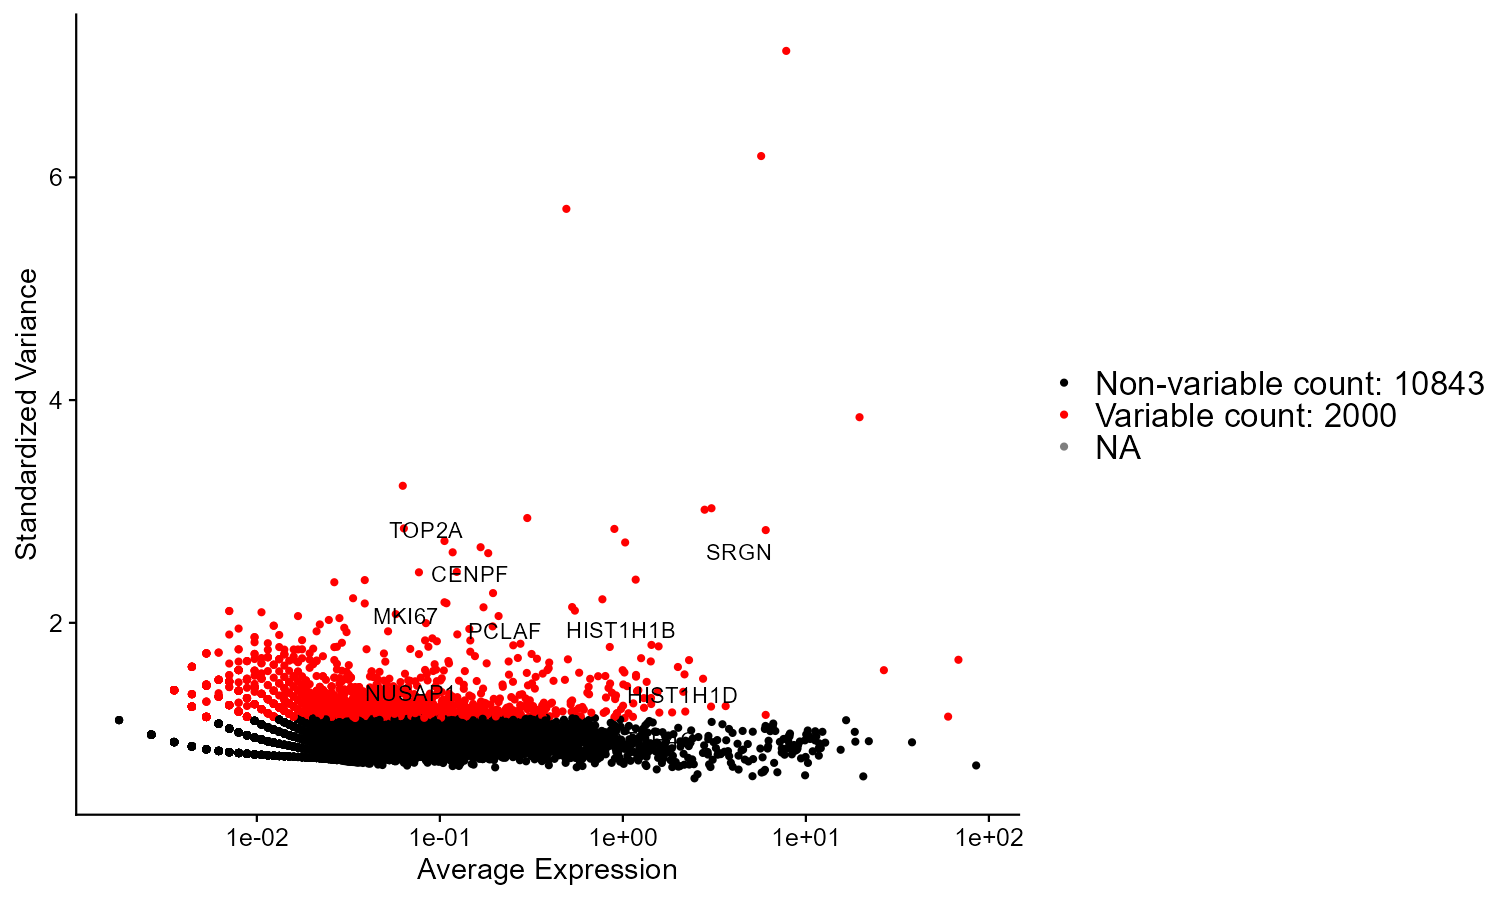

Pre-processed Seurat object saved to: C:/Users/b1795/Desktop/AML_OCT_v2/results/seu_preprocessed.rds

Pre-processing (QC, Filtering, Normalization) Finished



In [7]:
# 1. Prepare Seurat object
# Directly use the 'seu_merged' object generated in memory from the previous step
message("Seurat object 'seu_merged' is ready for pre-processing")
message("Pre-processing (QC, Filtering, Normalization) Started")

# Set random seed
set.seed(123)

# 2. QC metrics visualization (before filtering)
message("Generating pre-filtering QC plots on 'seu_merged': ")

# Plot violin plots to show the three core QC metrics before filtering
seu_merged$qc_group <- "AllCells_PreFilter"  # Unified grouping (before filtering)
vln_before <- VlnPlot(
        seu_merged, 
        features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), 
        group.by = "qc_group", 
        layer = "counts", 
        ncol = 3, 
        pt.size = 0 
)

# Plot scatter plot to check for abnormal cell populations
# Scatter plot 1: nCount_RNA vs percent.mt
df_sc1 <- SeuratObject::FetchData(
        seu_merged,
        vars = c("nCount_RNA", "percent.mt", "qc_group"),
        layer = "counts"     
)

scatter1 <- ggplot(df_sc1, aes(x = nCount_RNA, y = percent.mt, color = qc_group)) +
        geom_point(alpha = 0.5, size = 0.4) +
        theme_bw() +
        guides(color = "none") +
        theme(
                axis.text.x = element_text(size = 12, angle = 45, hjust = 1), # Tilt X-axis labels
                axis.text.y = element_text(size = 12),
                axis.title = element_text(size = 13),
                plot.title = element_text(size = 16, hjust = 0.5, face = "bold"),
                plot.title.position = "panel",
                plot.margin = margin(5, 5, 5, 20), 
                panel.grid = element_blank(),
        ) +
        scale_x_continuous(labels = scales::comma, breaks = scales::pretty_breaks(n = 5)) + 
        labs(title = "nCount_RNA vs percent.mt")

# Scatter plot 2: nCount_RNA vs nFeature_RNA
df_sc2 <- SeuratObject::FetchData(
        seu_merged,
        vars = c("nCount_RNA", "nFeature_RNA", "qc_group"),
        layer = "counts"   
)

scatter2 <- ggplot(df_sc2, aes(x = nCount_RNA, y = nFeature_RNA, color = qc_group)) +
        geom_point(alpha = 0.5, size = 0.4) +
        theme_bw() +
        guides(color = "none") +
        theme(
                axis.text.x = element_text(size = 12, angle = 45, hjust = 1),
                axis.text.y = element_text(size = 12),
                axis.title = element_text(size = 13),
                plot.title = element_text(size = 16, hjust = 0.5, face = "bold"),
                plot.title.position = "panel",
                plot.margin = margin(5, 20, 5, 5), 
                panel.grid = element_blank(), 
        ) +
        scale_x_continuous(labels = scales::comma, breaks = scales::pretty_breaks(n = 5)) +
        labs(title = "nCount_RNA vs nFeature_RNA")

# Use patchwork to add titles (violin plots + scatter plots)
vln_before_with_title <- vln_before + patchwork::plot_annotation(title = "QC Metric Distribution (Before Filtering)")
scatter_plots_with_title <- (scatter1 + scatter2) +
        patchwork::plot_annotation(title = "QC Metric Correlation (Before Filtering)") +
        plot_layout(guides = "collect")
# Save output plots to specified path
show_plot(vln_before_with_title, "qc_vlnplot_before_filtering", width = 9, height = 5.6, dpi = 150)
show_plot(scatter_plots_with_title, "qc_scatter_plots", width = 9, height = 5.6, dpi = 150)


# 3.Cell filtering
# Set thresholds based on QC metrics to remove low-quality and doublet cells
qc_thresholds <- list(
        nFeature_low  = 200,
        nFeature_high = 5000,
        percent_mt    = 10
)

message(paste0("Filtering cells with (optimized thresholds): ",
                "nFeature_RNA > ", qc_thresholds$nFeature_low, " & ",
                "nFeature_RNA < ", qc_thresholds$nFeature_high, " & ",
                "percent.mt < ", qc_thresholds$percent_mt))

cells_before <- ncol(seu_merged)
seu_filtered <- subset(seu_merged, 
                                subset = nFeature_RNA > qc_thresholds$nFeature_low & 
                                nFeature_RNA < qc_thresholds$nFeature_high & 
                                percent.mt < qc_thresholds$percent_mt)
cells_after <- ncol(seu_filtered)

# Post-filter check to prevent over-filtering
stopifnot("All cells were filtered out. Please loosen the QC thresholds" = cells_after > 0)
message(paste("Filtering complete. Removed", cells_before - cells_after, "cells.",
                "Remaining cells:", cells_after))
seu_filtered@misc$qc_thresholds <- qc_thresholds # Store QC thresholds into Seurat object metadata for tracking

# 4. QC metrics visualization (after filtering)
message("Generating post-filtering QC plots on 'seu_filtered':")

# Plot violin plots to show core QC metrics after filtering
seu_filtered$qc_group <- "AllCells_PostFilter"   # Unified grouping (after filtering)
vln_after <- VlnPlot(
        seu_filtered,
        features = c("nFeature_RNA", "nCount_RNA", "percent.mt"),
        group.by = "qc_group",   # Same as before
        layer = "counts",        # Explicitly use the counts layer
        ncol = 3,
        pt.size = 0              # Hide points, only show distribution
)

# Plot scatter plot to check for abnormal cell populations
# Scatter plot 1: nCount_RNA vs percent.mt
df_sc1_post <- SeuratObject::FetchData(
        seu_filtered,
        vars  = c("nCount_RNA", "percent.mt", "qc_group"),
        layer = "counts"   
)

scatter1_post <- ggplot(df_sc1_post, aes(x = nCount_RNA, y = percent.mt, color = qc_group)) +
        geom_point(alpha = 0.5, size = 0.4) +
        theme_bw() + 
        guides(color = "none") +
        theme(
                axis.text.x = element_text(size = 12, angle = 45, hjust = 1),
                axis.text.y = element_text(size = 12),
                axis.title = element_text(size = 13),
                plot.title = element_text(size = 16, hjust = 0.5, face = "bold"),
                plot.title.position = "panel",
                plot.margin = margin(5, 5, 5, 20),
                panel.grid = element_blank(),
        ) +
        scale_x_continuous(labels = scales::comma, breaks = scales::pretty_breaks(n = 5)) +
        labs(title = "nCount_RNA vs percent.mt")

# Scatter plot 2: nCount_RNA vs nFeature_RNA
df_sc2_post <- SeuratObject::FetchData(
        seu_filtered,
        vars  = c("nCount_RNA", "nFeature_RNA", "qc_group"),
        layer = "counts"
)

scatter2_post <- ggplot(df_sc2_post, aes(x = nCount_RNA, y = nFeature_RNA, color = qc_group)) +
        geom_point(alpha = 0.5, size = 0.4) +
        theme_bw() +
        guides(color = "none") + 
        theme(
                axis.text.x = element_text(size = 12, angle = 45, hjust = 1),
                axis.text.y = element_text(size = 12),
                axis.title = element_text(size = 13),
                plot.title = element_text(size = 16, hjust = 0.5, face = "bold"),
                plot.title.position = "panel",
                plot.margin = margin(5, 20, 5, 5),
                panel.grid = element_blank(),
        ) +
        scale_x_continuous(labels = scales::comma, breaks = scales::pretty_breaks(n = 5)) +
        scale_color_discrete(drop = FALSE) +
        labs(title = "nCount_RNA vs nFeature_RNA")

# Use patchwork to add titles (violin plots + scatter plots)
vln_after_with_title <- vln_after + patchwork::plot_annotation(title = "QC Metric Distribution (After Filtering)")
scatter_after_with_title <- (scatter1_post + scatter2_post) +
        patchwork::plot_annotation(title = "QC Metric Correlation (After Filtering)") +
        plot_layout(guides = "collect")

# Save and export QC plots after filtering
show_plot(vln_after_with_title, "qc_vlnplot_after_filtering", width = 9, height = 5.6, dpi = 150)
show_plot(scatter_after_with_title, "qc_scatter_plots_after_filtering", width = 9, height = 5.6, dpi = 150)


# 4. Data normalization and feature selection
# 4.1 Normalize data using NormalizeData() function

# Switch computation mode
if (inherits(plan(), "multisession")) {
        message("Data object is large Returning to sequential plan")
        future::plan("sequential")
}
message("Normalizing data Started")
seu_processed <- NormalizeData(seu_filtered, verbose = FALSE) # Use verbose = FALSE to suppress output
message("NormalizeData complete")

# 4.1 Identify highly variable features using FindVariableFeatures() function
message("Finding highly variable features Started")
seu_processed <- FindVariableFeatures(seu_processed, selection.method = "vst", nfeatures = 2000, verbose = FALSE) 

# Visualize highly variable features
top10 <- head(VariableFeatures(seu_processed), 10) # Find top 10 variable genes
hvf_df <- as.data.frame(HVFInfo(seu_processed))
hvf_df$feature <- rownames(hvf_df)

# Plot variable feature variance
variable_plot <- VariableFeaturePlot(seu_processed) +
        theme(legend.title = element_text(size = 17),
                legend.text  = element_text(size = 16))
# Annotate top 10 variable genes with ggrepel
variable_plot_labeled <- variable_plot +
        ggrepel::geom_text_repel(
                data = subset(hvf_df, feature %in% top10),
                aes(x = mean, y = variance.standardized, label = feature),
                max.overlaps = Inf, box.padding = 0.4, point.padding = 0.2
        )

# Save and display feature plot
message("Saving and Displaying feature plot")
suppressWarnings(show_plot(variable_plot_labeled, "variable_feature_plot", width = 10, height = 6, dpi = 150))

# 5. Save final pre-processed Seurat object
#  The seu_processed object contains filtering, normalization, and HVG information,
#  And can be directly used for downstream dimensionality reduction and clustering
output_file_processed <- file.path(out_res, "seu_preprocessed.rds")
saveRDS(seu_processed, file = output_file_processed)
message("Pre-processed Seurat object saved to: ", output_file_processed)
message("Pre-processing (QC, Filtering, Normalization) Finished")

# **4. Dimensionality reduction and clustering**

Seurat object 'seu_preprocessed' is ready for Dimensionality Reduction & Clustering

Object dimensions (genes x cells): 19692 x 41021

Dimensionality Reduction & Clustering Started

Running Scaling the data

Running PCA for linear dimensionality reduction



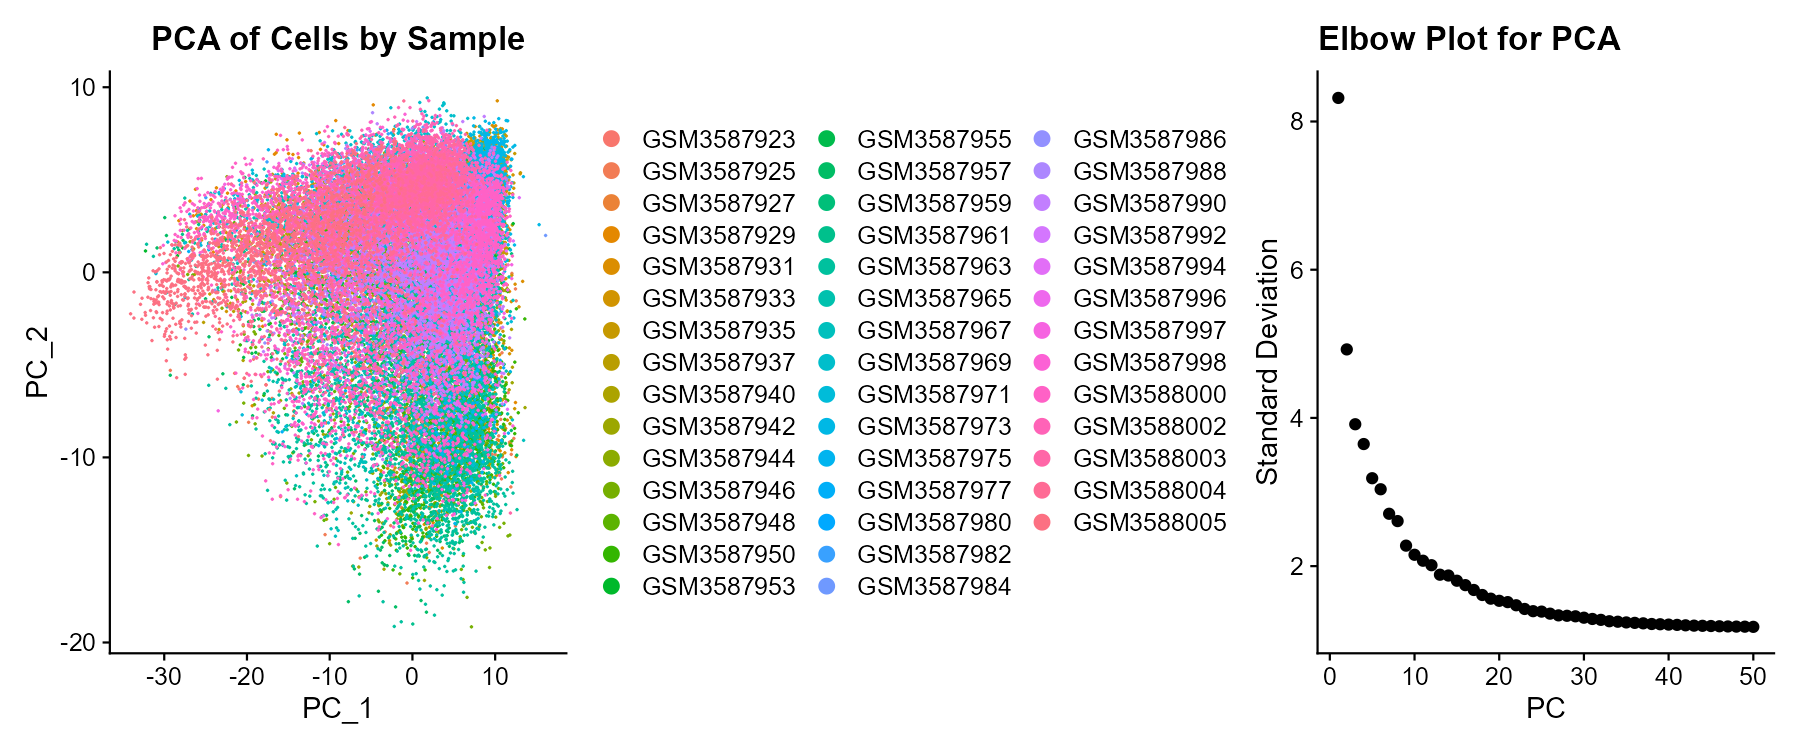

PCA complete. Elbow plot suggests which dimensions to use for clustering

Using dimensions 1 to 20 of PCA for downstream analysis

Finding neighbors Started (Generating SNN graph)

Running UMAP for non-linear dimensionality reduction

Running clustering with multiple resolutions (Grid Search)



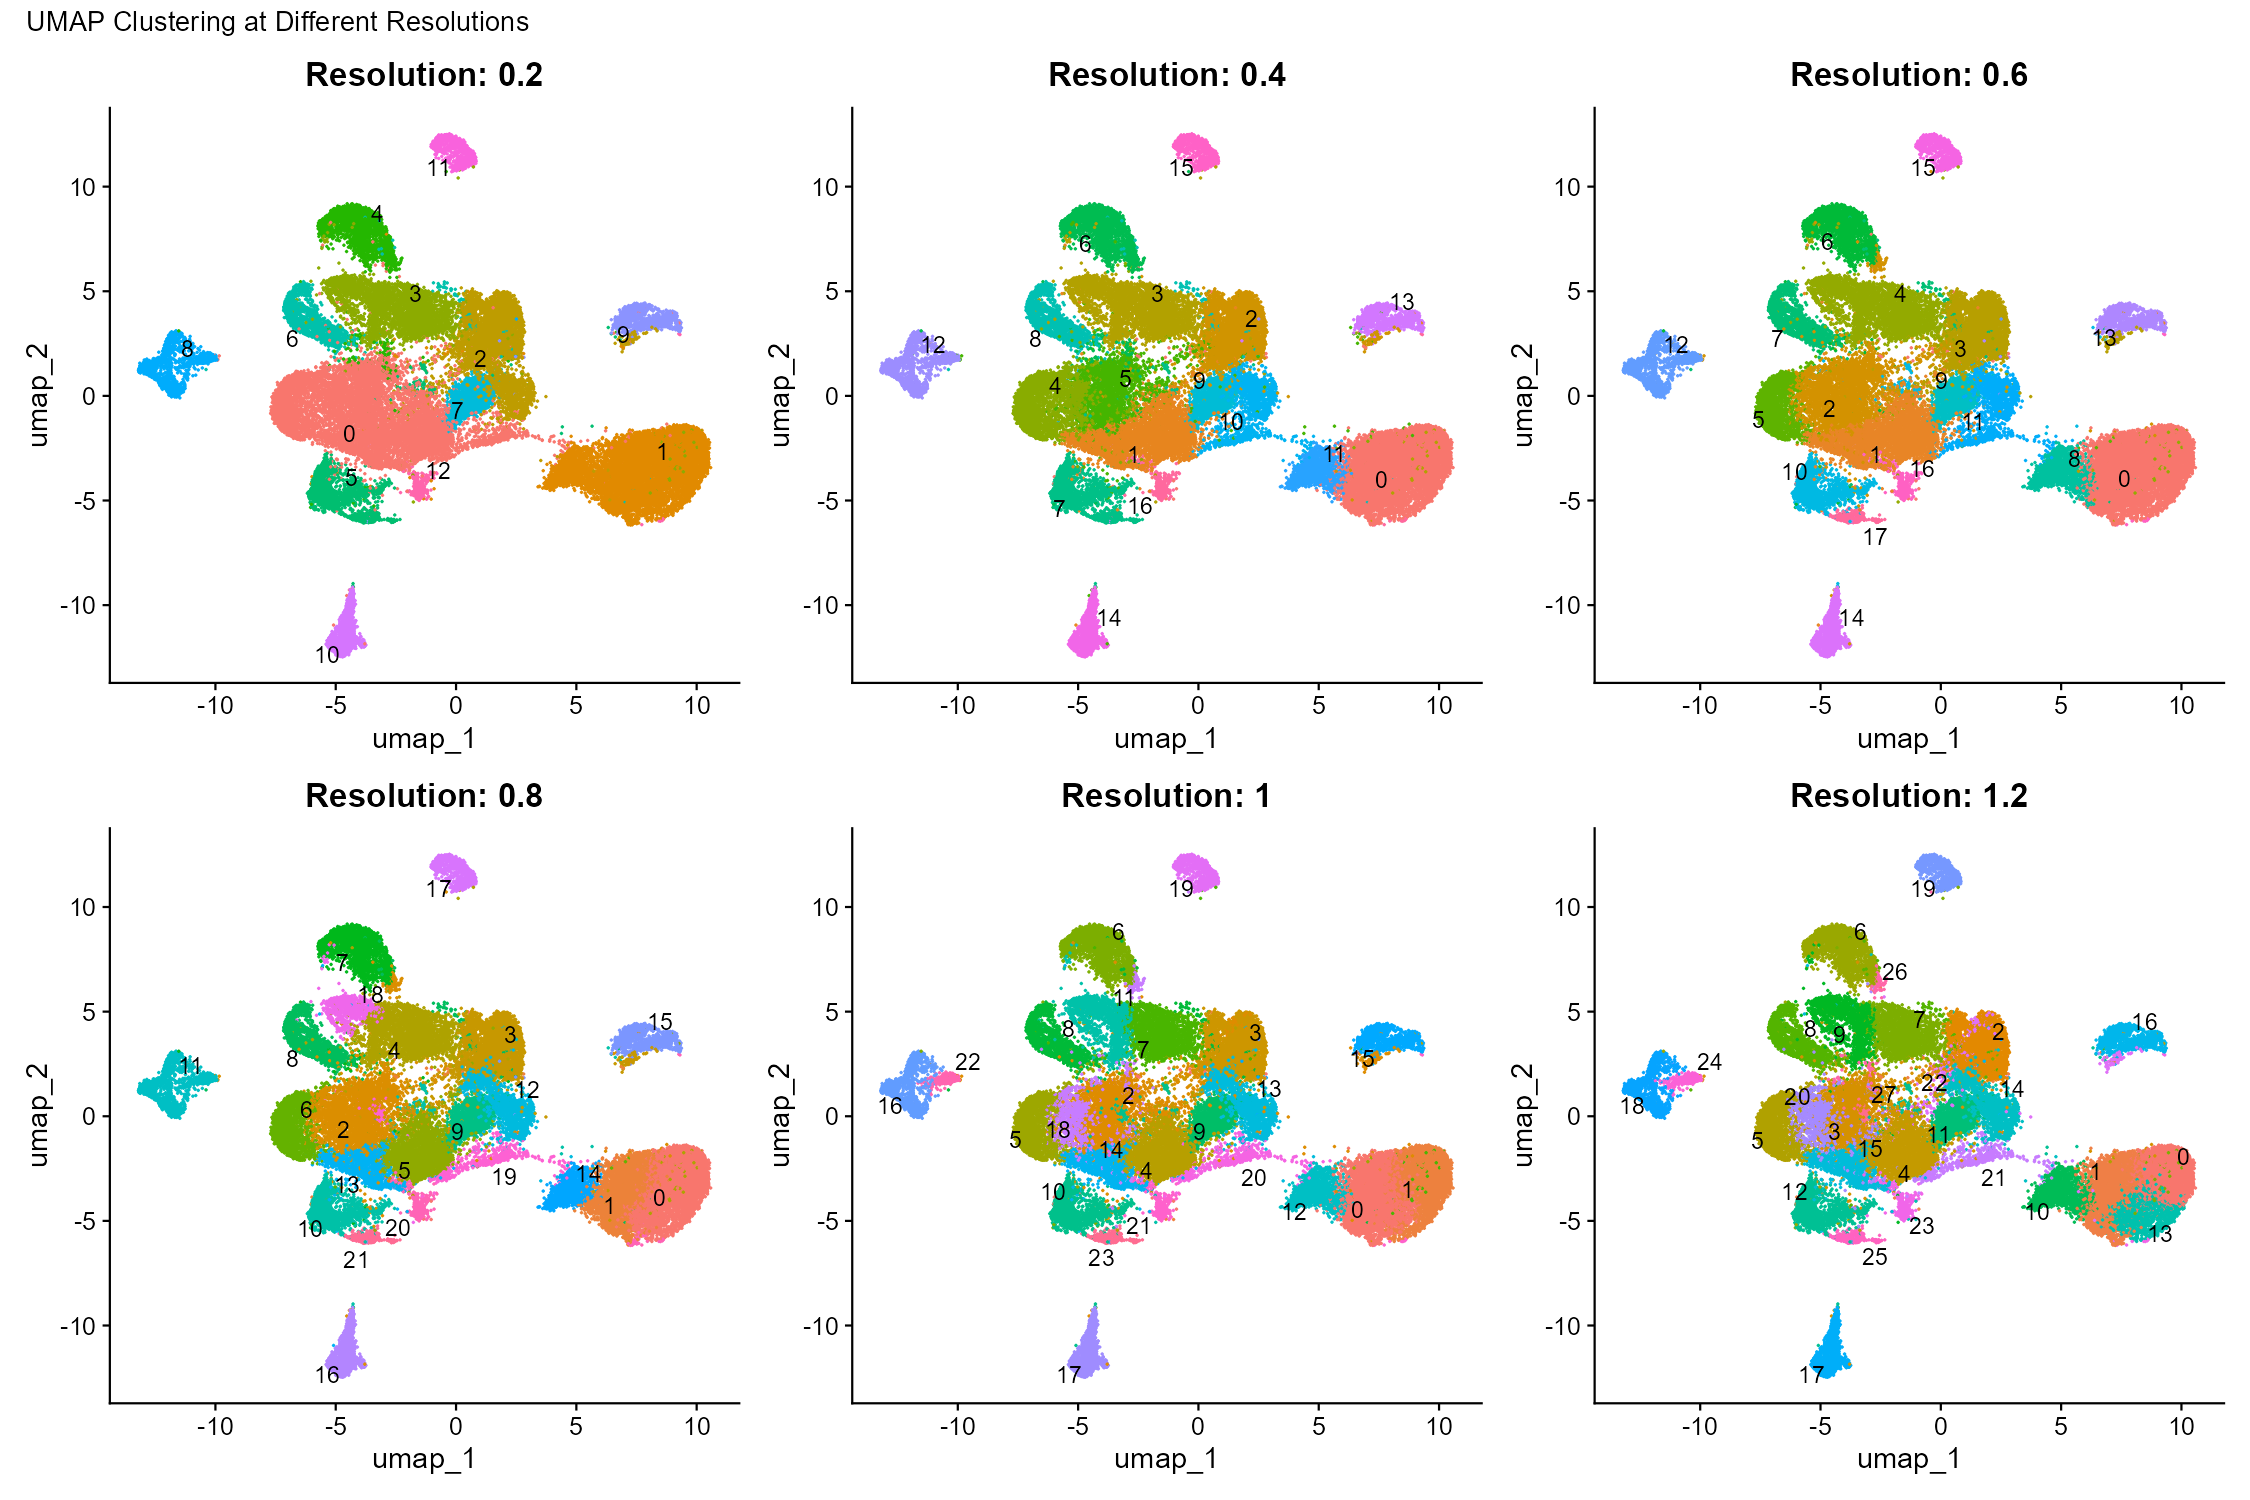

Grid search complete. A combined plot 'umap_clustering_resolutions' was saved

Setting default clustering identity to resolution 0.8



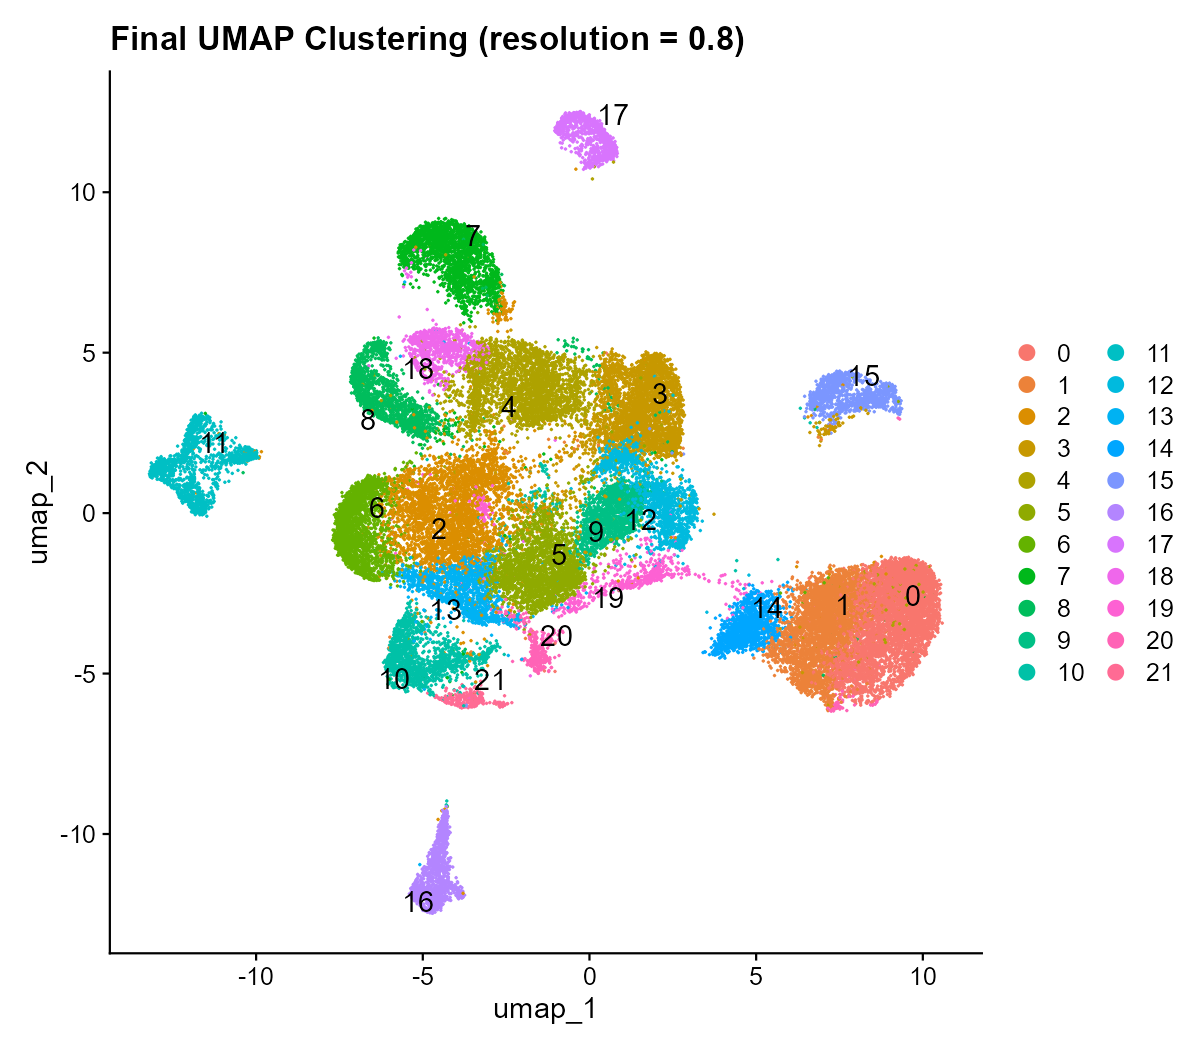

Generating table of cells per cluster (at final resolution):




   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
5150 3587 3563 3332 2762 2451 2236 2206 1621 1549 1518 1483 1389 1350 1322 1204 
  16   17   18   19   20   21 
1175  904  860  650  420  289 



Table generation complete

Starting final checks (Cluster size stats & Batch effect check)

Generating table of cluster sizes by resolution:

Cluster size table saved to results folder

Generating UMAPs colored by metadata to check for batch effects:



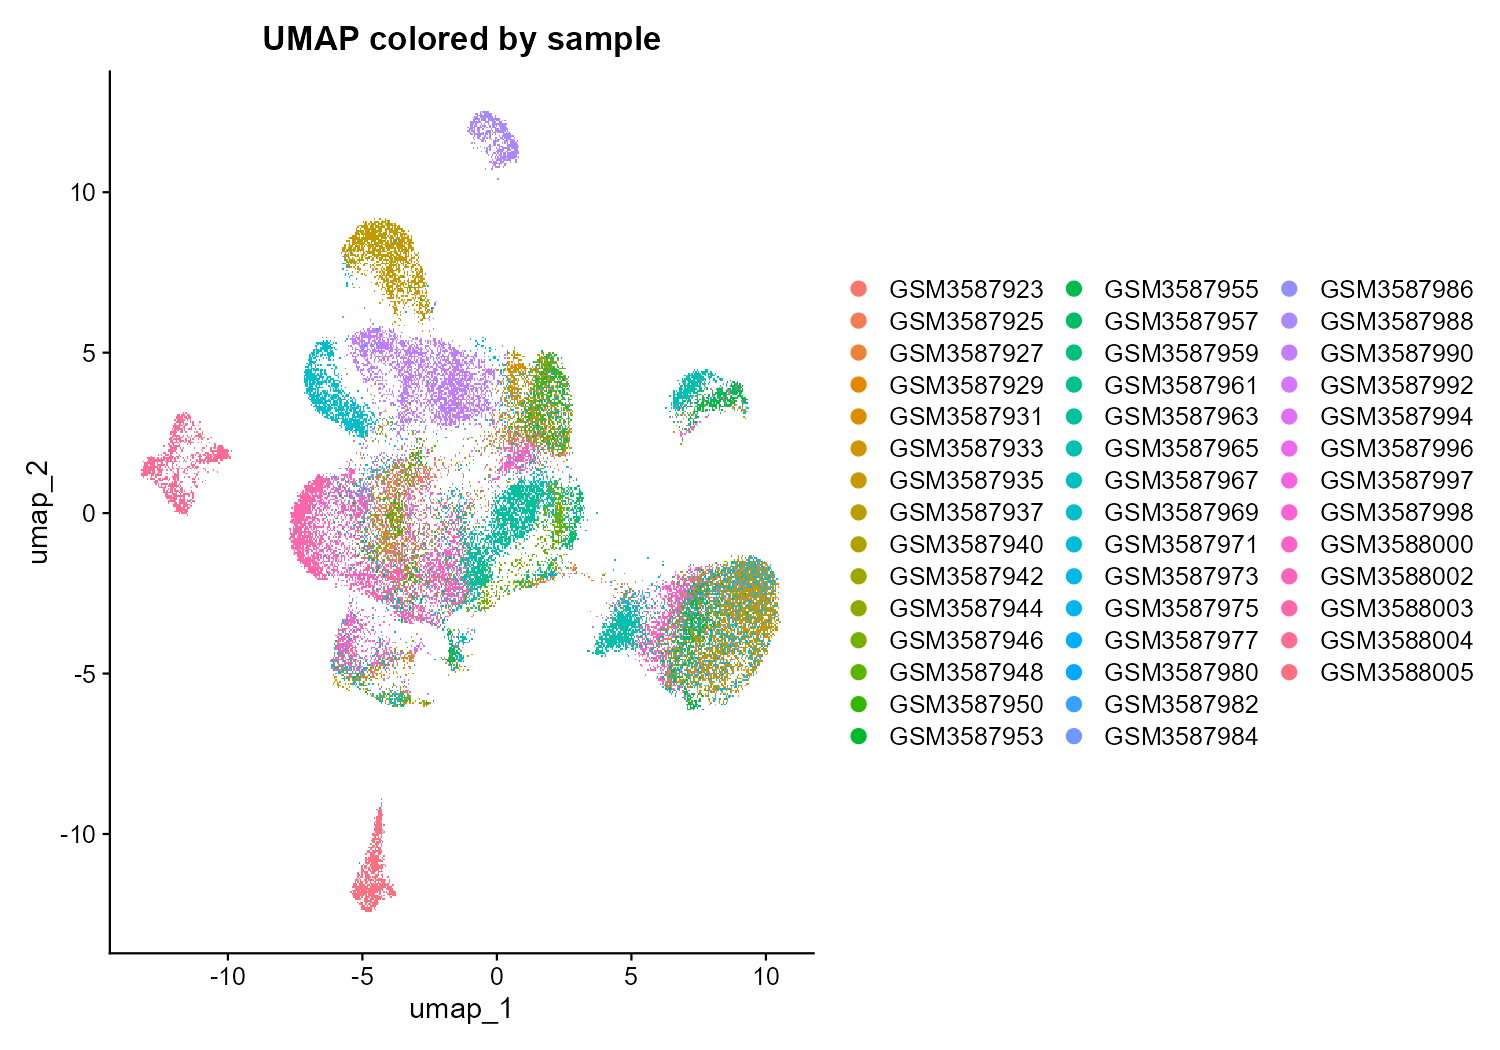

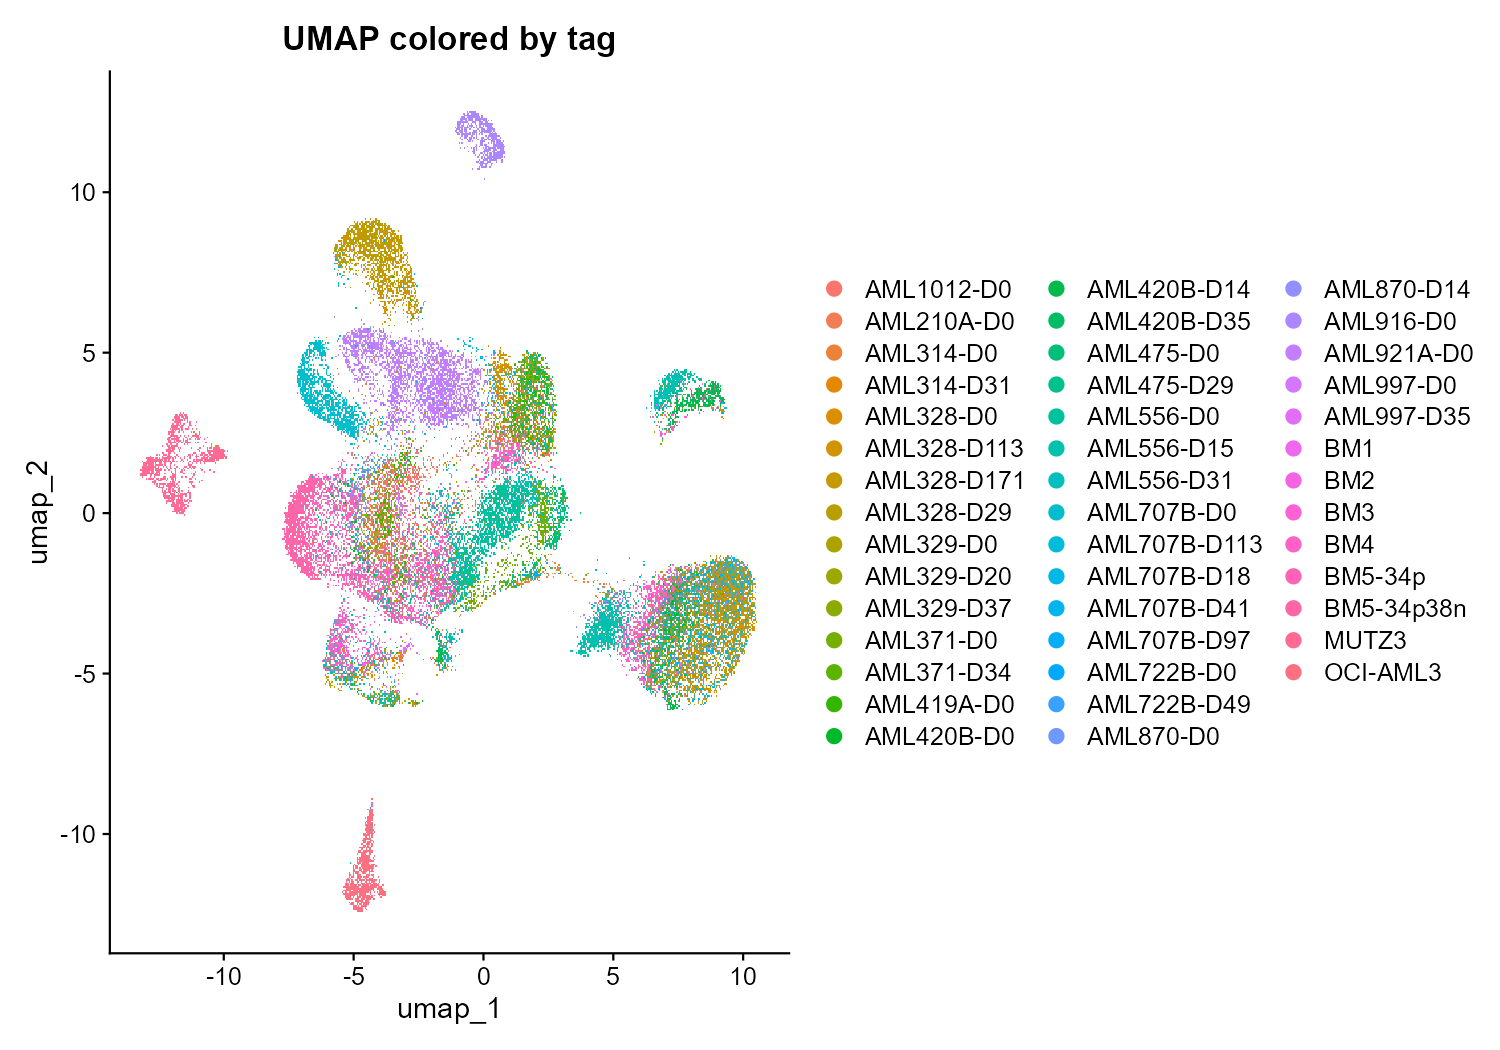

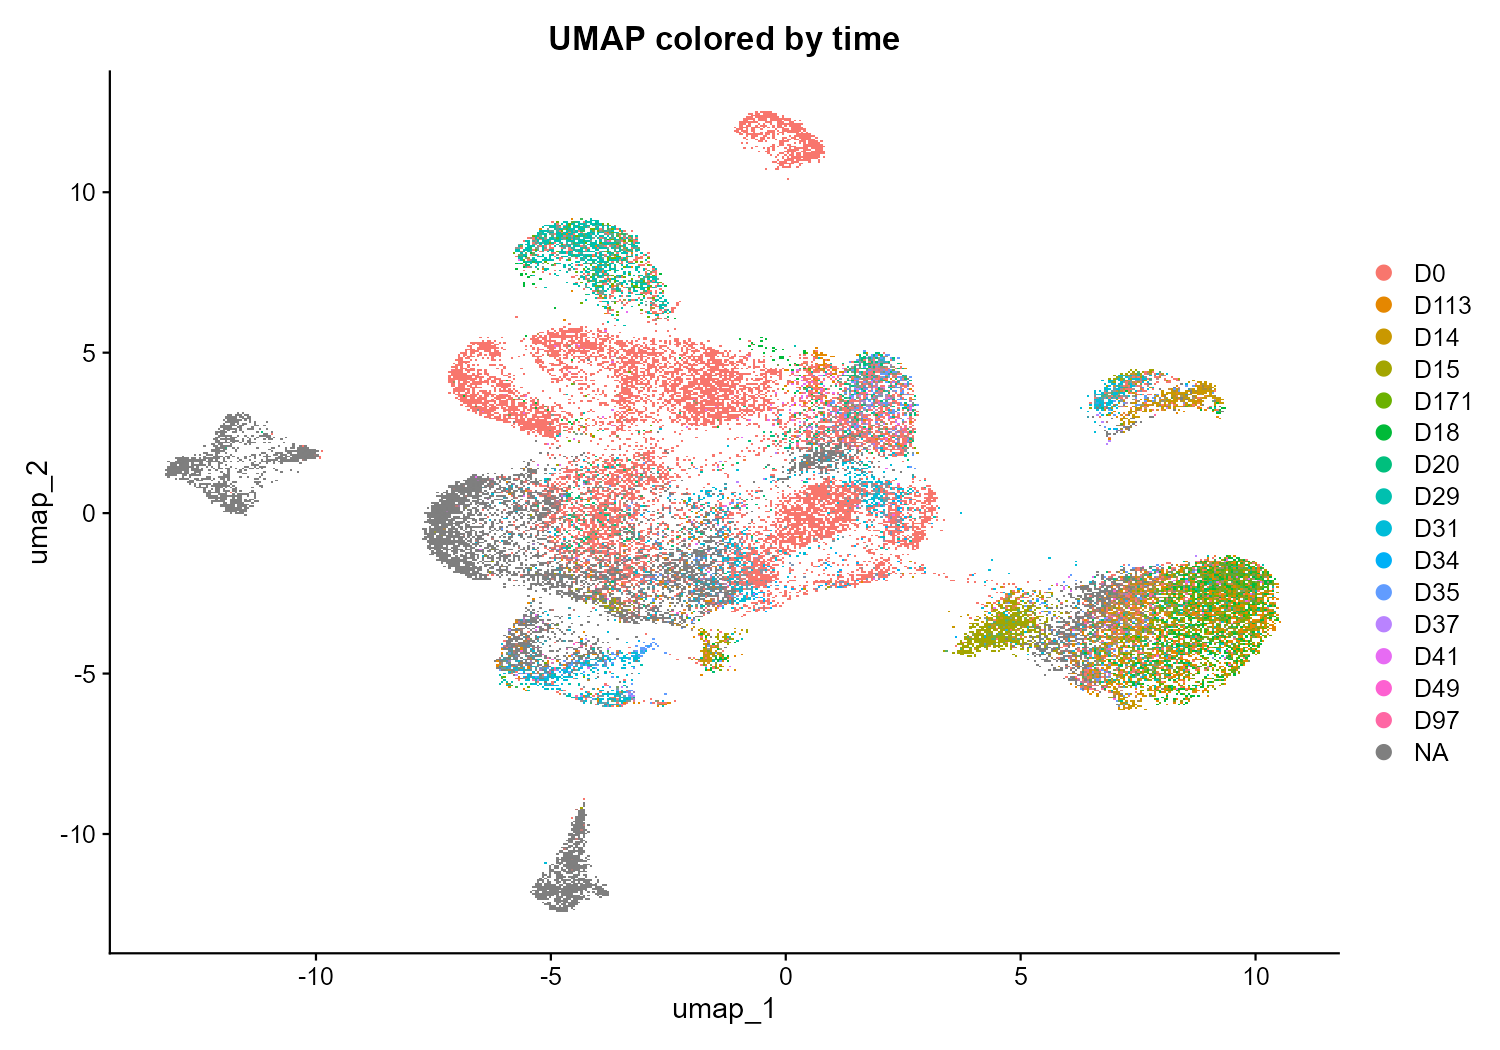

Metadata UMAP plots saved to figures folder

Dimensionality Reduction & Clustering Finished



In [8]:
# Set random seed
set.seed(123)

# 1. Load pre-processed file
seu_processed_path <- file.path(out_res, "seu_preprocessed.rds")
if (!file.exists(seu_processed_path)) {
    stop(sprintf("Pre-processed Seurat object not found at: %s", seu_processed_path))
}
seu_processed <- readRDS(seu_processed_path)
message("Seurat object 'seu_preprocessed' is ready for Dimensionality Reduction & Clustering")
message("Object dimensions (genes x cells): ", paste(dim(seu_processed), collapse = " x "))
message("Dimensionality Reduction & Clustering Started")

# 2. Scaling
message("Running Scaling the data")
# Only scale highly variable features
seu_processed <- ScaleData(seu_processed, features = VariableFeatures(object = seu_processed), verbose = FALSE)

# 3. Linear Dimensionality Reduction (PCA)
message("Running PCA for linear dimensionality reduction")
# Run PCA only on highly variable features
seu_processed <- RunPCA(seu_processed, features = VariableFeatures(object = seu_processed), verbose = FALSE)

# DimPlot Visualize PCA results
pca_plot <- DimPlot(seu_processed, reduction = "pca", group.by = "sample") +
    labs(title = "PCA of Cells by Sample")

# Elbow Plot to visualize optimal number of PCs
elbow_plot <- ElbowPlot(seu_processed, ndims = 50) +   # Visualize the first 50 PCs
    labs(title = "Elbow Plot for PCA")

# Combine PCA and Elbow plot
pca_viz_plots <- (pca_plot | elbow_plot)
show_plot(pca_viz_plots, "pca_and_elbow_plot", width = 12, height = 5, dpi = 150)

message("PCA complete. Elbow plot suggests which dimensions to use for clustering")

# Select top PCs based on Elbow Plot
dims_to_use <- 1:20
message(paste("Using dimensions 1 to", max(dims_to_use), "of PCA for downstream analysis"))

# 4. Build SNN graph
message("Finding neighbors Started (Generating SNN graph)")
seu_processed <- FindNeighbors(seu_processed, dims = dims_to_use, verbose = FALSE)

# 5. Non-linear dimensionality reduction
message("Running UMAP for non-linear dimensionality reduction")
seu_processed <- RunUMAP(
    seu_processed, 
    dims = dims_to_use,
    reduction = "pca",
    umap.method = "uwot",
    metric = "cosine",
    min.dist = 0.3,
    n.neighbors = 30,
    verbose = FALSE
)

# 6. Clustering
# 6.1 Clustering with multiple resolutions (Grid Search)
message("Running clustering with multiple resolutions (Grid Search)")
res_grid <- c(0.2, 0.4, 0.6, 0.8, 1.0, 1.2)
seu_processed <- FindClusters(seu_processed, resolution = res_grid, verbose = FALSE)

# Visualize UMAPs under different resolutions
umap_plots_list <- lapply(res_grid, function(res) {
    col_name <- paste0("RNA_snn_res.", res)
    DimPlot(
        seu_processed, reduction = "umap", 
        group.by = col_name, label = TRUE, repel = TRUE
    ) +
    NoLegend() +
    labs(title = paste0("Resolution: ", res))
})

# Combine UMAPs using patchwork
combined_umap_plot <- patchwork::wrap_plots(umap_plots_list, ncol = 3) +
    plot_annotation(title = "UMAP Clustering at Different Resolutions")

show_plot(combined_umap_plot, "umap_clustering_resolutions", width = 15, height = 10, dpi = 150)
message("Grid search complete. A combined plot 'umap_clustering_resolutions' was saved")

# 6.2 Select final clustering resolution
final_resolution <- 0.8
message(paste("Setting default clustering identity to resolution", final_resolution))
Idents(seu_processed) <- paste0("RNA_snn_res.", final_resolution)

# Copy the final clustering resolution result to the 'seurat_clusters' column
seu_processed$seurat_clusters <- Idents(seu_processed)

# Final UMAP clustering result
final_umap_plot <- DimPlot(
    seu_processed, reduction = "umap",
    label = TRUE, label.size = 5, repel = TRUE
) + labs(title = paste0("Final UMAP Clustering (resolution = ", final_resolution, ")"))

show_plot(final_umap_plot, "umap_clustering_final", width = 8, height = 7, dpi = 150)

# Check cluster table
message("Generating table of cells per cluster (at final resolution):")
print(table(seu_processed$seurat_clusters))
message("\nTable generation complete")
# 7. Final checks
message("Starting final checks (Cluster size stats & Batch effect check)")

# 7.1 Cluster size statistics
message("Generating table of cluster sizes by resolution:")
cluster_size_list <- lapply(res_grid, function(res) {
    col_name <- paste0("RNA_snn_res.", res)
    # Use dplyr to compute cluster size
    dplyr::count(seu_processed@meta.data, !!sym(col_name)) %>%
    dplyr::mutate(resolution = res) %>%
    dplyr::rename(cluster = !!sym(col_name), n_cells = n)
})
# Combine all cluster size tables
cluster_sizes <- dplyr::bind_rows(cluster_size_list)

# Save to results folder
write.csv(cluster_sizes, file.path(out_res, "cluster_sizes_by_resolution.csv"), row.names = FALSE)
message("Cluster size table saved to results folder")

# 7.2 Check for batch effects
message("Generating UMAPs colored by metadata to check for batch effects:")
# Automatically search existing metadata columns for plotting
metadata_to_plot <- intersect(c("sample", "tag", "time"), colnames(seu_processed@meta.data))
for (cc in metadata_to_plot) {
    p <- DimPlot(seu_processed, reduction = "umap", group.by = cc, shuffle = TRUE, raster = TRUE) +
        labs(title = paste("UMAP colored by", cc))
        guides(color = guide_legend(ncol = 3, override.aes = list(size = 3))) # multiple legend columns, clearer dots
    show_plot(p, paste0("umap_by_", cc), width = 10, height = 7, dpi = 150)
}
message("Metadata UMAP plots saved to figures folder")

# 8. Save clustered Seurat object
output_file_clustered <- file.path(out_res, "seu_clustered.rds")
saveRDS(seu_processed, file = output_file_clustered)
#message("Clustered Seurat object saved to: ", output_file_clustered)
message("Dimensionality Reduction & Clustering Finished")

# **5. Cell type annotation**

Seurat object 'seu_clustered' is ready for Cell Type Annotation

Cell Type Annotation Started

Finding markers for all clusters Started

Active assay RNA has multiple layers. Joining them for DE analysis

Using 2000 highly variable features for DE analysis

All markers saved to: C:/Users/b1795/Desktop/AML_OCT_v2/results/all_cluster_markers.csv

Generating pheatmap for Top3 markers:



agg_record_1298243940 
                    2

agg_record_1298243940 
                    2

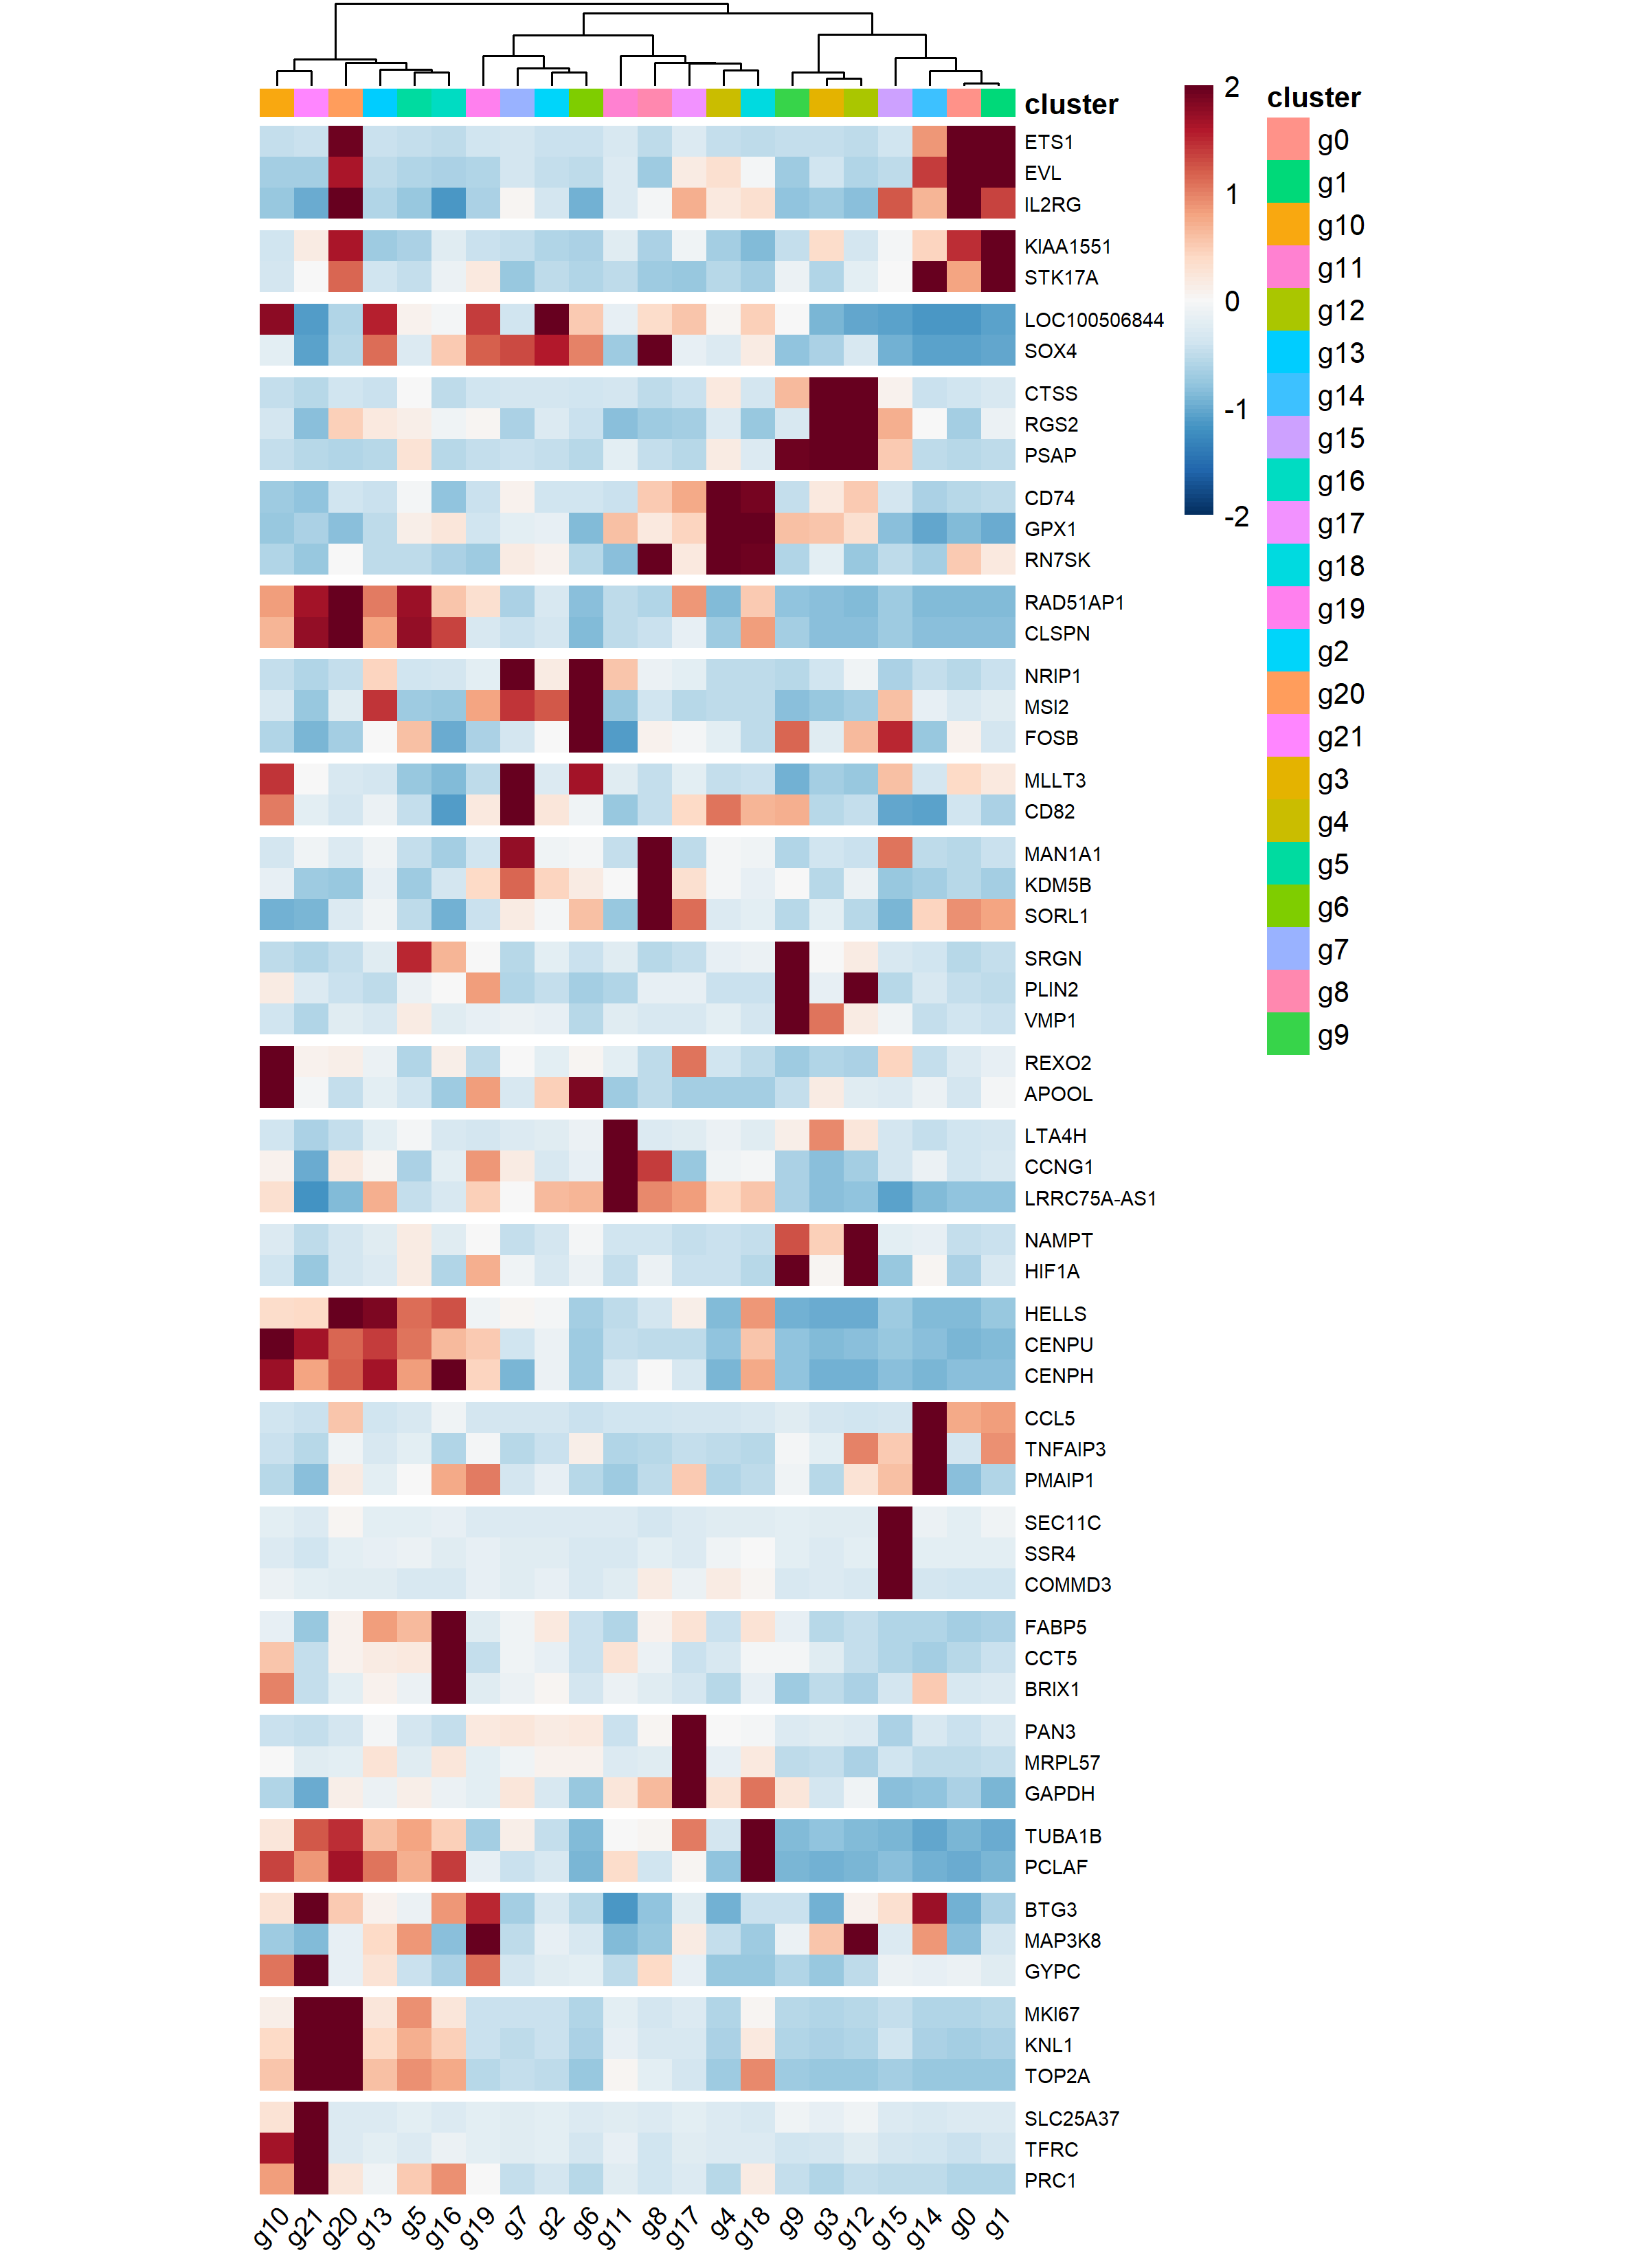

Top3 markers heatmap (by cluster) saved to: C:/Users/b1795/Desktop/AML_OCT_v2/figures/Heatmap_Top3_by_Cluster.pdf and C:/Users/b1795/Desktop/AML_OCT_v2/figures/Heatmap_Top3_by_Cluster.png

Visualizing canonical markers to guide annotation

Generating FeaturePlots for canonical markers:



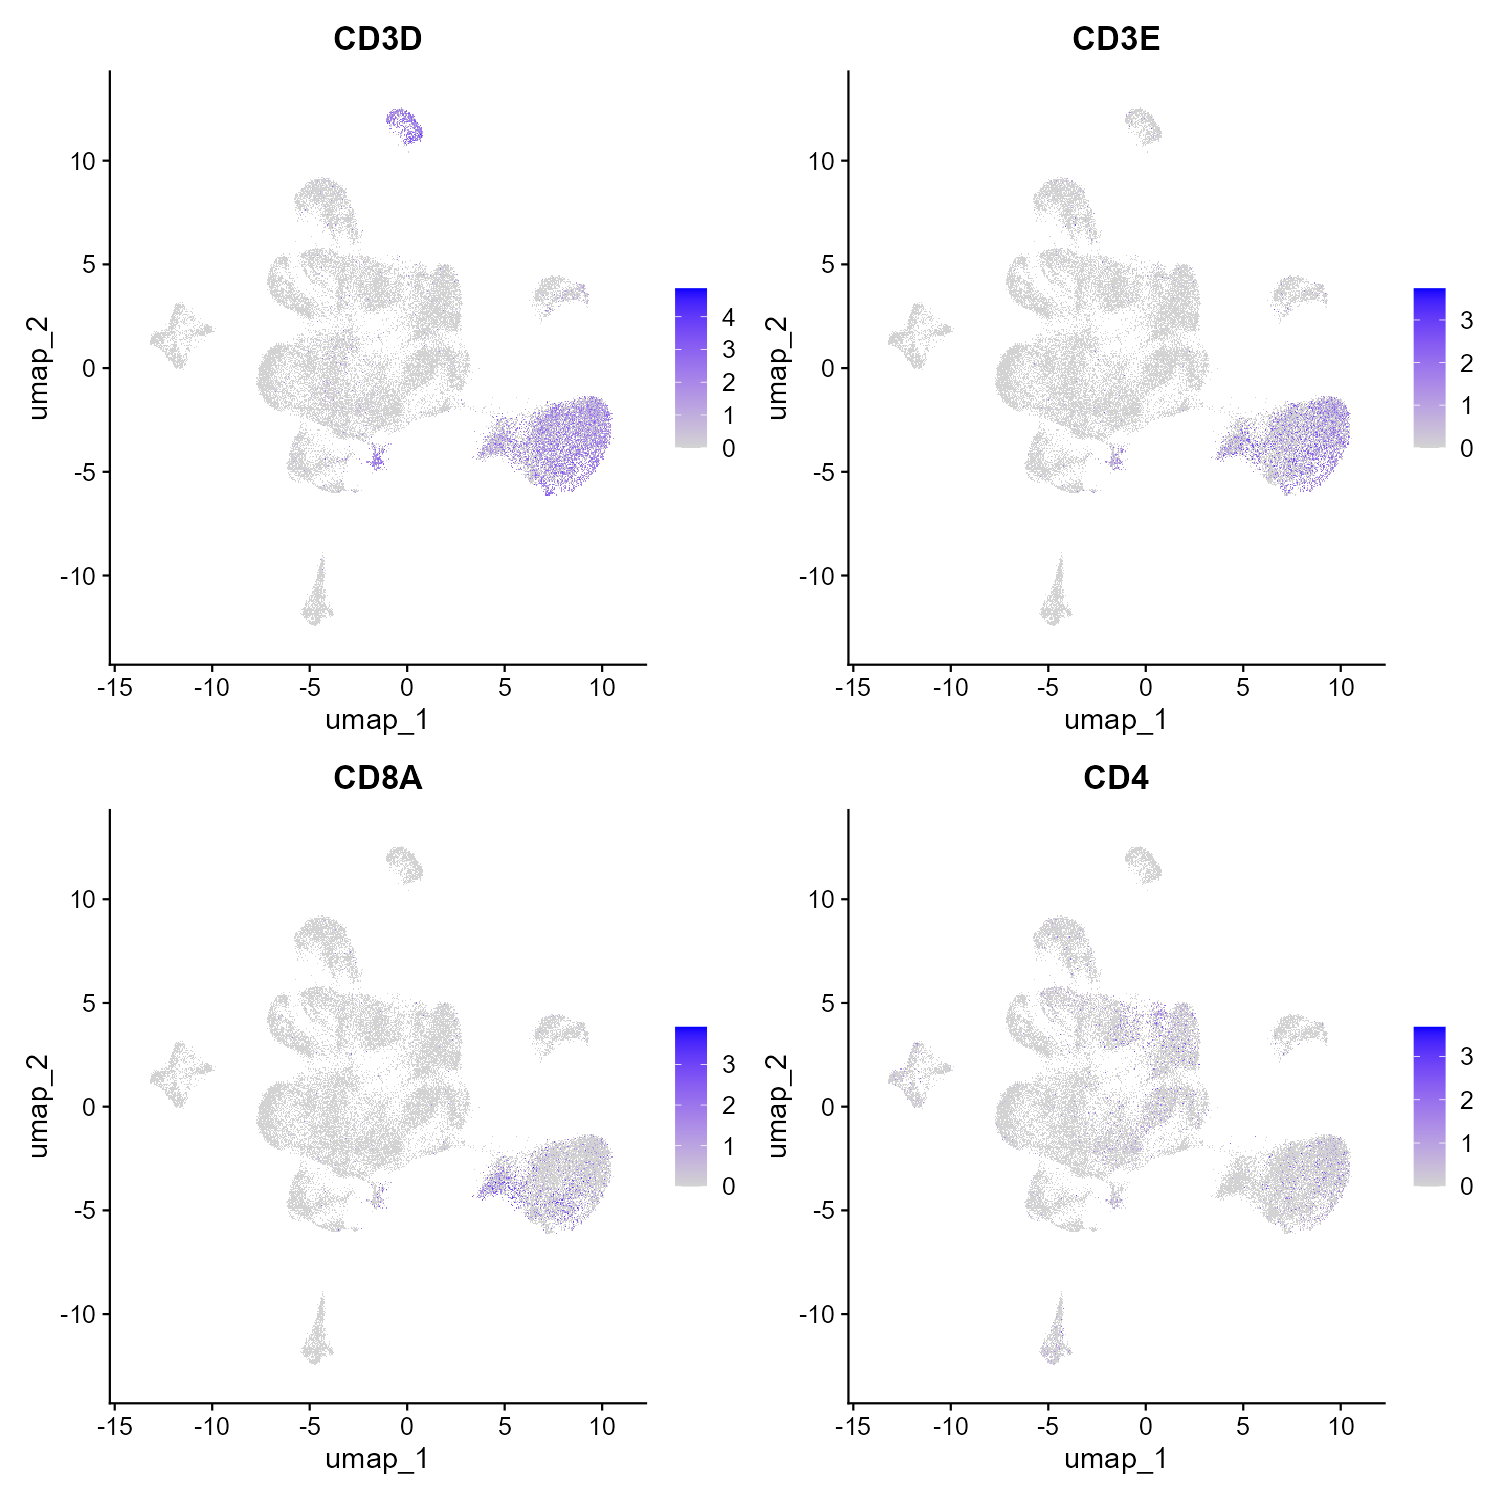

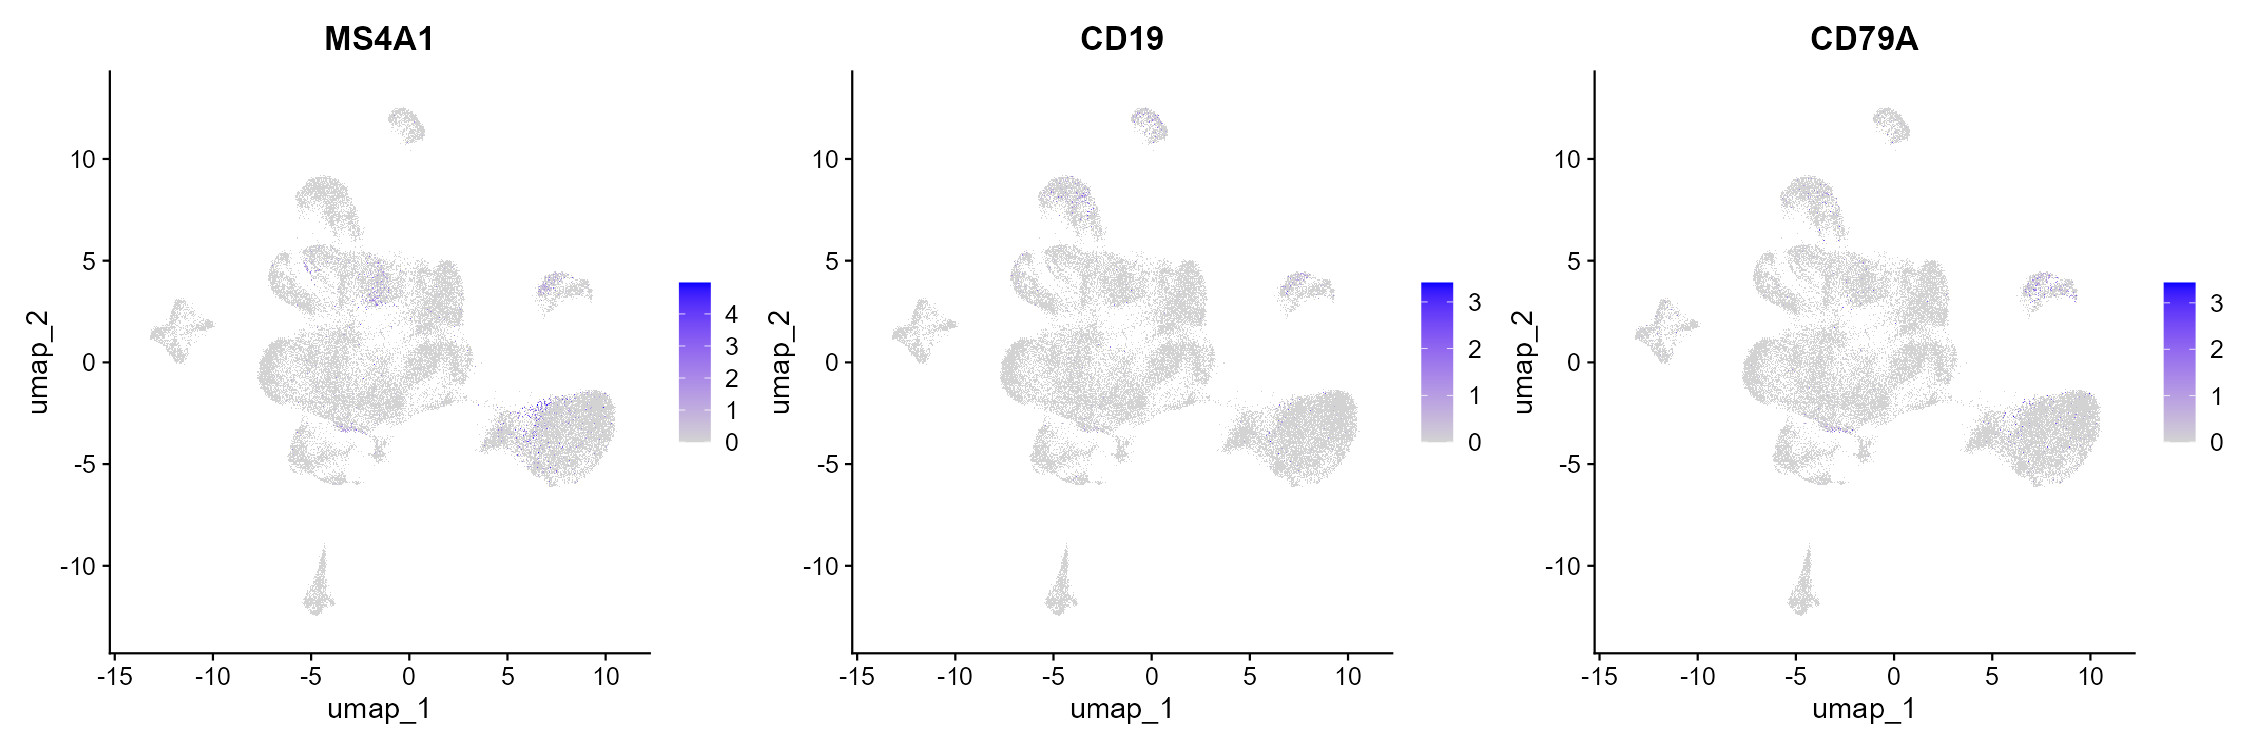

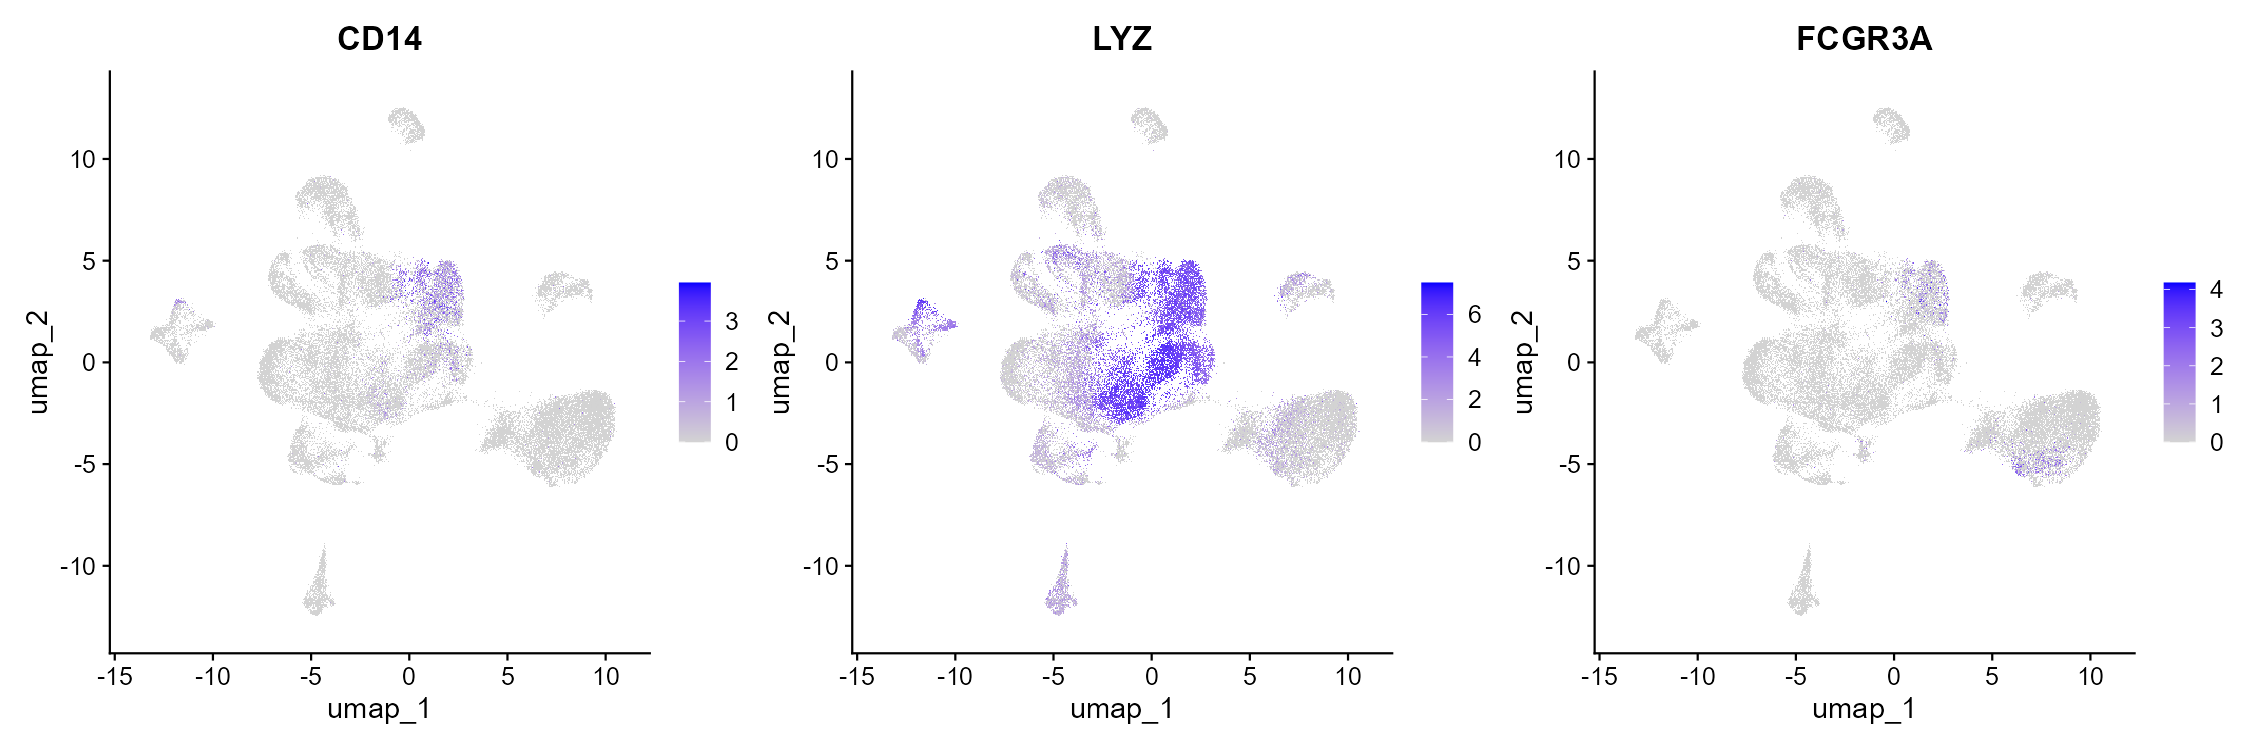

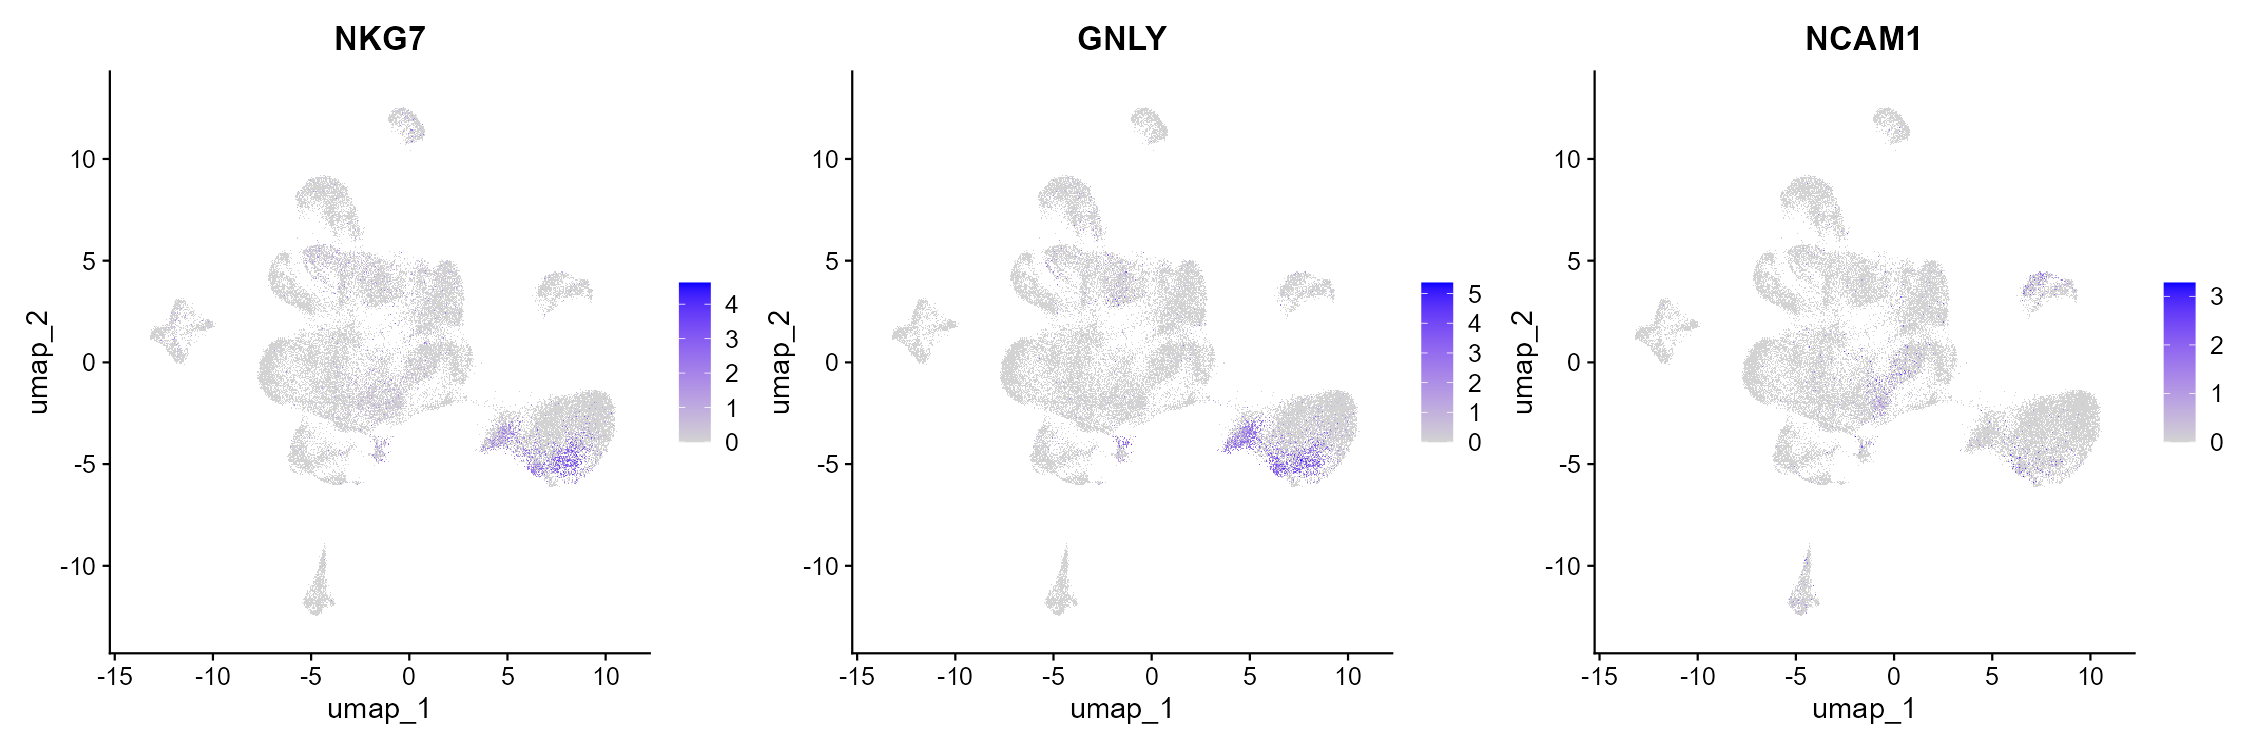

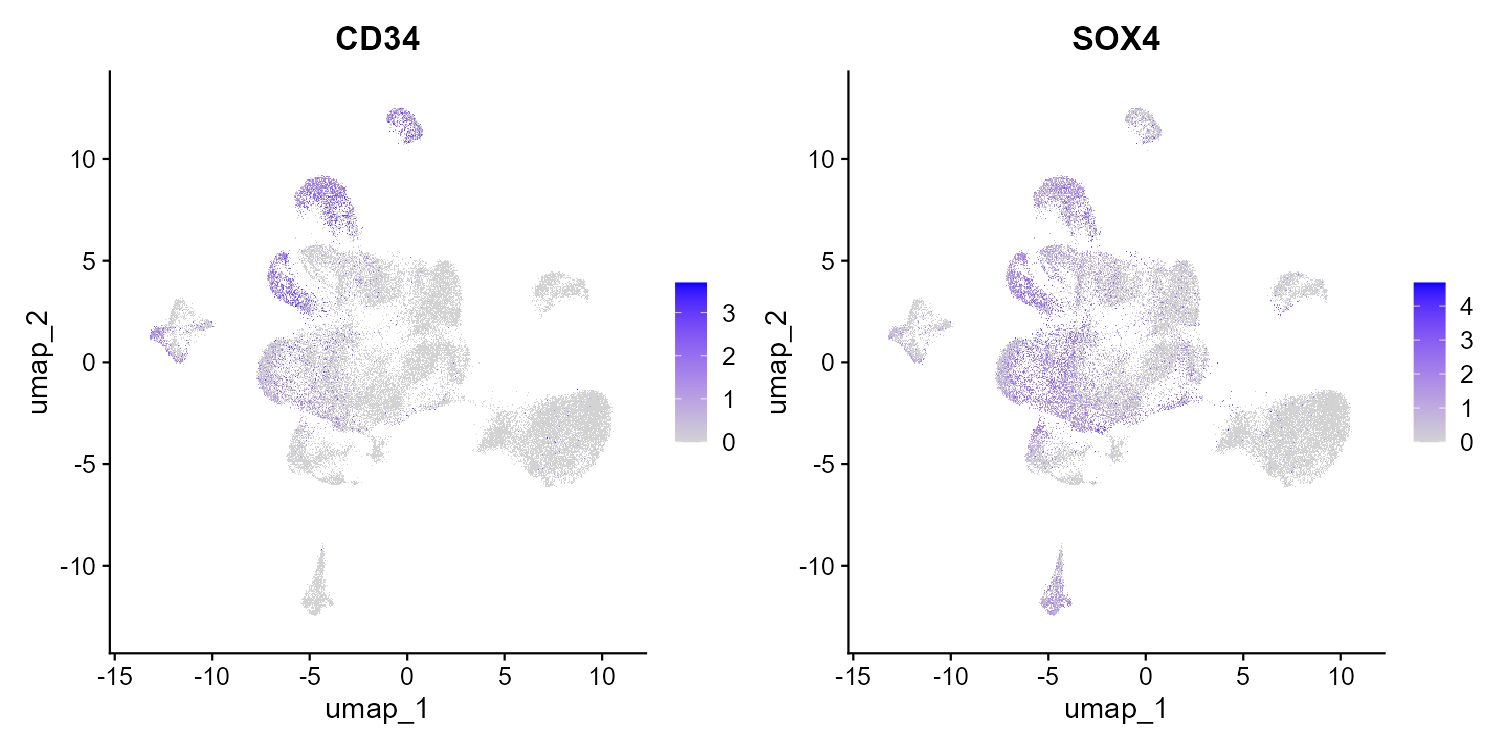

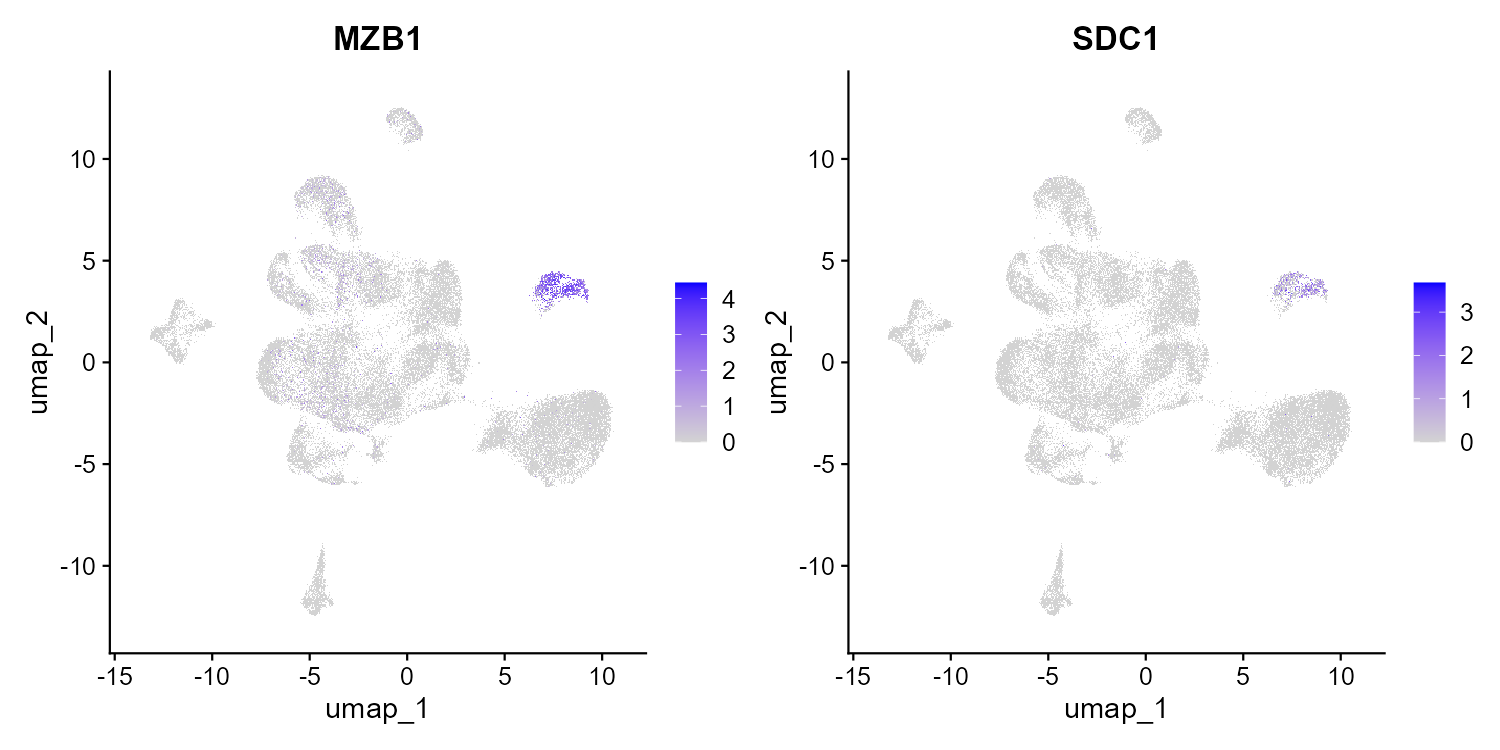

Generating VlnPlot for canonical markers:



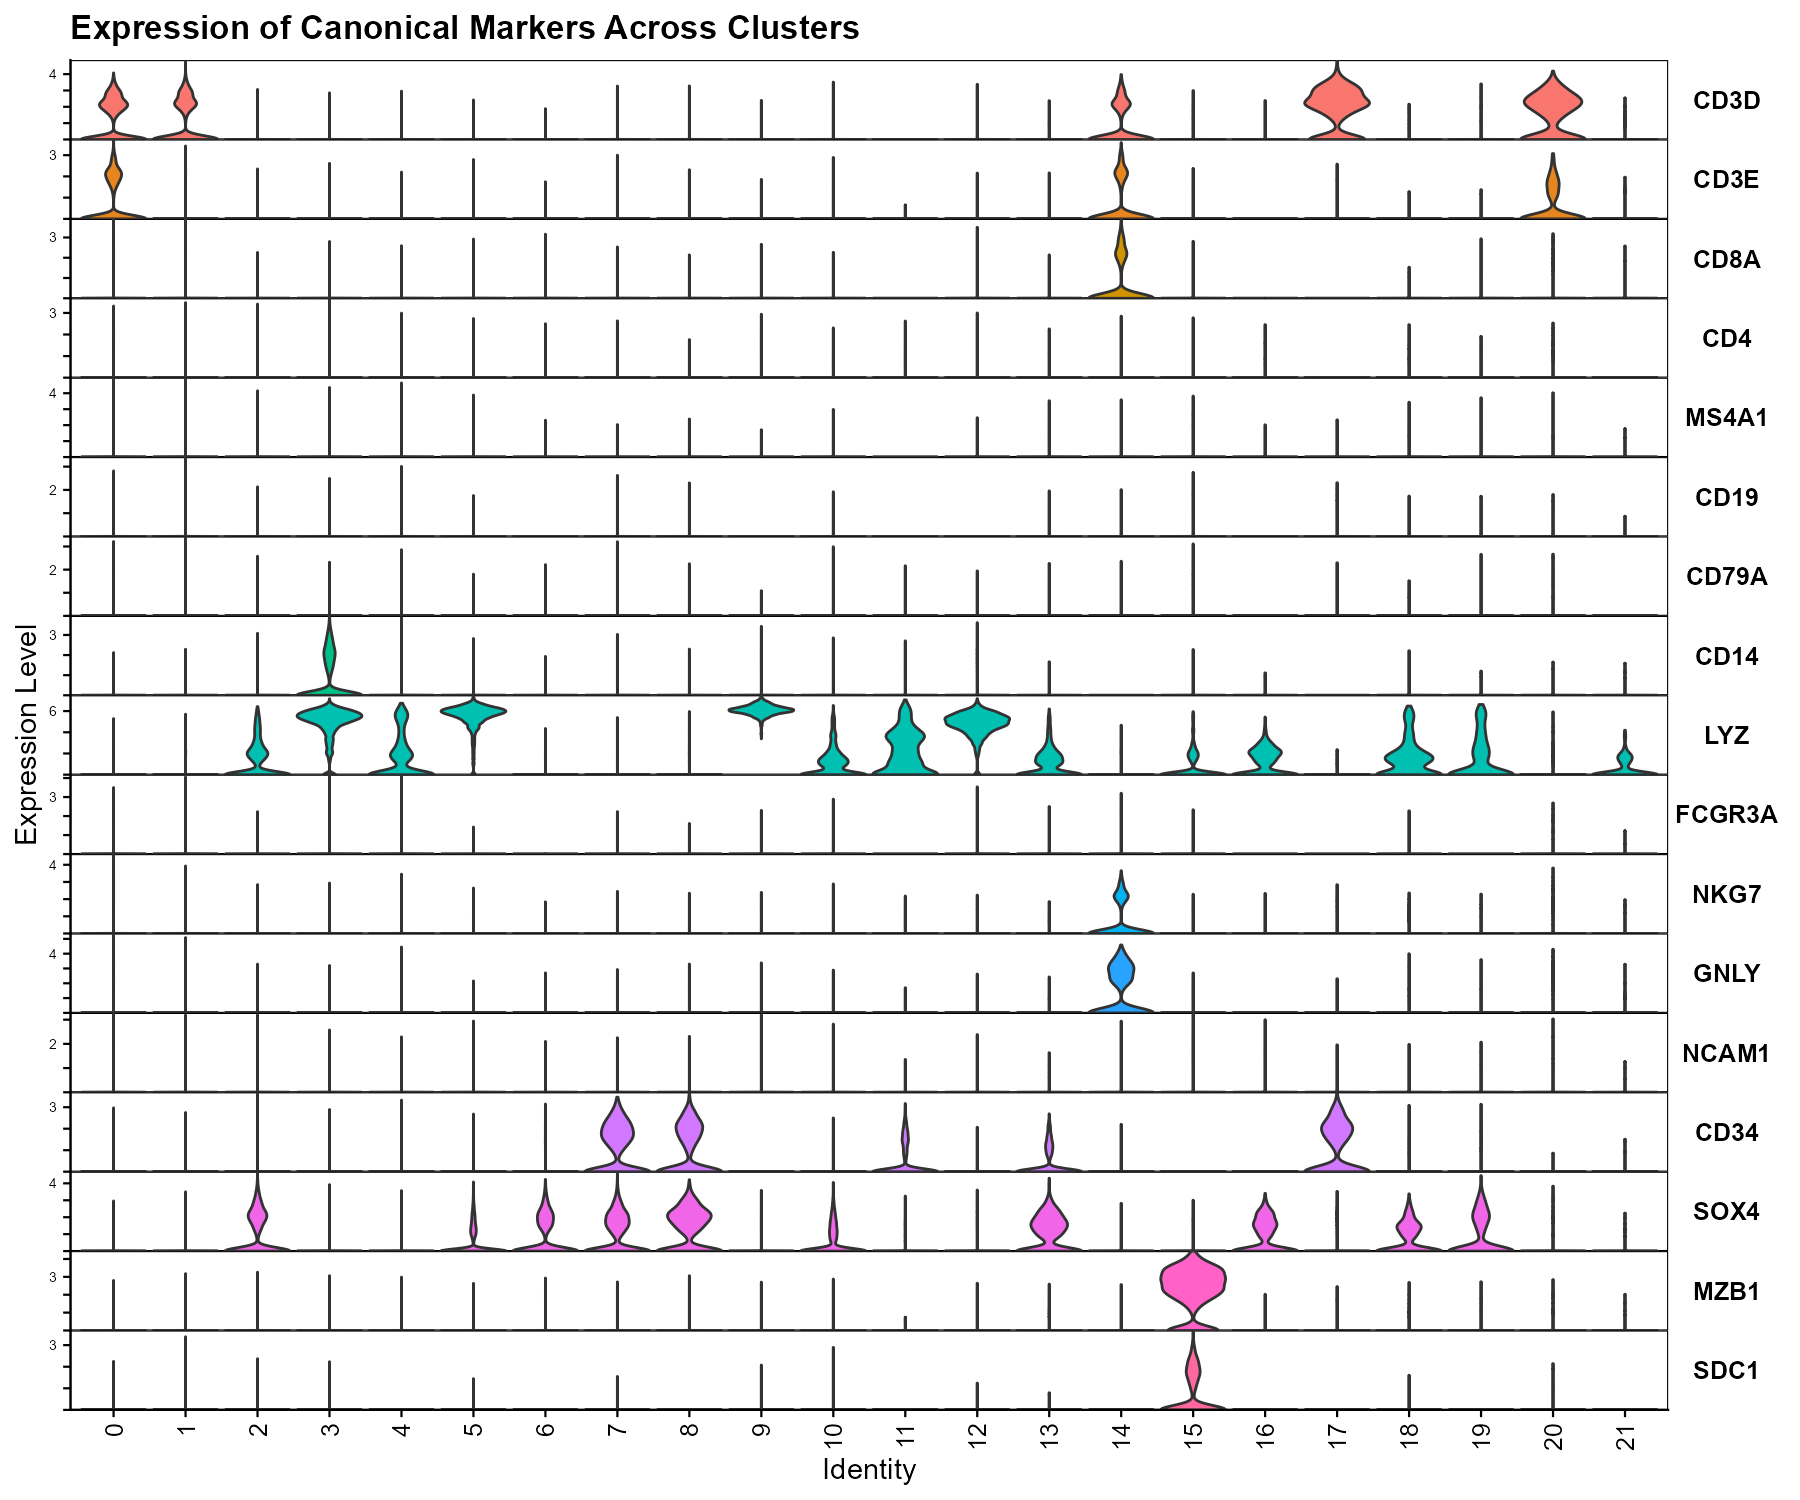

Generating dot plot for a high-level summary:



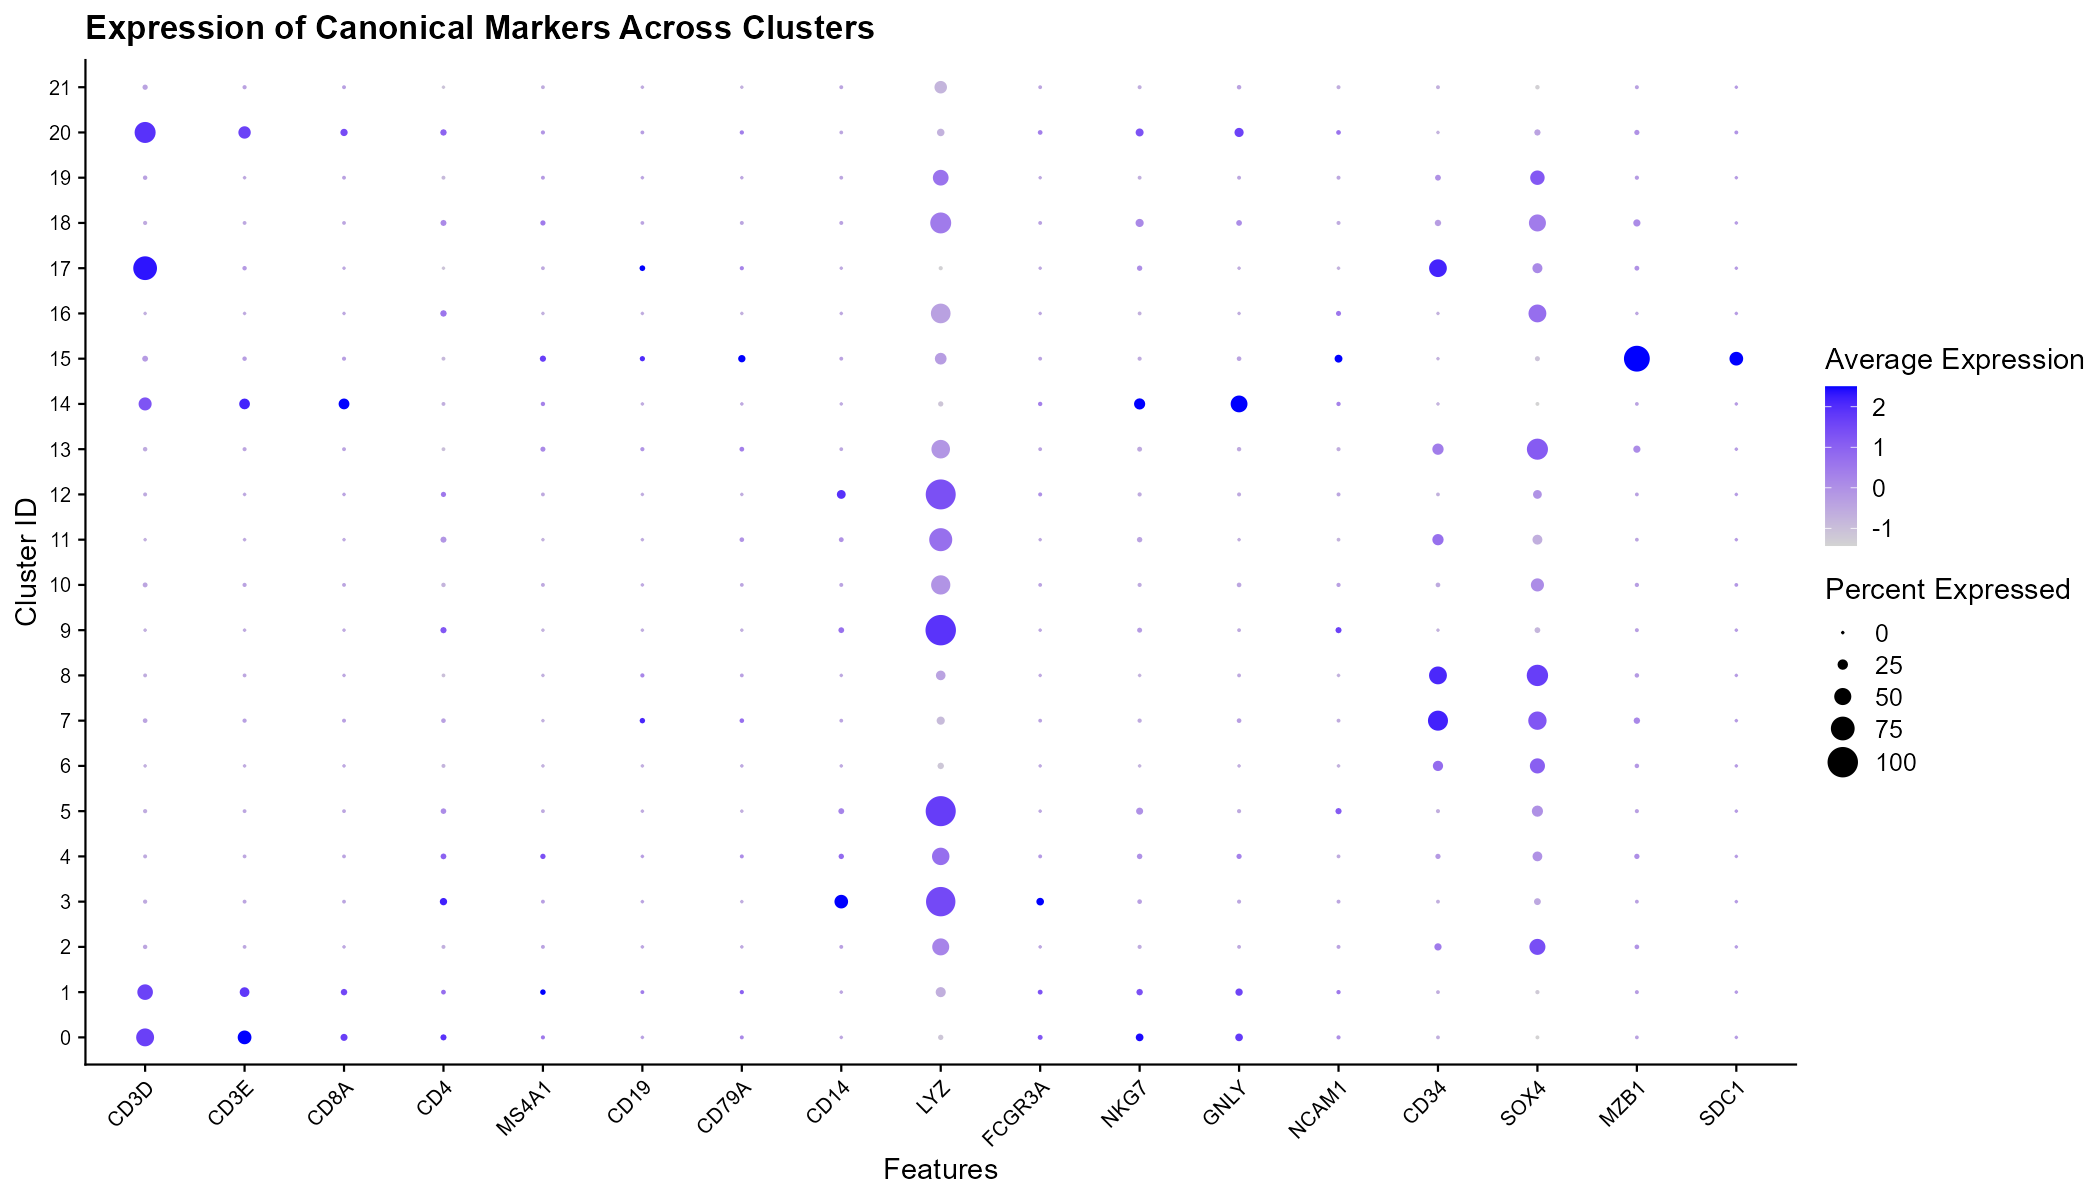

Assigning cell type labels based on marker expression

Cell type annotation complete. Active identity set to 'cell_type'

Generating final annotated UMAP plot:



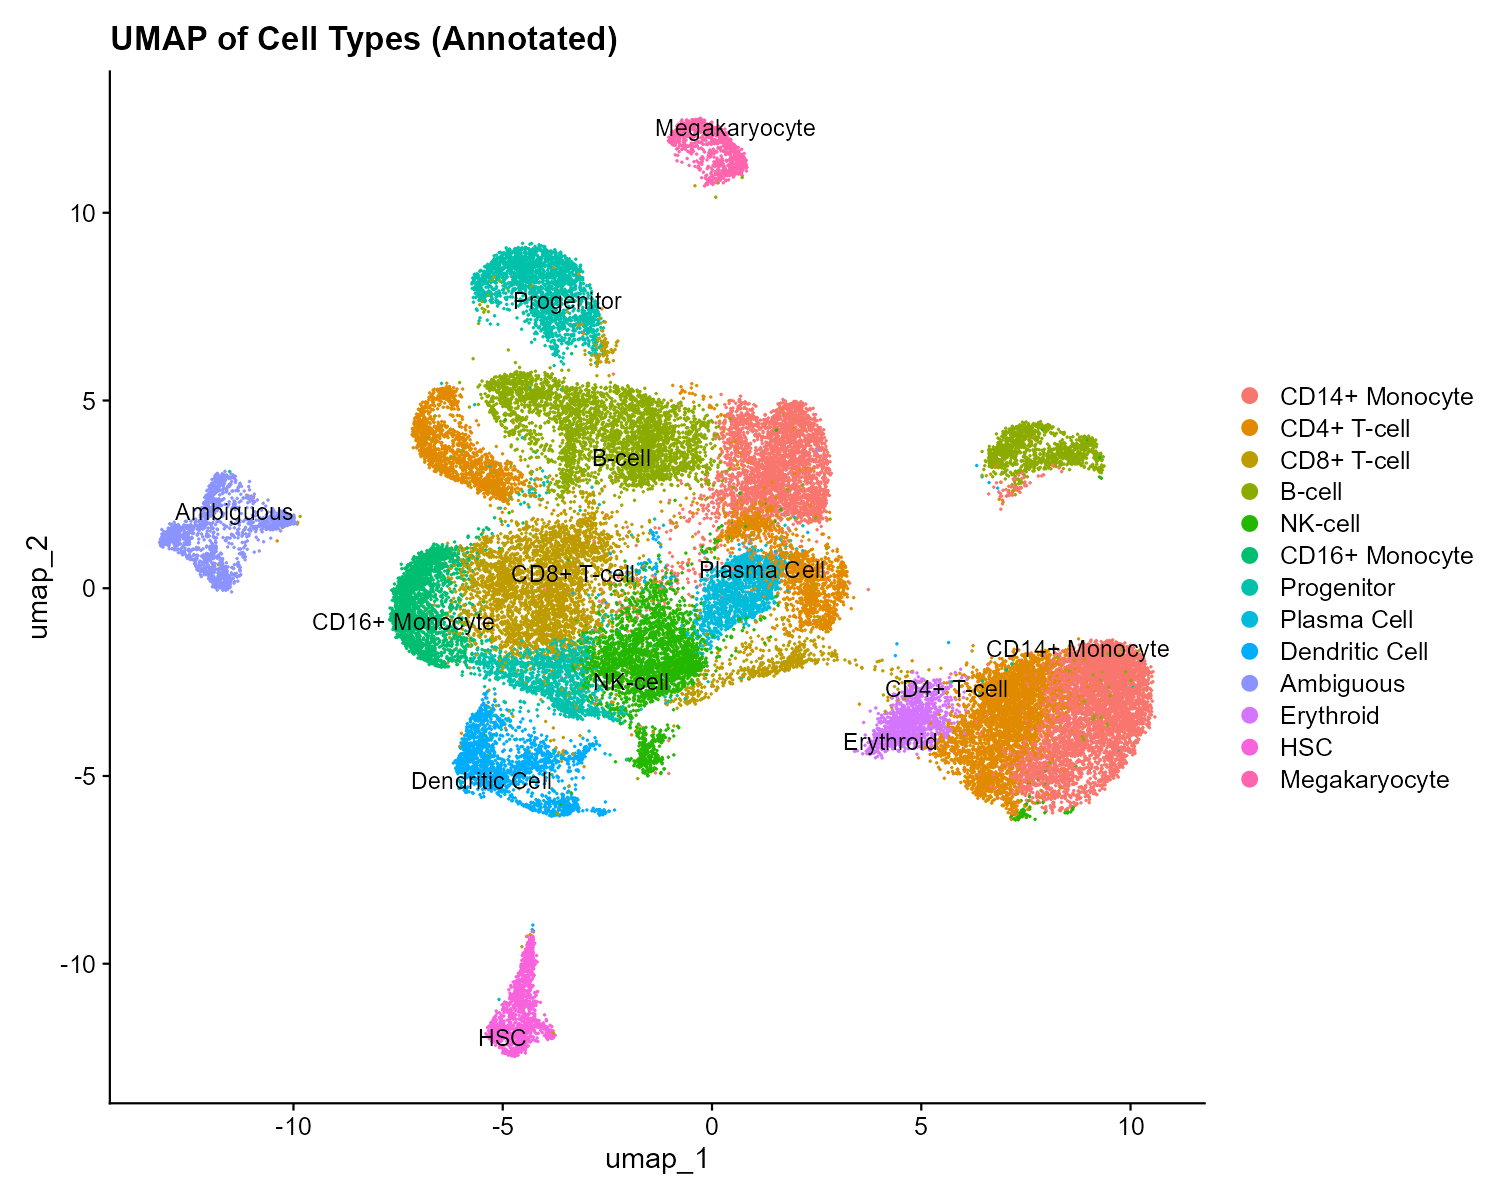

Generating heatmap grouped by cell type:



agg_record_1298243940 
                    2

agg_record_1298243940 
                    2

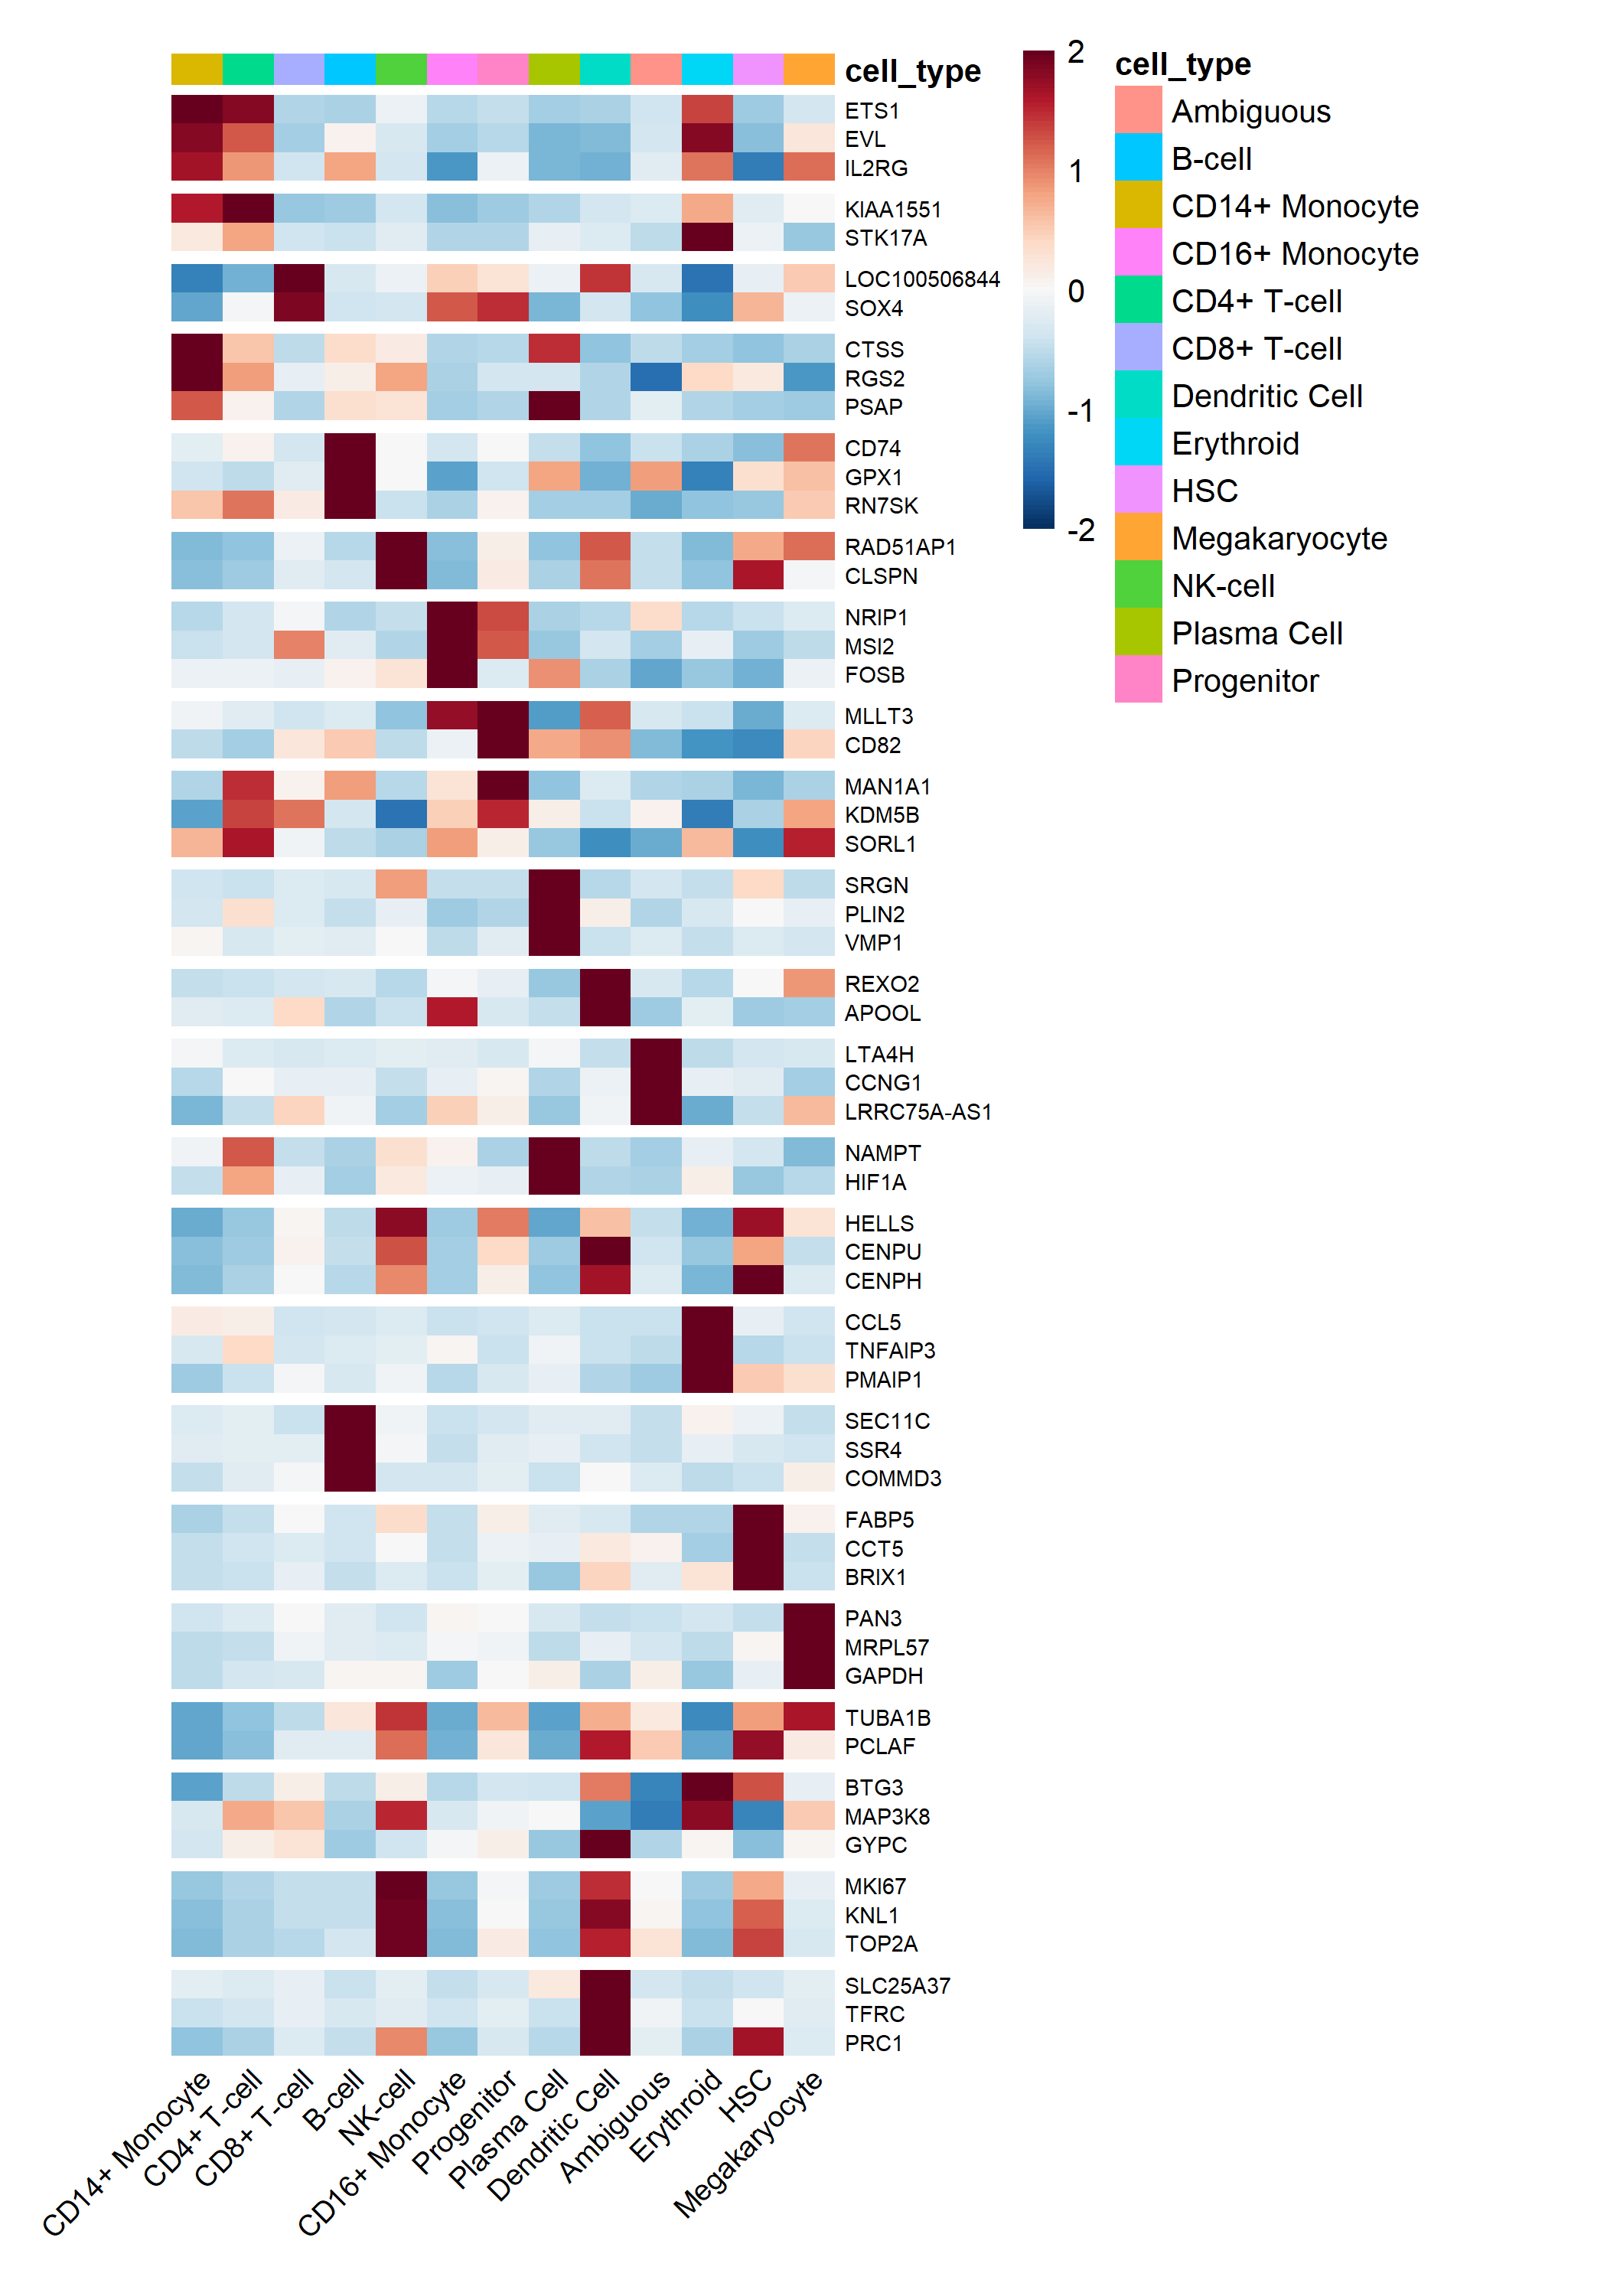

Heatmap grouped by cell type saved to: C:/Users/b1795/Desktop/AML_OCT_v2/figures/Final_Heatmap_Top3_Markers_by_Celltype.pdf and C:/Users/b1795/Desktop/AML_OCT_v2/figures/Final_Heatmap_Top3_Markers_by_Celltype.png

Annotated Seurat object saved to: C:/Users/b1795/Desktop/AML_OCT_v2/results/seu_annotated.rds

Cell Type Annotation Finished



In [9]:
# Set random seed
set.seed(123)

# 1. Load the previously saved object
seu_clustered_path <- file.path(out_res, "seu_clustered.rds")
if (!file.exists(seu_clustered_path)) {
    stop(sprintf("Clustered Seurat object not found at: %s", seu_clustered_path))
}
seu_annotated <- readRDS(seu_clustered_path)
message("Seurat object 'seu_clustered' is ready for Cell Type Annotation")
message("Cell Type Annotation Started")

# Set the current identity
Idents(seu_annotated) <- "seurat_clusters"

# 2. Find marker genes for all clusters
message("Finding markers for all clusters Started")

# Merge count layers if multiple exist
active_assay <- DefaultAssay(seu_annotated)
if (length(Layers(seu_annotated[[active_assay]])) > 1) {
    message(paste("Active assay", active_assay, "has multiple layers. Joining them for DE analysis"))
    seu_annotated[[active_assay]] <- JoinLayers(seu_annotated[[active_assay]])
}

# Run DE analysis on highly variable features only
hvg_features <- VariableFeatures(seu_annotated)  
message(paste("Using", length(hvg_features), "highly variable features for DE analysis"))

all_markers <- FindAllMarkers(
    seu_annotated,
    only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25, 
    features = hvg_features, verbose = FALSE
)

# Save the complete marker list
marker_file <- file.path(out_res, "all_cluster_markers.csv")
write.csv(all_markers, file = marker_file, row.names = FALSE)
message(paste("All markers saved to:", marker_file))

# 3. Visualization
# 3.1 Heatmap (Top3 markers)
message("Generating pheatmap for Top3 markers:")

# Generate Top 3 marker file
# Load all marker results from CSV
markers_csv <- file.path(out_res, "all_cluster_markers.csv")  
all_markers_df <- read.csv(markers_csv, stringsAsFactors = FALSE)

# Handle inconsistent column names
if (!"avg_log2FC" %in% names(all_markers_df) && "avg_logFC" %in% names(all_markers_df)) {
    all_markers_df <- dplyr::rename(all_markers_df, avg_log2FC = avg_logFC)
}

# Extract top 3 markers per cluster and remove duplicates globally
top3_unique_markers <- all_markers_df %>%    
    dplyr::filter(!is.na(cluster)) %>%     
    dplyr::group_by(cluster) %>%  
    dplyr::slice_max(n = 3, order_by = avg_log2FC, with_ties = FALSE) %>% 
    dplyr::ungroup() %>% 
    dplyr::arrange(dplyr::desc(avg_log2FC)) %>%  
    dplyr::distinct(gene, .keep_all = TRUE) 

genes_for_heatmap <- unique(top3_unique_markers$gene)
stopifnot(length(genes_for_heatmap) > 0)

# Calculate average expression for Top 3 markers across clusters
assay <- Seurat::DefaultAssay(seu_annotated)  
avg_expression_list <- Seurat::AverageExpression(   
    seu_annotated, features = genes_for_heatmap, group.by = "seurat_clusters", 
    slot = "data", verbose = FALSE
)
avg_expression_matrix <- as.matrix(avg_expression_list[[assay]])  # Convert list to matrix format

# Manually perform z-score normalization
scaled_matrix <- t(scale(t(avg_expression_matrix)))

# Sort by cluster and avg_log2FC in descending order
markers_sorted_for_plot <- top3_unique_markers %>%
    dplyr::mutate(cluster = factor(cluster, levels = sort(as.numeric(unique(cluster))))) %>%
    dplyr::arrange(cluster, dplyr::desc(avg_log2FC))

# Create annotation table
annotation_row <- markers_sorted_for_plot %>%
    dplyr::select(gene, cluster) %>%
    dplyr::distinct(gene, .keep_all = TRUE) %>%
    tibble::column_to_rownames("gene")
colnames(annotation_row) <- "Source Cluster"

# Get final gene order for plotting
final_gene_order <- rownames(annotation_row)
final_gene_order <- intersect(final_gene_order, rownames(scaled_matrix))  
stopifnot(length(final_gene_order) > 0)

# Ensure the order of expression and annotation matrices are consistent
scaled_matrix_ordered <- scaled_matrix[final_gene_order, , drop = FALSE]
annotation_row_ordered <- annotation_row[final_gene_order, , drop = FALSE]

# Create column annotation
annotation_col <- data.frame(cluster = colnames(scaled_matrix_ordered))
rownames(annotation_col) <- colnames(scaled_matrix_ordered)

# Calculate gap line positions
gaps_row_positions <- table(annotation_row_ordered$`Source Cluster`) %>% cumsum() %>% head(-1) 

# Trim z-score values
z_score_cutoff <- 2
scaled_matrix_ordered[scaled_matrix_ordered >  z_score_cutoff] <-  z_score_cutoff
scaled_matrix_ordered[scaled_matrix_ordered < -z_score_cutoff] <- -z_score_cutoff
scaled_matrix_ordered[is.na(scaled_matrix_ordered)] <- 0

# Create color palette
color_palette  <- grDevices::colorRampPalette(rev(RColorBrewer::brewer.pal(11, "RdBu")))(101)
color_breaks <- seq(-z_score_cutoff, z_score_cutoff, length.out = 102)

# Combine all parameters for pheatmap
pheatmap_args <- list(
    mat = scaled_matrix_ordered, color = color_palette, breaks = color_breaks,
    cluster_rows = FALSE, gaps_row = gaps_row_positions, 
    cluster_cols = TRUE, annotation_col = annotation_col, 
    clustering_distance_cols = "correlation", treeheight_col = 25, 
    clustering_method = "ward.D2", 
    show_rownames = TRUE, show_colnames = TRUE, legend = TRUE, 
    fontsize_row = 7, fontsize_col = 9, angle_col = 45,
    cellwidth = 12, border_color   = NA
)

# Create heatmap object (but do not draw yet)
final_heatmap_object <- do.call(pheatmap::pheatmap, c(pheatmap_args, list(silent = TRUE)))

# Save PDF
pdf_filename <- "Heatmap_Top3_by_Cluster.pdf"
pdf(file.path(out_fig, pdf_filename), width = 8, height = 11)   
grid::grid.draw(final_heatmap_object$gtable)
dev.off()           

# Save PNG
png_filename <- "Heatmap_Top3_by_Cluster.png"
png(file.path(out_fig, png_filename), width = 300 * 8, height = 300 * 11, res = 300)
grid::grid.draw(final_heatmap_object$gtable)
dev.off()

# Save Top 3 unique markers per cluster
write.csv(top3_unique_markers, file.path(out_fig, "Top3_perCluster_unique.csv"), row.names = FALSE)

# Display preview (IRdisplay)
IRdisplay::display_png(file = file.path(out_fig, png_filename), width = 500, height = 600)

message(paste("Top3 markers heatmap (by cluster) saved to:", file.path(out_fig, pdf_filename), "and", file.path(out_fig, png_filename)))

# 3.2 FeaturePlot (for canonical markers)
# Define canonical marker dictionary
message("Visualizing canonical markers to guide annotation")
canonical_markers <- list(
    "T-cells" = c("CD3D", "CD3E", "CD8A", "CD4"),
    "B-cells" = c("MS4A1", "CD19", "CD79A"),
    "Monocytes" = c("CD14", "LYZ", "FCGR3A"),
    "NK-cells" = c("NKG7", "GNLY", "NCAM1"),
    "Progenitors" = c("CD34", "SOX4"),
    "Plasma-cells" = c("MZB1", "SDC1")
)

# Generate FeaturePlots for canonical markers
message("Generating FeaturePlots for canonical markers:")
for (cell_type in names(canonical_markers)) {
    markers <- canonical_markers[[cell_type]]
    markers_exist <- markers[markers %in% rownames(seu_annotated)]
    if (length(markers_exist) > 0) {
        # Adaptive layout
        n_markers <- length(markers_exist)
        if (n_markers <= 2) {
            ncol <- n_markers
        } else if (n_markers == 3) {
            ncol <- 3
        } else {
            ncol <- 2  
        }
        p <- FeaturePlot(seu_annotated, features = markers_exist, ncol = ncol, raster = TRUE)
        plot_width <- ncol * 5 
        plot_height <- 5 * ceiling(n_markers / ncol)
        show_plot(p, paste0("featureplot_", tolower(cell_type)), width = plot_width, height = plot_height, dpi = 150)
    }
}

# 3.3 Violin Plot (VlnPlot)
message("Generating VlnPlot for canonical markers:")
vln_plot <- VlnPlot(seu_annotated, features = unlist(canonical_markers), stack = TRUE, flip = TRUE, pt.size = 0) +
    NoLegend() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
    labs(title = "Expression of Canonical Markers Across Clusters")
show_plot(vln_plot, "vlnplot_canonical_markers", width = 12, height = 10, dpi = 150)

# 3.4 Dot Plot (DotPlot)
message("Generating dot plot for a high-level summary:")
genes_for_dotplot <- unique(unlist(canonical_markers))

# Draw Dot Plot
dot_plot <- DotPlot(seu_annotated, features = genes_for_dotplot, group.by = "seurat_clusters") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 10),
            axis.text.y = element_text(size = 10)) +
    labs(title = "Expression of Canonical Markers Across Clusters",
            x = "Features", y = "Cluster ID")

show_plot(dot_plot, "dotplot_canonical_markers", width = 14, height = 8, dpi = 150)

# 4. Manually assign cell type labels
# Assign cell type labels to each cluster ID based on marker expression
message("Assigning cell type labels based on marker expression")
cluster_to_celltype <- c(
    "0"  = "CD14+ Monocyte", "1" = "CD4+ T-cell", "2" = "CD8+ T-cell",
    "3"  = "CD14+ Monocyte", "4" = "B-cell",      "5" = "NK-cell",
    "6"  = "CD16+ Monocyte", "7" = "Progenitor",  "8" = "CD4+ T-cell",
    "9"  = "Plasma Cell",   "10" = "Dendritic Cell", "11" = "Ambiguous",
    "12" = "CD4+ T-cell",   "13" = "Progenitor",     "14" = "Erythroid",
    "15" = "B-cell",        "16" = "HSC",            "17" = "Megakaryocyte",
    "18" = "B-cell",        "19" = "CD8+ T-cell",    "20" = "NK-cell",
    "21" = "Dendritic Cell"
)

# Update seurat_clusters with annotations
seu_annotated$cell_type <- plyr::mapvalues(
    x = seu_annotated$seurat_clusters,
    from = names(cluster_to_celltype),
    to = as.character(cluster_to_celltype)
)

# Set cell_type as the default identity
Idents(seu_annotated) <- "cell_type"
message("Cell type annotation complete. Active identity set to 'cell_type'")

# 5. Visualize the final UMAP plot with annotations
message("Generating final annotated UMAP plot:")
final_annotated_umap <- DimPlot(
    seu_annotated, reduction = "umap",
    label = TRUE, label.size = 4, repel = TRUE
) + labs(title = "UMAP of Cell Types (Annotated)") +
    theme(legend.position = "right")

show_plot(final_annotated_umap, "umap_annotated_cell_types", width = 10, height = 8, dpi = 150)

# Generate final heatmap grouped by cell type
message("Generating heatmap grouped by cell type:")

# Ensure cell_type column exists and is categorical
if (!"cell_type" %in% colnames(seu_annotated@meta.data)) {
    stop("Error: 'cell_type' column not found in Seurat object metadata. Please perform cell type annotation first")
}

# Convert the cell type column to a factor and reorder levels alphabetically
seu_annotated$cell_type <- factor(seu_annotated$cell_type, levels = sort(unique(seu_annotated$cell_type)))

# Calculate average expression per cell type
avg_expression_list_by_celltype <- Seurat::AverageExpression(
    seu_annotated,
    features = genes_for_heatmap, 
    group.by = "cell_type",
    slot = "data",
    verbose = FALSE
)
avg_expression_matrix_by_celltype <- as.matrix(avg_expression_list_by_celltype[[assay]]) 

# Manually perform z-score normalization
scaled_matrix_by_celltype <- t(scale(t(avg_expression_matrix_by_celltype)))

# Ensure the new expression matrix follows this gene order
genes_ct <- intersect(final_gene_order, rownames(scaled_matrix_by_celltype))
stopifnot(length(genes_ct) > 0)
scaled_matrix_ordered_by_celltype <- scaled_matrix_by_celltype[genes_ct, , drop = FALSE]

# Create new column annotations (by cell type)
annotation_col_by_celltype <- data.frame(cell_type = colnames(scaled_matrix_ordered_by_celltype))
rownames(annotation_col_by_celltype) <- colnames(scaled_matrix_ordered_by_celltype)

# Clip z-scores
scaled_matrix_ordered_by_celltype[scaled_matrix_ordered_by_celltype >  z_score_cutoff] <-  z_score_cutoff
scaled_matrix_ordered_by_celltype[scaled_matrix_ordered_by_celltype < -z_score_cutoff] <- -z_score_cutoff
scaled_matrix_ordered_by_celltype[is.na(scaled_matrix_ordered_by_celltype)] <- 0

# Assemble pheatmap arguments
pheatmap_args_by_celltype <- pheatmap_args # Copy the previous argument list
pheatmap_args_by_celltype$mat <- scaled_matrix_ordered_by_celltype
pheatmap_args_by_celltype$annotation_col <- annotation_col_by_celltype
pheatmap_args_by_celltype$cluster_cols <- FALSE                                 
pheatmap_args_by_celltype$cellheight <- 9   
pheatmap_args_by_celltype$cellwidth <- 16   

# Generate and save the plot
final_heatmap_object_by_celltype <- do.call(pheatmap::pheatmap, c(pheatmap_args_by_celltype, list(silent = TRUE)))

# Define output filenames
pdf_filename_ct <- "Final_Heatmap_Top3_Markers_by_Celltype.pdf"
png_filename_ct <- "Final_Heatmap_Top3_Markers_by_Celltype.png"

# Save as PDF
pdf(file.path(out_fig, pdf_filename_ct), width = 7, height = 10) 
grid::grid.draw(final_heatmap_object_by_celltype$gtable)
dev.off()

# Save as PNG
png(file.path(out_fig, png_filename_ct), width = 300 * 7, height = 300 * 10, res = 300)
grid::grid.draw(final_heatmap_object_by_celltype$gtable)
dev.off()

# Preview the generated PNG on screen
IRdisplay::display_png(file = file.path(out_fig, png_filename_ct), width = 500, height = 600)

message(paste("Heatmap grouped by cell type saved to:", file.path(out_fig, pdf_filename_ct), "and", file.path(out_fig, png_filename_ct)))

# 6. Save the annotated Seurat object
output_file_annotated <- file.path(out_res, "seu_annotated.rds")
saveRDS(seu_annotated, file = output_file_annotated)
message("Annotated Seurat object saved to: ", output_file_annotated)
message("Cell Type Annotation Finished")

# **6. Differential Expression and Enrichment Analysis**    

Annotated Seurat object is ready for DEG analysis

DEG & Enrichment Analysis Started

Created precise 'condition' metadata  Counts per group:




      Healthy   AML_Patient AML_Cell_Line       Unknown 
         7679         30673          2669             0 



Performing DEG analysis for: CD4+ T-cell

Finding DEGs between AML_Patient and Healthy conditions

DEG results saved to: C:/Users/b1795/Desktop/AML_OCT_v2/results/DEGs_in_CD4+_T-cell.csv

Generating volcano plot:



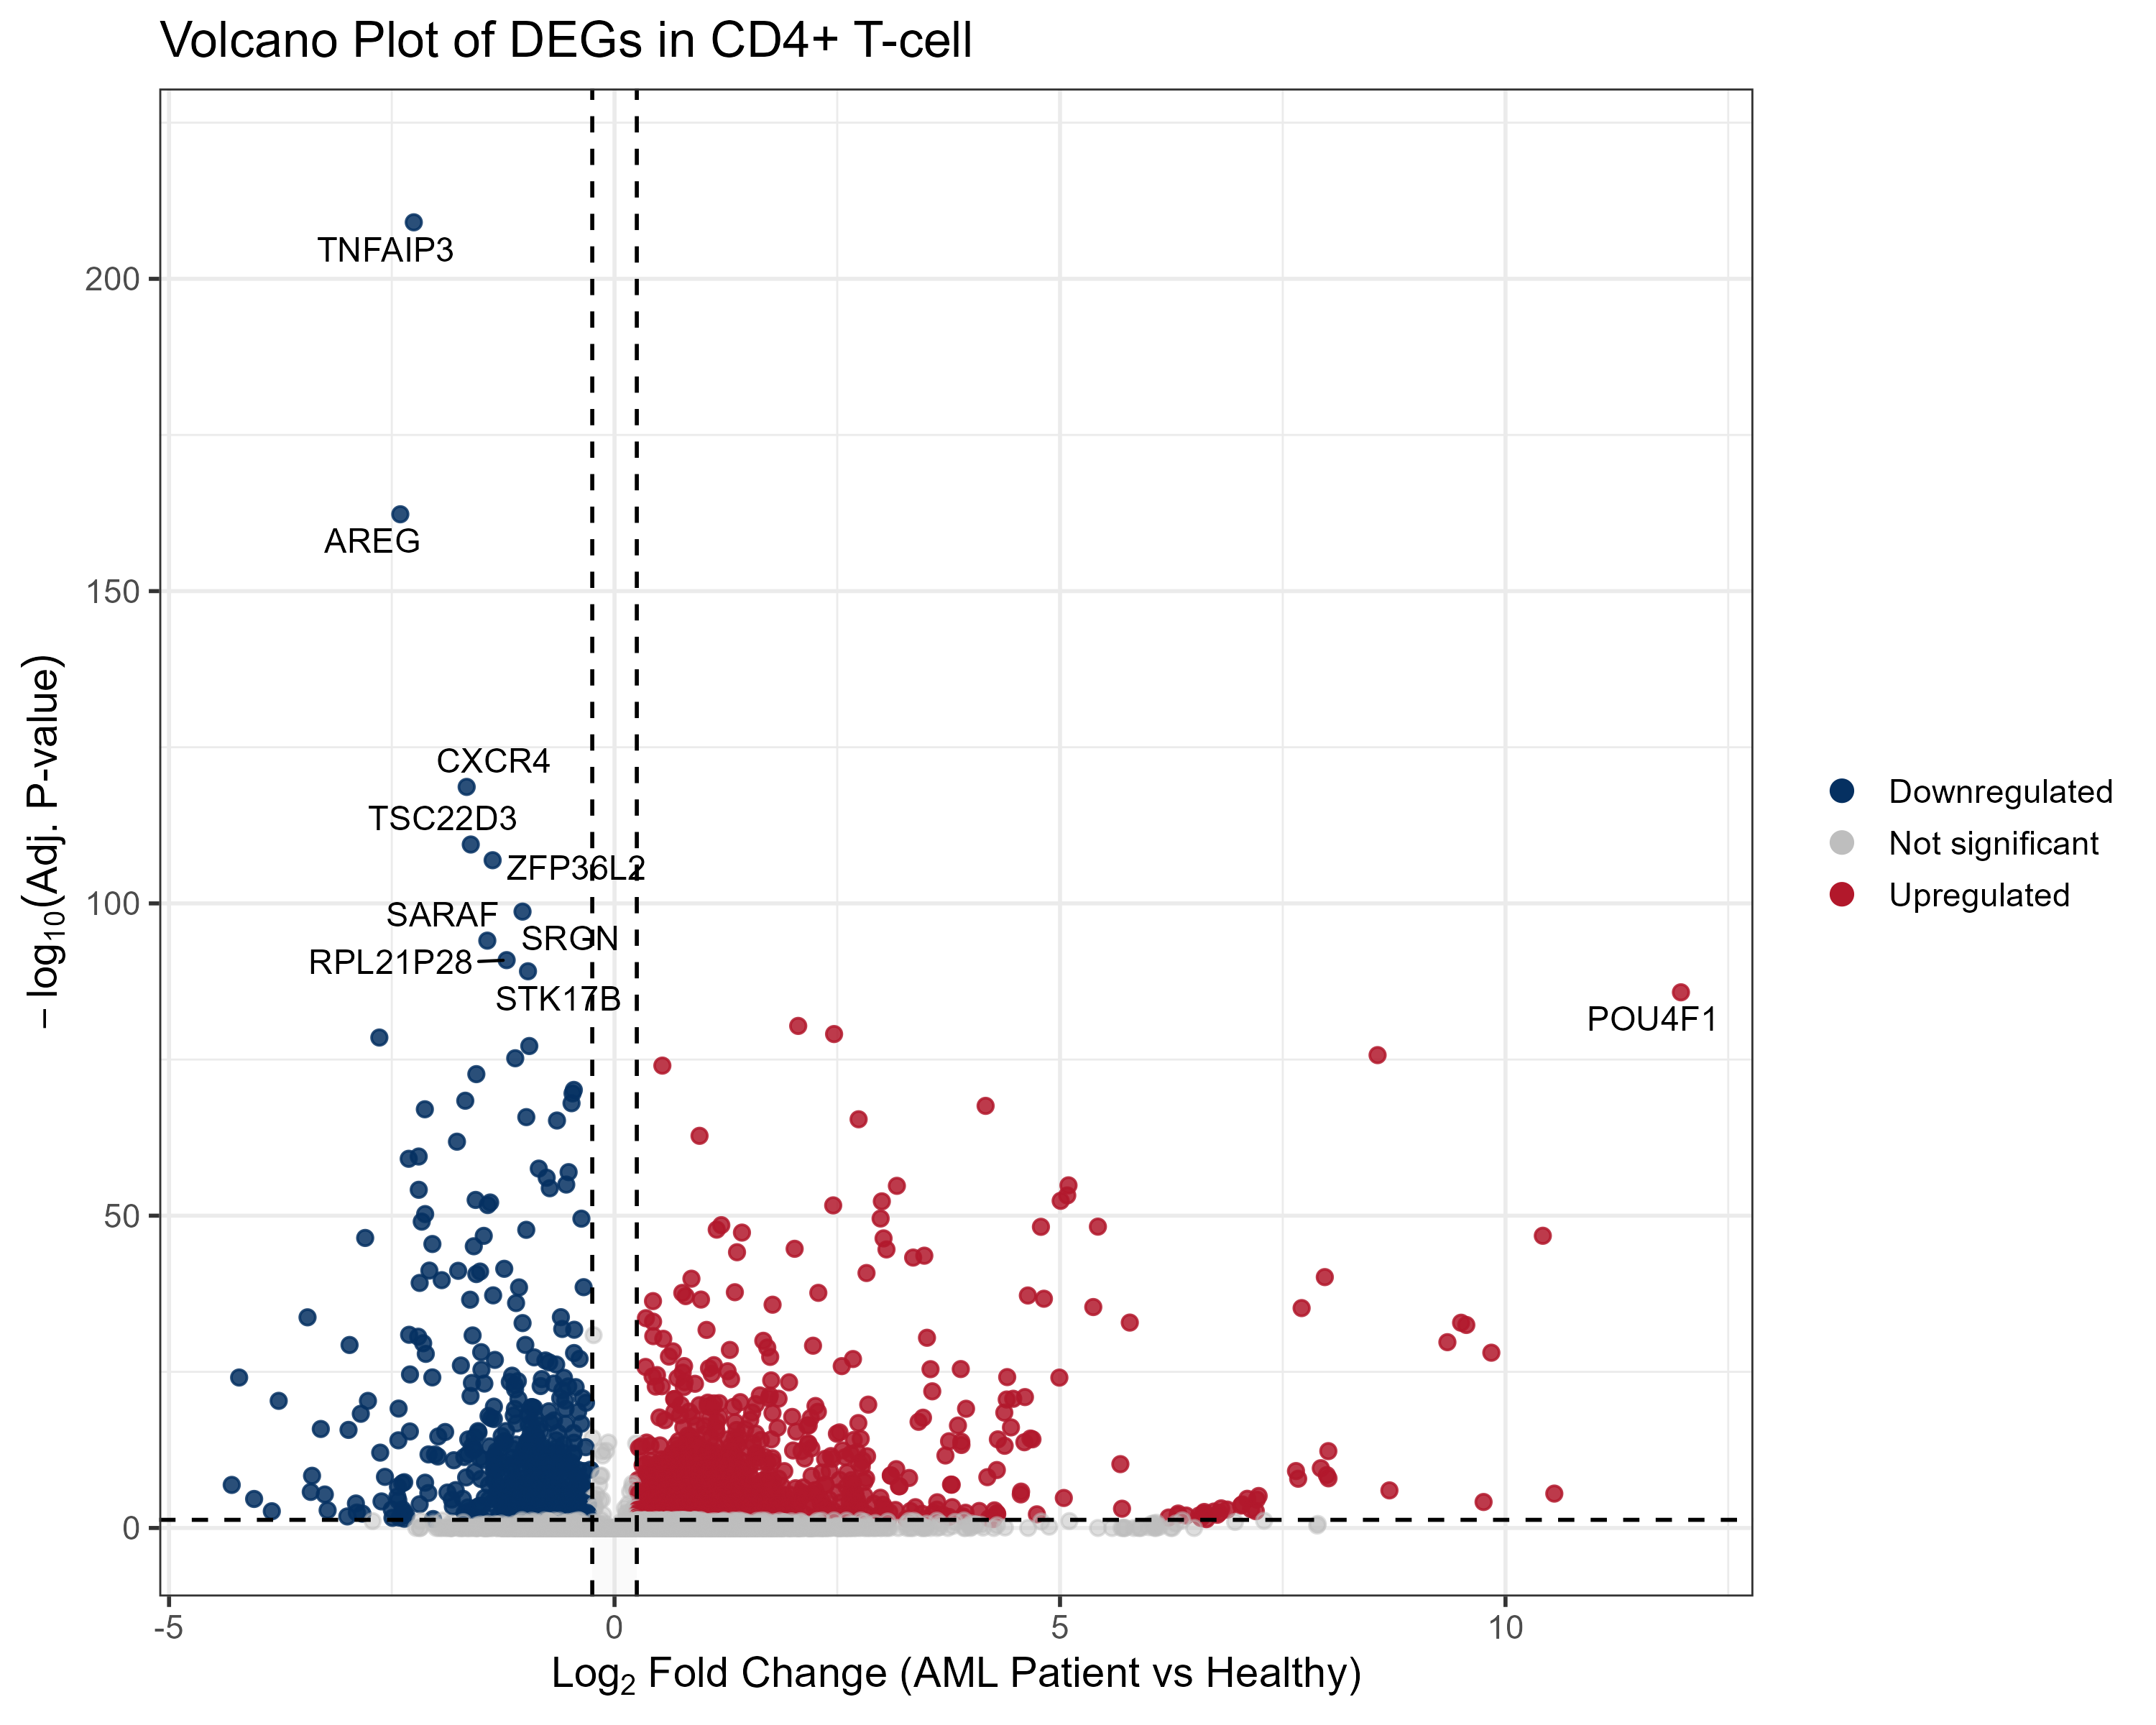


Performing GO Enrichment Analysis Started

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(up_genes, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = org.Hs.eg.db):
"6.22% of input gene IDs are fail to map..."


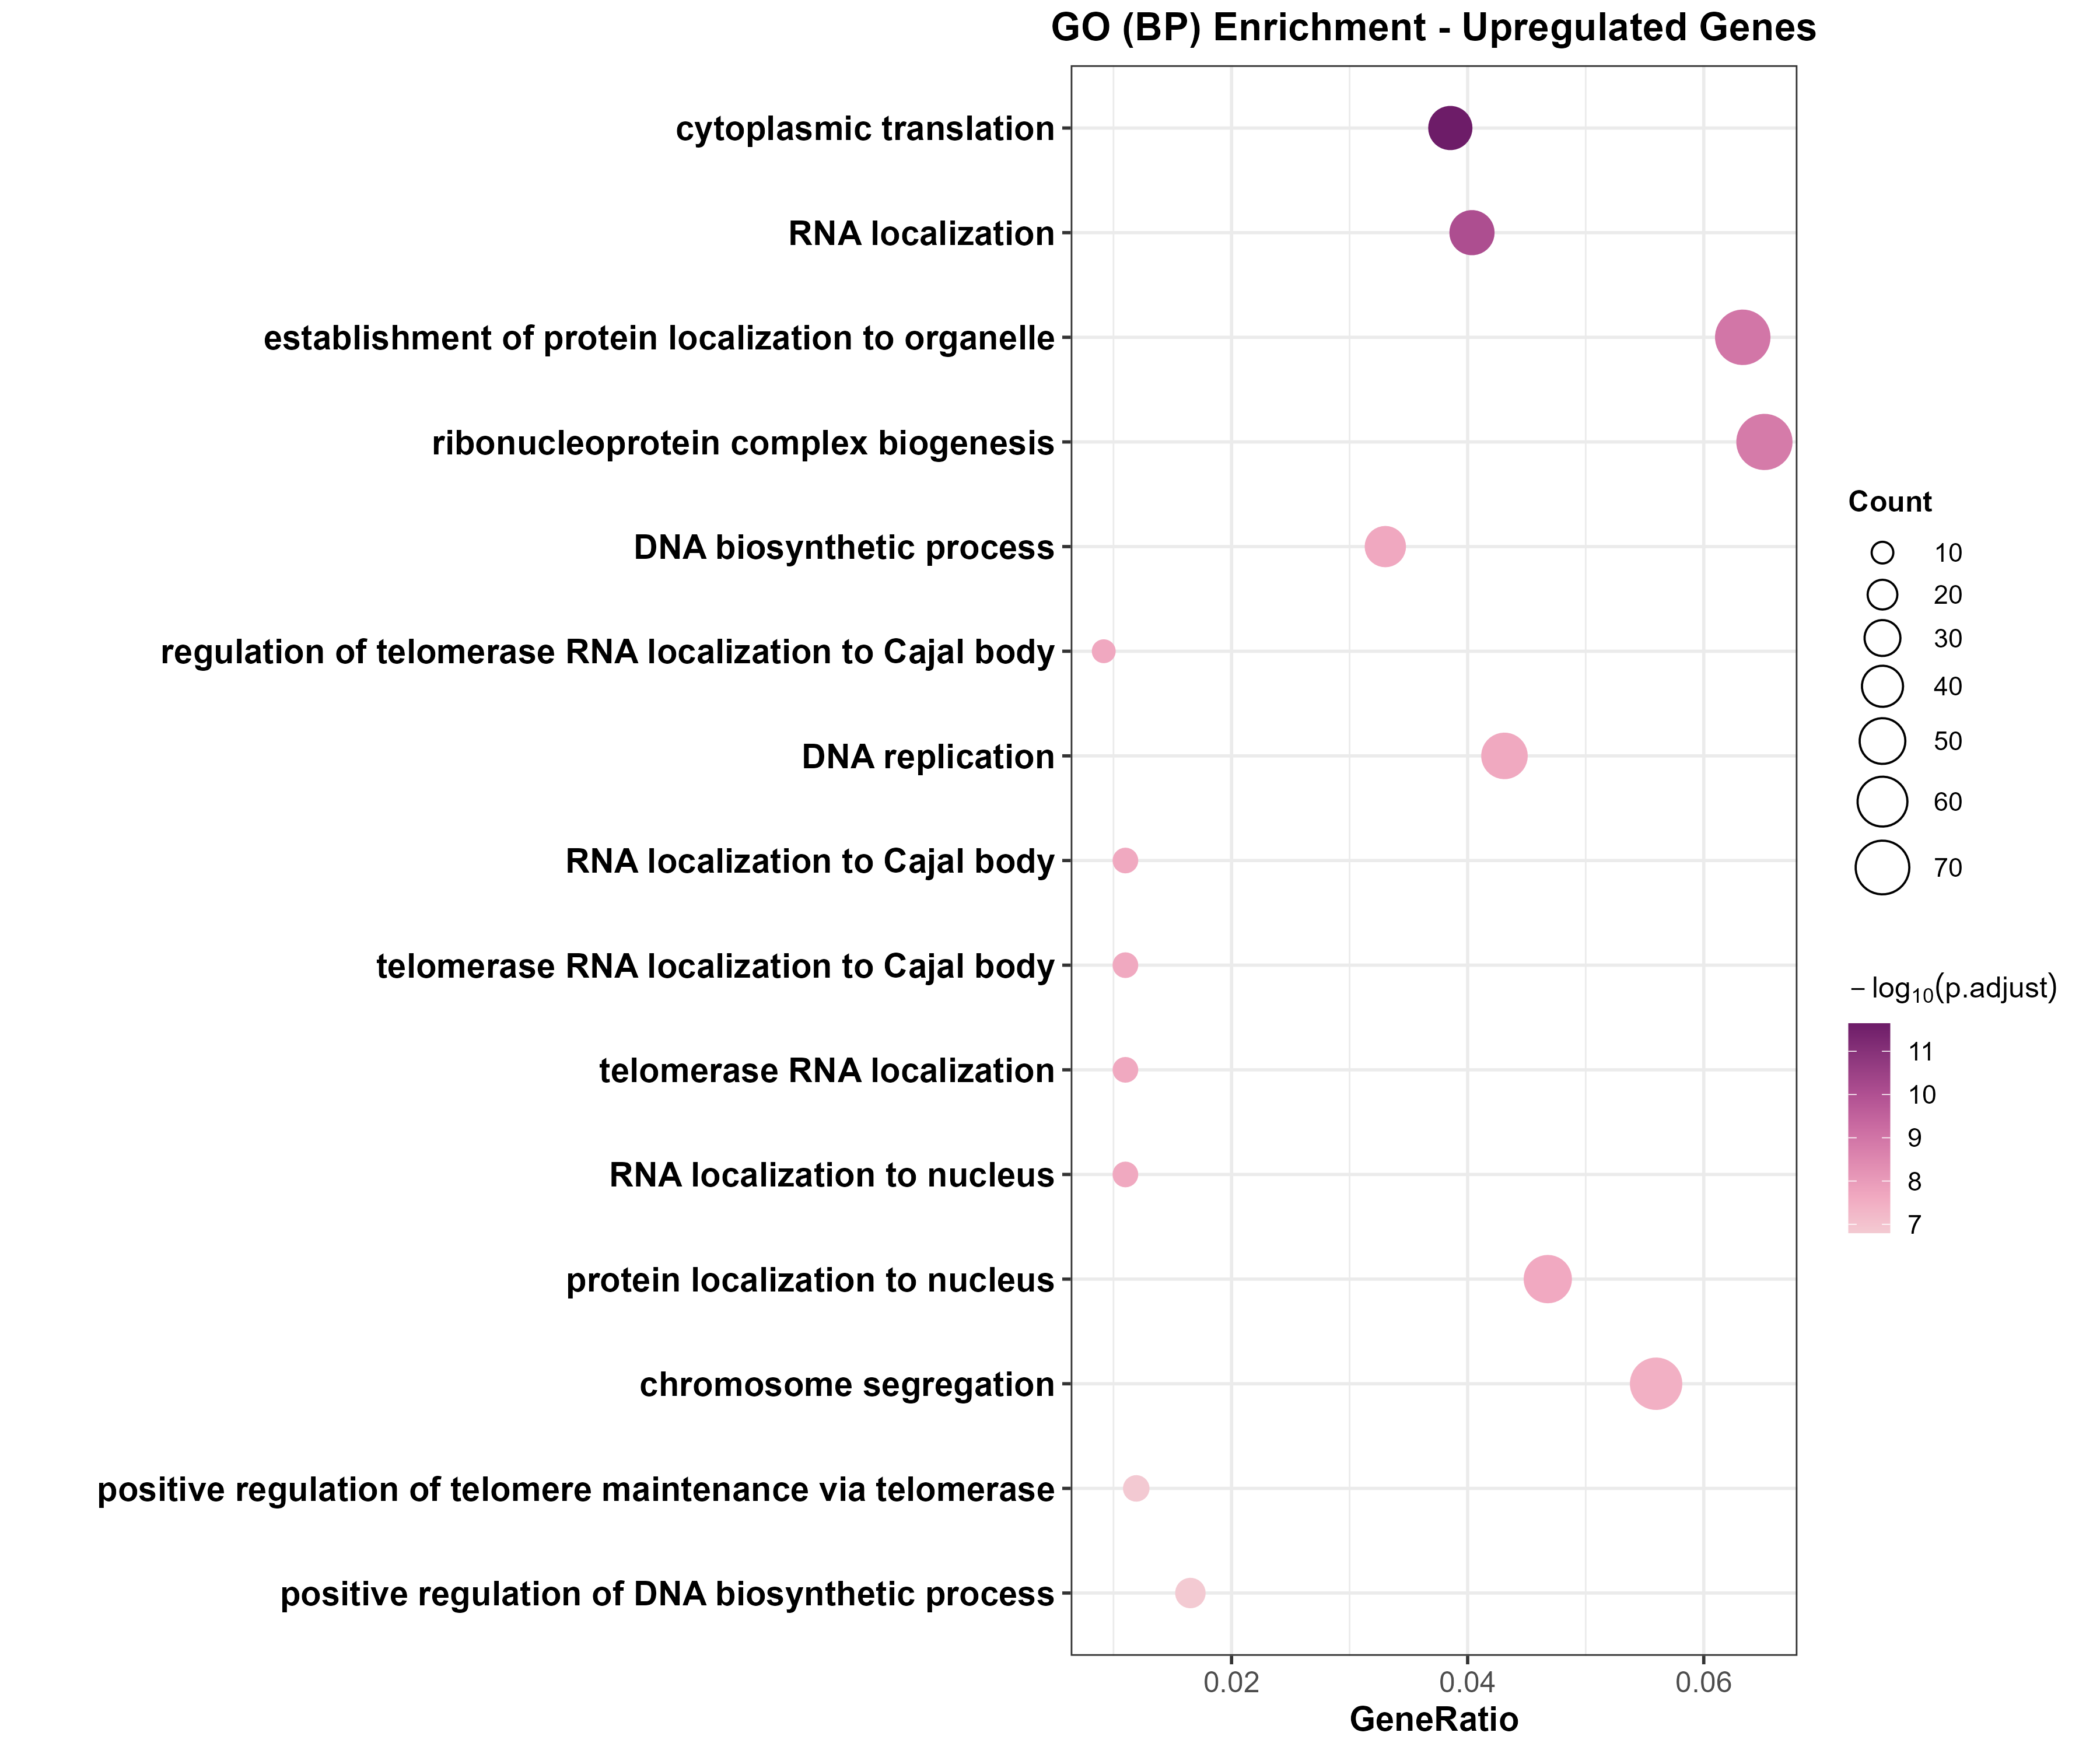

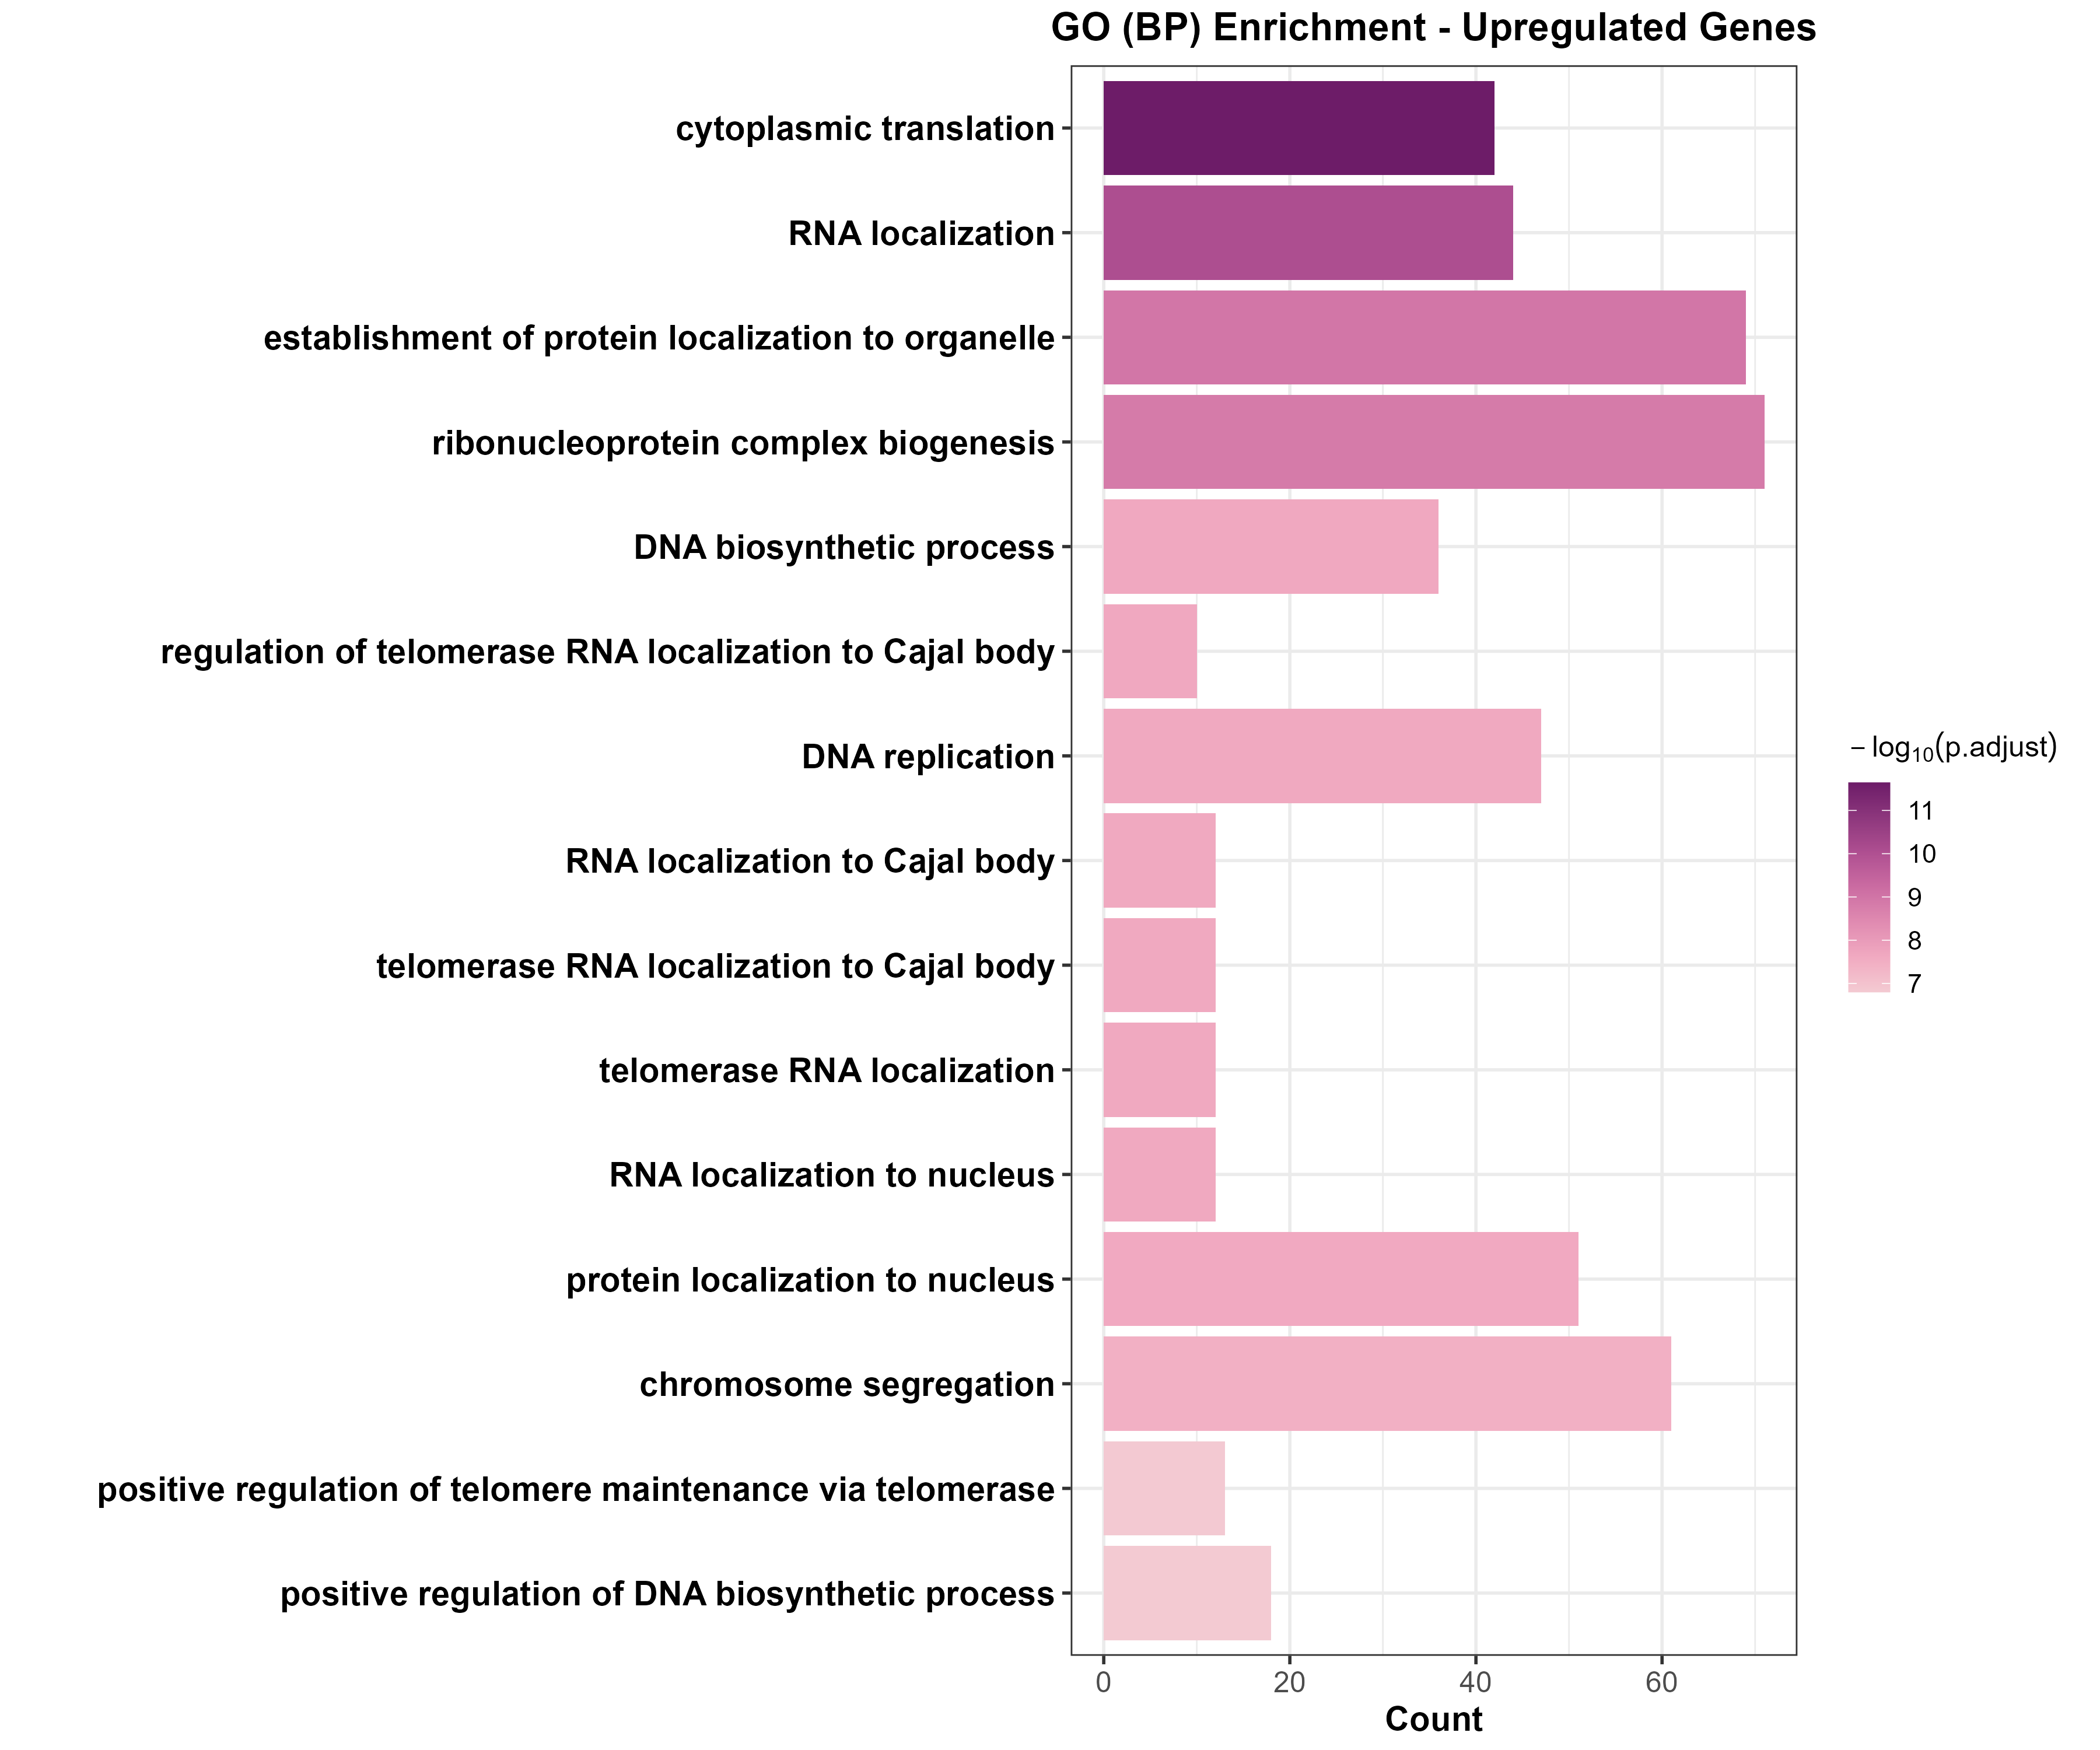

GO enrichment plots saved


Performing KEGG Enrichment Analysis Started



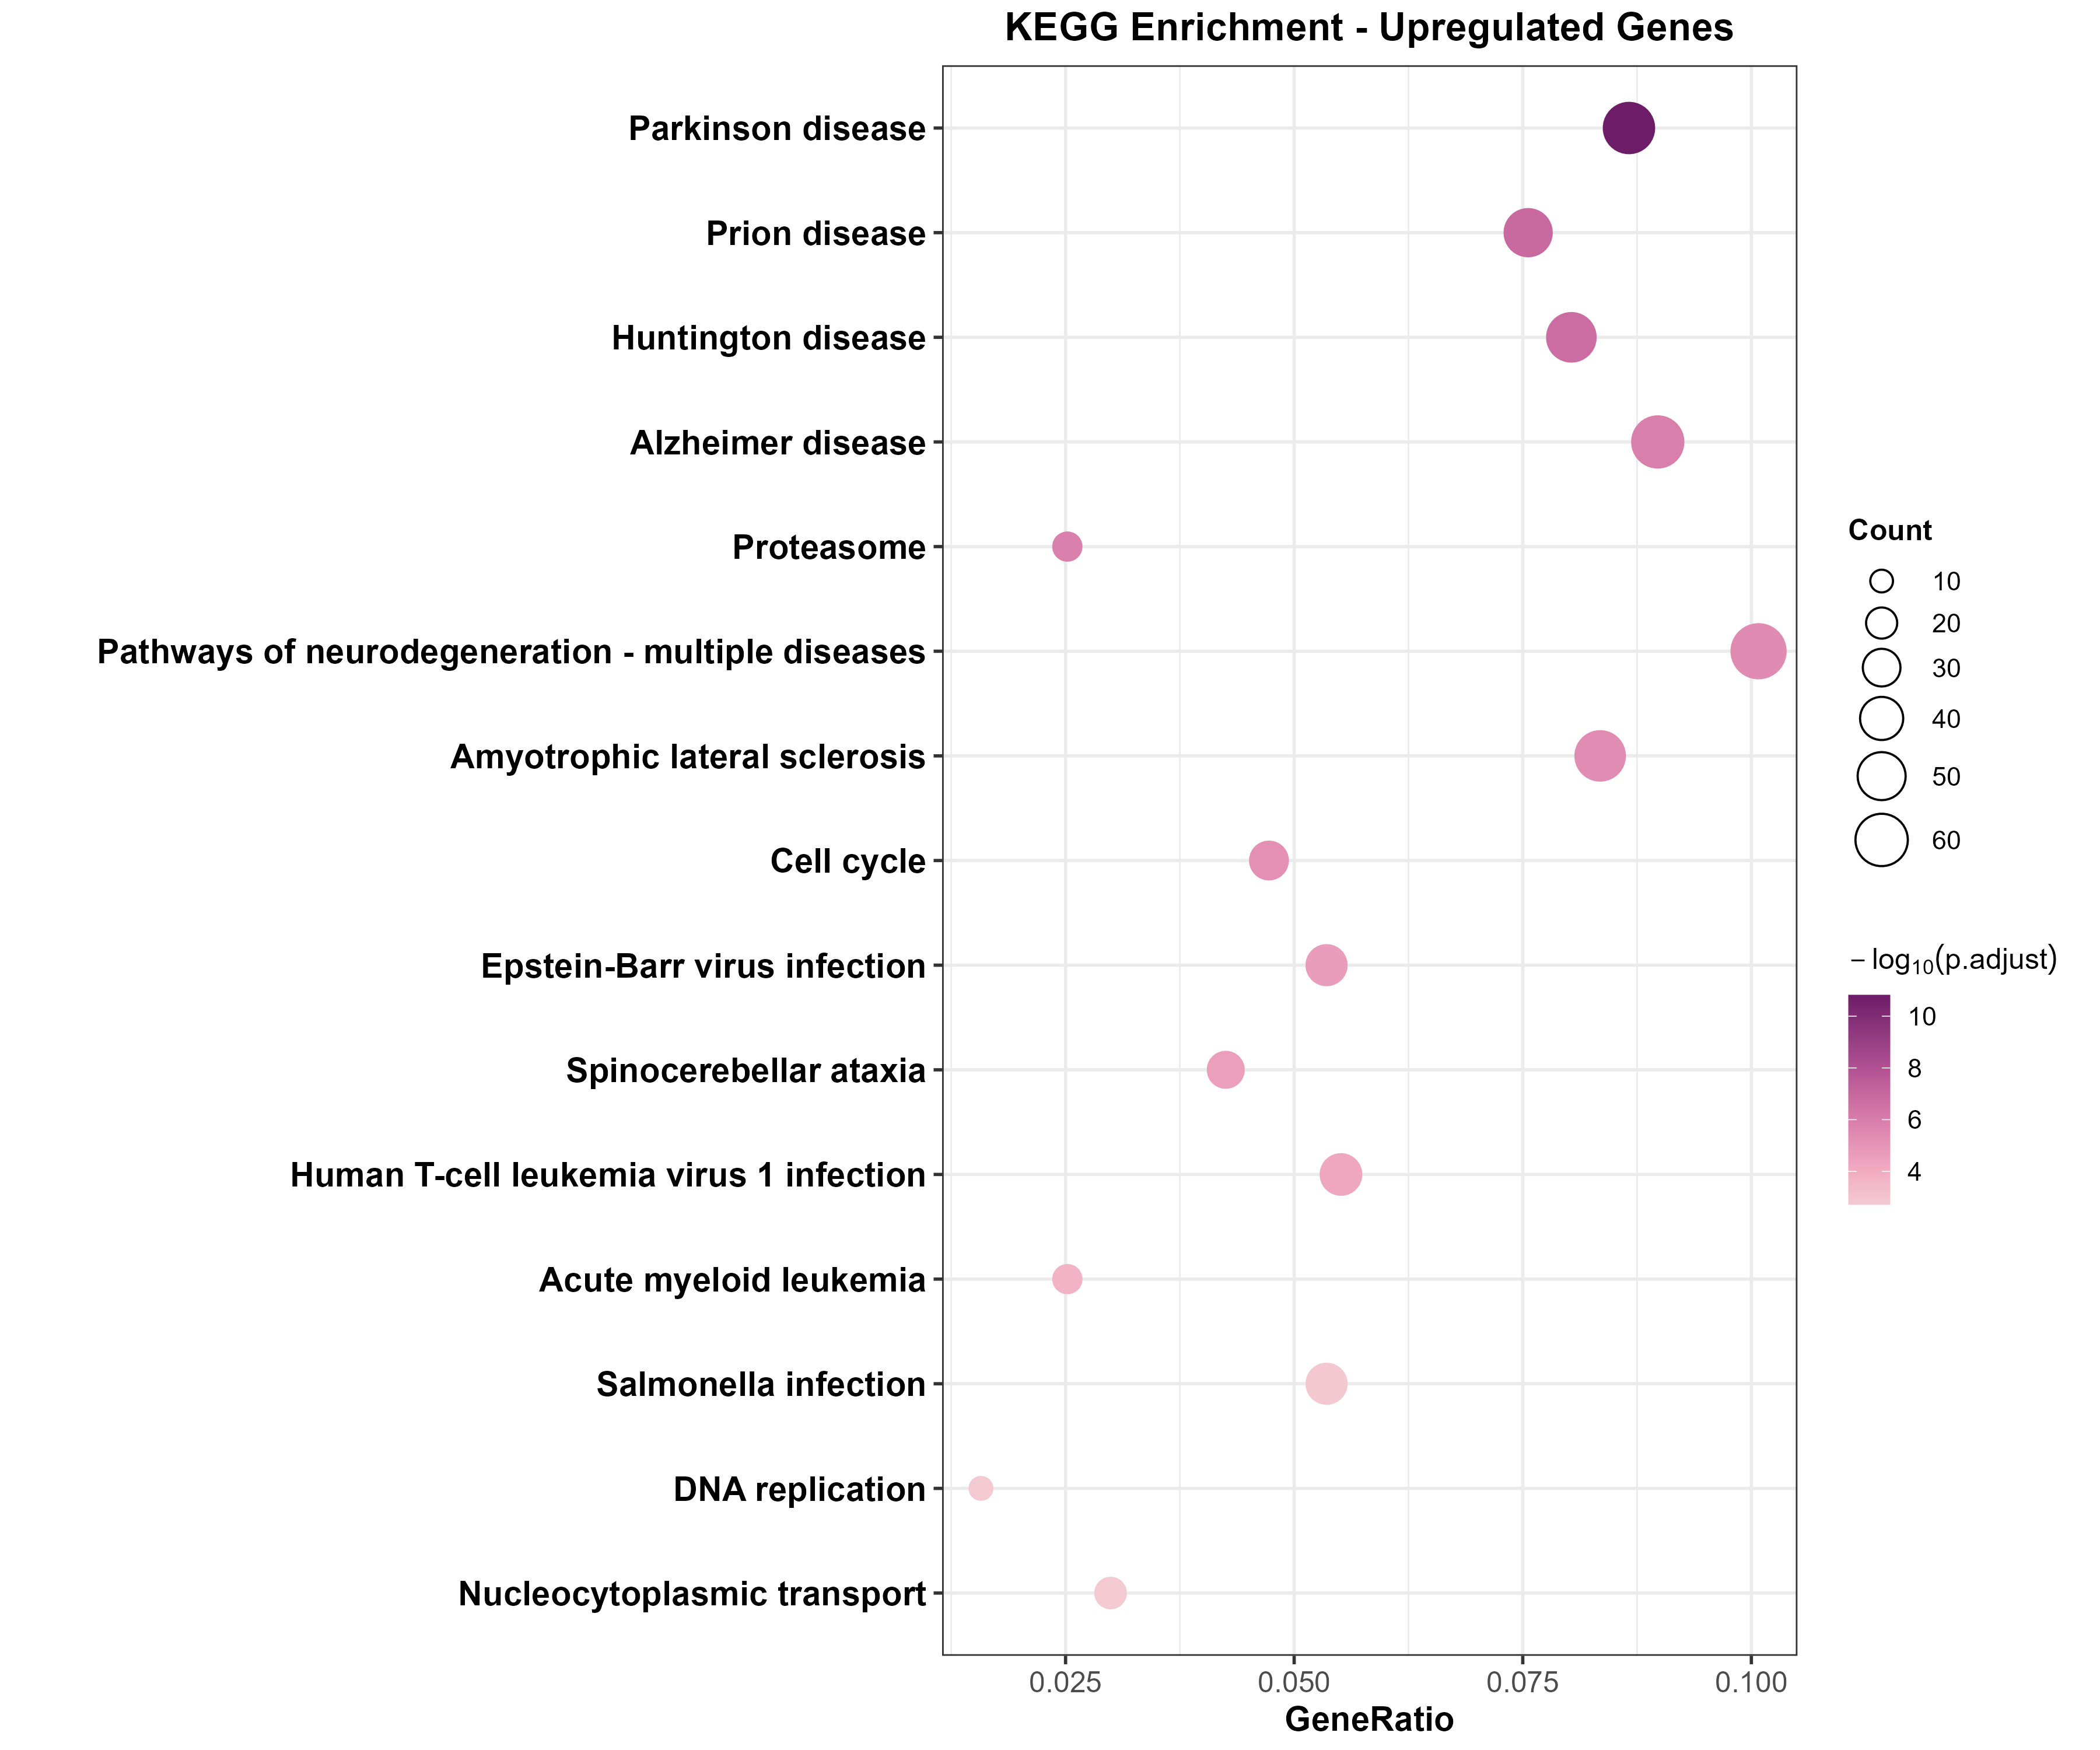

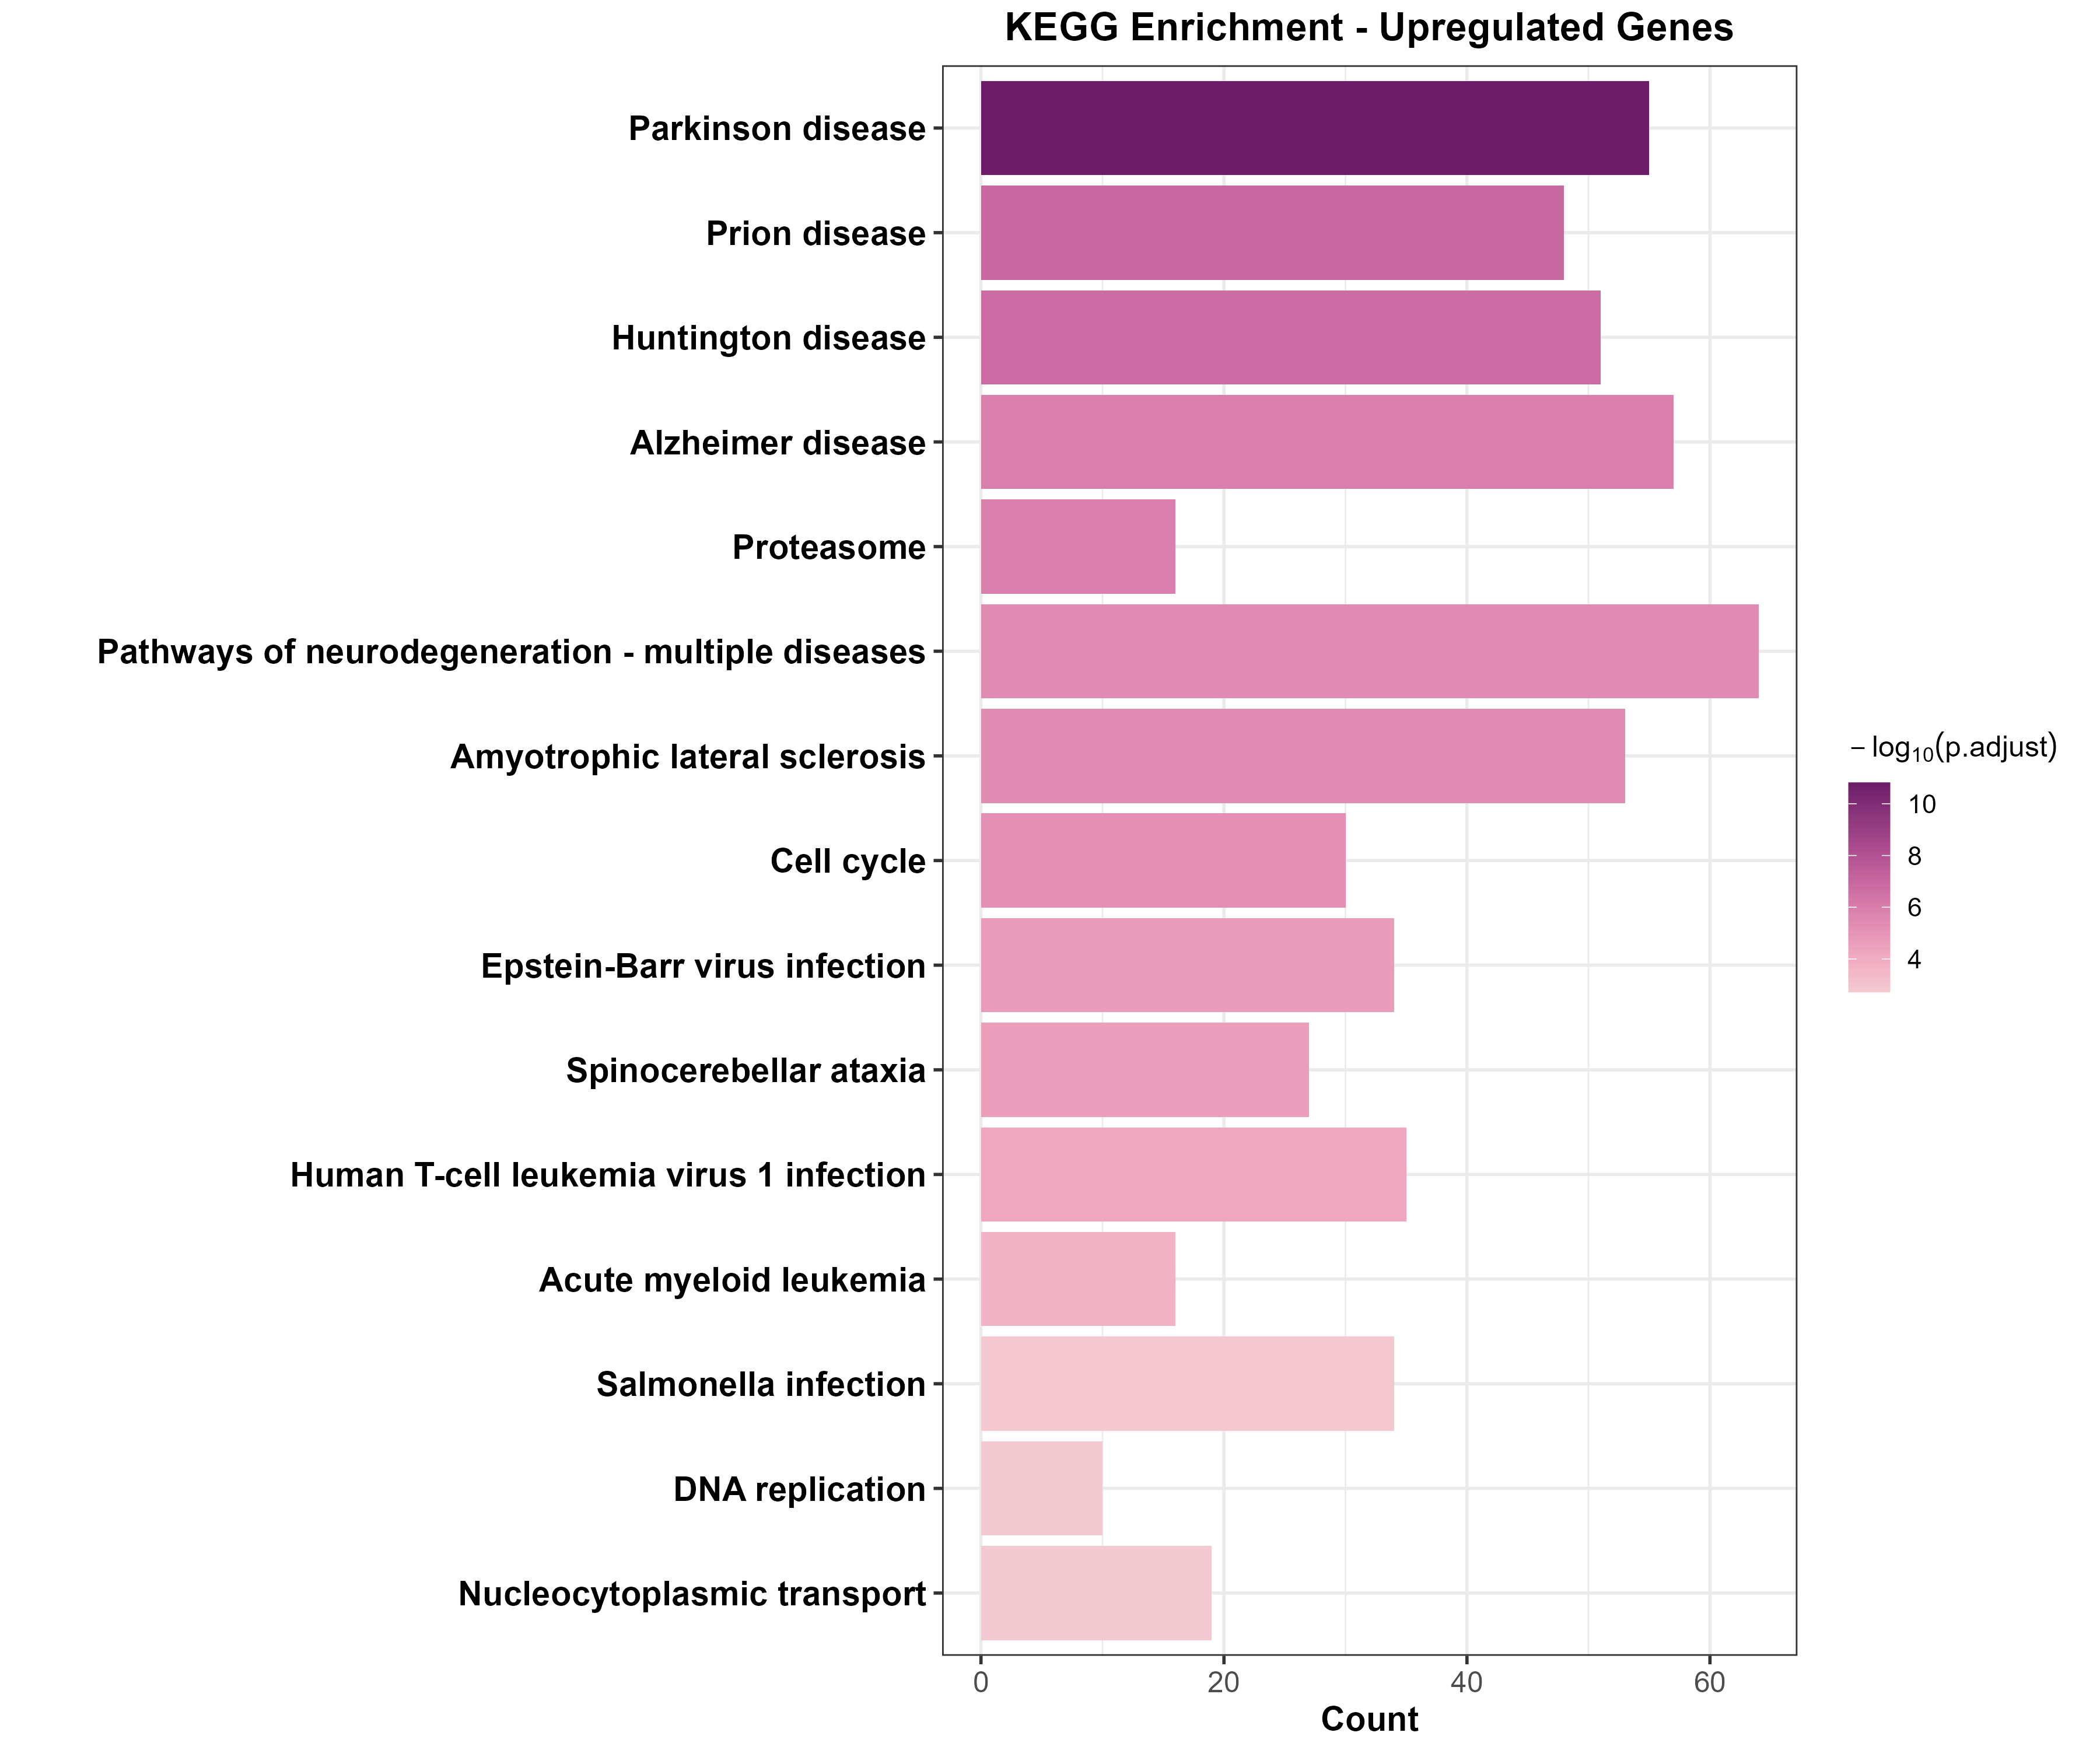

KEGG enrichment plot saved


DEG & Enrichment Analysis Finished



In [11]:
# Set random seed
set.seed(123)

# 1 Load the annotated Seurat object
annotated_file <- file.path(out_res, "seu_annotated.rds")
if (!file.exists(annotated_file)) {
    stop("Annotated Seurat object 'seu_annotated.rds' not found!")
}
seu_obj <- readRDS(annotated_file)
message("Annotated Seurat object is ready for DEG analysis")
message("DEG & Enrichment Analysis Started")

# 1.1 Create a precise 'condition' column and convert it to an ordered factor
seu_obj$condition <- dplyr::case_when(
    grepl("BM", seu_obj$tag) ~ "Healthy",
    grepl("MUTZ|OCI-AML", seu_obj$tag, ignore.case = TRUE) ~ "AML_Cell_Line",
    grepl("AML", seu_obj$tag) ~ "AML_Patient",
    TRUE ~ "Unknown"
)

seu_obj$condition <- factor(
    seu_obj$condition,
    levels = c("Healthy", "AML_Patient", "AML_Cell_Line", "Unknown")
)

message("Created precise 'condition' metadata  Counts per group:")
print(table(seu_obj$condition))

# 2. Differential expression (DEG) analysis
target_cell_type <- "CD4+ T-cell"
message(paste0("\nPerforming DEG analysis for: ", target_cell_type))

# 2.1 Keep only AML patients and healthy controls
seu_for_deg <- subset(seu_obj, subset = condition %in% c("AML_Patient", "Healthy"))

# 2.2 Subset the target cell type
seu_subset <- subset(seu_for_deg, subset = cell_type == target_cell_type)
Idents(seu_subset) <- "condition"

# 2.3 Safety check
conditions_in_subset <- levels(droplevels(Idents(seu_subset)))
if (!all(c("AML_Patient", "Healthy") %in% conditions_in_subset)) {
    warning(paste(
    "Skipping DEG analysis for", target_cell_type,
    "because it does not contain cells from both AML_Patient and Healthy conditions."
    ))
    degs <- NULL
} else {
    # 2.4 Run FindMarkers
    message("Finding DEGs between AML_Patient and Healthy conditions")
    degs <- FindMarkers(
    seu_subset,
    ident.1 = "AML_Patient",
    ident.2 = "Healthy",
    logfc.threshold = 0,
    verbose = FALSE
    )
    degs$gene <- rownames(degs)
    deg_file <- file.path(out_res, paste0("DEGs_in_", gsub(" ", "_", target_cell_type), ".csv"))
    write.csv(degs, deg_file, row.names = FALSE)
    message(paste("DEG results saved to:", deg_file))
}

if (!is.null(degs) && nrow(degs) > 0) {

    # 2.5 Volcano Plot
    message("Generating volcano plot:")

    # Classification
    degs$significant <- "NO"
    degs$significant[degs$avg_log2FC >  0.25 & degs$p_val_adj < 0.05] <- "UP"
    degs$significant[degs$avg_log2FC < -0.25 & degs$p_val_adj < 0.05] <- "DOWN"
    degs$significant <- factor(degs$significant, levels = c("DOWN","NO","UP"))

    # Compute -log10(p), handle Inf values at visualization step
    degs$logp <- -log10(degs$p_val_adj)
    max_finite <- max(degs$logp[is.finite(degs$logp)], na.rm = TRUE)
    degs$logp[!is.finite(degs$logp)] <- max_finite  

    # Slightly disperse extreme points
    idx_top <- !is.finite(-log10(degs$p_val_adj))
    if (any(idx_top, na.rm = TRUE)) {
    n_inf <- sum(idx_top, na.rm = TRUE)
    degs$logp[idx_top] <- max_finite + seq(0.01, 0.15, length.out = n_inf)
    }

    # Top gene labeling
    degs$label <- NA
    top_genes <- degs %>%
        dplyr::filter(p_val_adj < 0.05)   %>%
        dplyr::arrange(p_val_adj, dplyr::desc(abs(avg_log2FC))) %>%
        head(10)
    degs$label[match(top_genes$gene, degs$gene)] <- top_genes$gene

    volcano_plot <- ggplot(degs, aes(x = avg_log2FC, y = logp)) +
        annotate("rect", xmin = -0.25, xmax = 0.25,
            ymin = -Inf, ymax = -log10(0.05),
            alpha = 0.08, fill = "grey") + 
        geom_point(aes(color = significant), size = 2, alpha = ifelse(degs$significant == "NO", 0.5, 0.85)) +
        scale_color_manual(
            values = c("UP" = "#B2182B", "DOWN" = "#053061", "NO" = "grey"),
            breaks = c("DOWN","NO","UP"),
            labels = c(UP = "Upregulated", DOWN = "Downregulated", NO = "Not significant"),
            name = NULL         
        ) +
    ggrepel::geom_text_repel(data = subset(degs, !is.na(label)), aes(label = label), size = 4, max.overlaps = Inf, seed = 123) +
    geom_vline(xintercept = c(-0.25, 0.25), linetype = "dashed") +
    geom_hline(yintercept = -log10(0.05), linetype = "dashed") +
    labs(
        title = paste("Volcano Plot of DEGs in", target_cell_type),
        #subtitle = "Cutoffs: |log₂FC| > 0.25 & Adj. P-value < 0.05",
        x = expression(Log[2]~"Fold Change (AML Patient vs Healthy)"),
        y = expression(-log[10]("Adj. P-value"))
    ) +
    guides(color = guide_legend(override.aes = list(alpha = 1, size = 3))) + 
    coord_cartesian(ylim = c(0, max_finite * 1.05)) + 
    theme_bw(base_size = 14) +
    theme(legend.title = element_blank())

    show_plot(
    volcano_plot,
    paste0("volcano_plot_", gsub(" ", "_", target_cell_type)),
    width = 10, height = 8
    )

# 3. GO enrichment + KEGG pathway analysis
# 3.1 Enrichment dot plot
plot_enrich_dot <- function(go_obj, showCategory = 15, title = NULL) {
    stopifnot(inherits(go_obj, "enrichResult"))
    df <- as.data.frame(go_obj)

    # Parse GeneRatio as numeric values
    df$GeneRatioNum <- vapply(df$GeneRatio, function(z) {
    xy <- strsplit(z, "/", fixed = TRUE)[[1]]
    if (length(xy) == 2) as.numeric(xy[1]) / as.numeric(xy[2]) else NA_real_
    }, numeric(1))
    df <- df[!is.na(df$GeneRatioNum), , drop = FALSE]

    # Sort by p.adjust significance (ascending)
    ord <- order(df$p.adjust, na.last = NA)
    n_keep <- min(showCategory, length(ord))
    df_pick <- df[ord[seq_len(n_keep)], , drop = FALSE]

    # Fix y-axis order to display categories from most to least significant
    df_pick$Description <- factor(df_pick$Description, levels = rev(df_pick$Description))

    # Color mapping: use sequential “candy” palette, significance = -log10(p.adjust)
    candy_cols <- rev(colorspace::sequential_hcl(7, palette = "Magenta"))
    vals <- -log10(df_pick$p.adjust)
    brks <- pretty(range(vals, finite = TRUE), n = 4)

    ggplot(df_pick, aes(x = GeneRatioNum, y = Description)) +
        geom_point(aes(size = Count, color = vals)) +
        scale_color_gradientn(
            colors = candy_cols, 
            breaks = brks,
            labels = scales::label_number(accuracy = 1, trim = TRUE),  
            name = expression(-log[10](p.adjust)), 
            guide  = guide_colorbar(reverse = FALSE)
        ) +
        scale_size_area(max_size = 10, name = "Count") + 
        guides(size = guide_legend(override.aes = list(fill = "transparent", shape = 21))) + 
        labs(
            x = "GeneRatio", y = NULL,
            title = if (is.null(title)) "GO (BP) Enrichment - Upregulated Genes" else title
        ) +
    theme_bw(base_size = 14) +
    theme(
        axis.text.y  = element_text(size = 14, face = "bold", colour = "black"), axis.text.x  = element_text(size = 12),               
        axis.title.x = element_text(size = 14, face = "bold"),  
        plot.title   = element_text(size = 16, face = "bold", hjust = 0.5), 
        legend.title = element_text(size = 12, face = "bold"), legend.text  = element_text(size = 11),
        plot.margin  = margin(5, 10, 5, 40),                   
        legend.box = "vertical")
}

# 3.2 Enrichment bar plot
plot_enrich_bar <- function(go_obj, showCategory = 15, title = NULL) {
    stopifnot(inherits(go_obj, "enrichResult"))
    df <- as.data.frame(go_obj)

    # Select top N terms by significance (same as in enrichplot)
    ord_sel <- order(df$p.adjust, na.last = NA)
    n_keep  <- min(showCategory, length(ord_sel))
    df_pick <- df[ord_sel[seq_len(n_keep)], , drop = FALSE]
    df_pick$Description <- factor(df_pick$Description, levels = rev(df_pick$Description))
    
    # Color mapping: light to dark (less to more significant)
    candy_cols <- rev(colorspace::sequential_hcl(7, palette = "Magenta"))
    vals   <- -log10(df_pick$p.adjust)
    brks   <- pretty(range(vals, finite = TRUE), n = 4)

    ggplot(df_pick, aes(x = Count, y = Description, fill = vals)) +
        geom_col() +
        scale_fill_gradientn(
            colors = candy_cols, 
            breaks = brks,
            labels = scales::label_number(accuracy = 1, trim = TRUE), 
            name = expression(-log[10](p.adjust)), 
            guide = guide_colorbar(reverse = FALSE)
        ) +
        labs(
            x = "Count", y = NULL,
            title = if (is.null(title)) "GO (BP) Enrichment - Upregulated Genes" else title
    ) +
    theme_bw(base_size = 14) +
    theme(
        axis.text.y  = element_text(size = 14, face = "bold", colour = "black"), axis.text.x  = element_text(size = 12),               
        axis.title.x = element_text(size = 14, face = "bold"),  
        plot.title   = element_text(size = 16, face = "bold", hjust = 0.5), 
        legend.title = element_text(size = 12, face = "bold"), legend.text  = element_text(size = 11),                 
        plot.margin  = margin(5, 10, 5, 40)                     
    )
}

    # 3.3 GO enrichment analysis
    message("\nPerforming GO Enrichment Analysis Started")
    up_genes <- degs %>% dplyr::filter(significant == "UP") %>% dplyr::pull(gene)

    if (length(up_genes) > 0) {
        gene_ids <- bitr(
            up_genes,
            fromType = "SYMBOL",
            toType   = "ENTREZID",
            OrgDb    = org.Hs.eg.db
    )
        if (!is.null(gene_ids) && nrow(gene_ids) > 0) {
        go_bp <- enrichGO(   # Perform GO enrichment analysis to obtain go_bp results
            gene          = gene_ids$ENTREZID,
            OrgDb         = org.Hs.eg.db, # Use GO database
            keyType       = "ENTREZID",
            ont           = "BP",
            pAdjustMethod = "BH",
            qvalueCutoff  = 0.05,
            readable      = TRUE
            )

    if (!is.null(go_bp) && nrow(as.data.frame(go_bp)) > 0) {
        go_dot_plot <- plot_enrich_dot(
            go_bp, showCategory = 15,
            title = "GO (BP) Enrichment - Upregulated Genes"
        )
        go_bar_plot <- plot_enrich_bar(
            go_bp, showCategory = 15,
            title = "GO (BP) Enrichment - Upregulated Genes"
        )

        show_plot(go_dot_plot, "go_dotplot", width = 12, height = 10)
        show_plot(go_bar_plot, "go_barplot", width = 12, height = 10)
        message("GO enrichment plots saved")
    } else {
        message("No significant GO terms found for upregulated genes.")
    }
    } else {
    message("No ENTREZIDs mapped from upregulated genes; skip GO.")
    }
} else {
    message("No upregulated genes to perform GO analysis on.")
}

    # 3.4 KE_GG pathway enrichment analysis
    message("\nPerforming KEGG Enrichment Analysis Started")
    if (length(up_genes) > 0 && exists("gene_ids") && nrow(gene_ids) > 0) {
    kegg <- enrichKEGG(  # Perform KE_GG enrichment analysis to obtain ke_gg results
        gene         = gene_ids$ENTREZID,
        organism     = "hsa",  # Use KE_GG database
        pvalueCutoff = 0.05
    )

    if (!is.null(kegg) && nrow(as.data.frame(kegg)) > 0) {
        kegg_dot_plot <- plot_enrich_dot(kegg, showCategory = 15,
            title = "KEGG Enrichment - Upregulated Genes")
        show_plot(kegg_dot_plot, "kegg_dotplot", width = 12, height = 10)
        kegg_bar_plot <- plot_enrich_bar(kegg, showCategory = 15,
            title = "KEGG Enrichment - Upregulated Genes")
        show_plot(kegg_bar_plot, "kegg_barplot", width = 12, height = 10)
        message("KEGG enrichment plot saved")
    } else {
        message("No significant KEGG pathways found for upregulated genes")
    }
    } else {
    message("No upregulated genes to perform KEGG analysis on")
    }
}
message("\nDEG & Enrichment Analysis Finished")